# Assessment for Advanced Data Science - *Data Pipelines*

## Radzim Sendyka, Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence - 19 November 2024

Welcome to the course assessment for the Advanced Data Science unit. In this assessment, you will build two data pipelines and prediction systems.

The maximum total mark for this assessment is 20. That mark is split into two miniprojects below.
- The first miniproject is worth 7 marks.
- The second miniproject is worth 13 marks.

*The check Session for this Assessment is 03 December 2024.*

# Task 1 (7 marks)

### Build a data pipeline and prediction system

This example project builds on your experience from the practicals, using Open Street Maps, and connecting them to real-world datasets.
Your prediction system will be based on data from the 2021 UK Census, and Open Street Maps.

Structure your system around the [Access-Assess-Address](https://inverseprobability.com/talks/notes/access-assess-address-a-pipeline-for-automated-data-science.html) framework for automated data science.
Use the framework of [Data Readiness Levels](https://inverseprobability.com/publications/data-readiness-levels.html) to track the state of your datasets throughout the process.
Visualise your data and predictions using appropriate charts and graphics.
Remember, your notebook should tell a story.

1.1. Download the data from online sources. In this task you will need:
  - UK Census Data
    - The UK Census data file for and Socio-economic Classification (NS SEC) [here](https://www.ons.gov.uk/datasets/TS062/editions/2021/versions/5) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk). Use the most detailed area type (Output Areas).
    - One other UK Census data file of your choosing [here](https://www.ons.gov.uk/search?topics=9731,6646,3845,9497,4262,4128,7755,4994,6885,9724,7367&filter=datasets) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk). Use the most detailed area type available.
    - Geographic coordinates of Census Output Areas [here](https://www.data.gov.uk/dataset/4d4e021d-fe98-4a0e-88e2-3ead84538537/output-areas-december-2021-boundaries-ew-bgc-v2).
  - Spatial data
    - Set up an API connection to Open Street Maps [here](https://osmnx.readthedocs.io/en/stable/). Optionally, to be able to use more data in training, you might want to also download the entire map for England (or more) [here](https://download.openstreetmap.fr/extracts/) or [here](https://wiki.openstreetmap.org/wiki/Planet.osm).

1.2. Structure the data, and upload it to your AWS database.

- Census datasets can be huge and unwieldy to manipulate directly in python frameworks such as pandas. As a result we will host the data in a relational database.

- Using a cloud hosted database (such as MariaDB hosted on the AWS RDS service),  you will construct a database containing tables that contain per-output-area data, latitudes and longitudes of the output areas, and potentially, extracted selected open street maps features from the country-wide data file.

- Make sure you set the correct indices on your data, which will allow your code to run much faster. Hint: create an index on any columns you will be looking up, and joint indices if your lookup involves multiple columns (like coordinates).

You will likely find the following resources helpful.

- Lecture 1, 2 and 3.
- Lab class 1 and 2.


- *Note, this particular dataset could probably be handled directly in pandas, but you are explicitly tasked with using a database. This is a compromise from previous iterations of this course, where students spent quite a lot of time struggling from the size of the data. This is an opportunity for you to demonstrate your skills, as well as prepare for the second part of the assessment where databases might be necessary. Approach that do not use databases where needed will be penalised during marking.*


2.0. Explore the data.

  - To make predictions you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will need to use the techniques you have learnt in the course to indentify and incorporate useful features for your prediction tasks.
  - Look at the percentage of students (NS SEC code L15) in the individual output areas, and explore how it's related to various types of open street map features in those locations. Use the relationships you found to suggest the features to be used in a system that predicts percentage of students in a given area.
  - Do the same for an additional census variable (e.g., the average age in a given area).

3.0. Make a prediction system.
- Use Open Street Maps to predict Socio-Economic Status - in particular, the percent of full time students, from OSM features. Your function should take as input a coordinate pair (you can assume it will be in England), and return an estimate for the share of students in that area.

- Do the same for the additional census variable you selected in the previous step.

Hints:

  - *Some of the census data sheets are very detailed. You might want to try "boiling them down" to some aggregate value or selecting just the most important columns.*

  - *This assignment is focused on data pipelines, rather than machine learning, so we do not expect any advanced architectures here - a linear model or similar is perfectly fine.*
  
  - *For data exploration, or picking your second dataset, you may find useful the [interactive map](https://www.ons.gov.uk/census/maps/) of the census data.*

### Story

- Remember the notebook you create should tell a story, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template). Make sure your decisions are well substanciated and flow nicely throughout the notebook, with clear explanations.

- Explain everything you do. Why is your question important, why you selected the datasets you did, why did you join them how you did, why did you look at the things you looked at.

Make sure in your notebook you discuss the design decisions you made in your pipeline and prediction system. How did you structure your notebook? How did you track data readiness? Which aspects of your system could be improved further?

Make sure you compare how you predict student population and your second chosen property. What differences are there, in the underlying data, process, and results?

Make sure you discuss the reusability of your data pipeline and prediction system. What changes to the underlying data/system is it resilient to, and what isn't it? What work would need to be done to adjust it to answer questions about other statistics, or a different country, instead?

### Fynesse library

- Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (https://github.com/lawrennd/fynesse_template) for structuring your code.

- One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.
You should base your module on the template repository given by the Fynesse template repository. That should make it pip-installable as below.
`%pip install git+https://github.com/lawrennd/fynesse_template.git`. You can either replace fynesse with the name you've given your analysis module or you can leave the name as fynesse if you prefer.

- Remember the notebook you create should tell a story, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template). Remember to include you fynesse library in your submission.

## Installs and imports

In [46]:
import warnings
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from pyproj import CRS

Let's start with installing and importing fynesse library:

In [ ]:
%pip uninstall --yes fynesse
%pip install git+https://github.com/sdenyskov/sd995_ads_2024.git

In [6]:
import fynesse

## Access

Project starts from Access part.

On this stage we will identify data that we will need to complete the project and download it from online sources.

Datasets that we are going to use can be huge and unwieldy to manipulate directly in python frameworks such as pandas. Therefore, we will host the data in a cloud hosted relational database (such as MariaDB hosted on the AWS RDS service).

Hence, as another step of access stage, we will create tables for selected data and upload downloaded data to AWS database.

Let's establish connection to the database server. We will need to pass it as argument to every function that accesses the database in any way.

In [3]:
conn = fynesse.access.create_connection()

Connection established!


Function below will help us to check current list of tables in the database.

In [ ]:
fynesse.access.execute_query(conn, "SHOW TABLES;")

### Establishing what data to upload

In order to successfully execute the project, we will need the following data:

- Spatial data from Open Street Maps for England and Wales - data about all building in England and Wales is needed to form features for our model.
- The UK Census data file for Socio-economic Classification (NSSEC) - this data carries first metric to be predicted. We will use the most detailed area type - output areas.
- The UK Census data file for Migration Information (MI) - second metric to be predicted will be chosen from migration data. I choose this type of census information as I believe that it would be interesting to see which features of the area deducible from OSM data make certain area more/less attractive for migrnats to settle in. We will also use the most detailed area type - output areas.
- Geographic coordinates of Census Output Areas - this data will be needed to assign OSM building to output areas they are associated with.

Let's now establish where we can get that data:

- Spatial data from Open Street Maps for England and Wales - this will be retrieved using geometries_from_bbox method from osmnx library.
- The UK Census data file for Socio-economic Classification (NSSEC) - this will be downloaded from https://www.nomisweb.co.uk/sources/census_2021_bulk.
- The UK Census data file for Migration Information (MI) - this will be downloaded from https://www.nomisweb.co.uk/sources/census_2021_bulk.
- Geographic coordinates of Census Output Areas - from https://www.data.gov.uk/dataset/4d4e021d-fe98-4a0e-88e2-3ead84538537/output-areas-december-2021-boundaries-ew-bgc-v2.

### Uploading census data

UK Census data files for NSSEC and MI will be downloaded using `download_census_data` function. It takes code of census data that we are looking for, downloads zip archive and then extracts files from it.

In [ ]:
fynesse.access.download_census_data('TS062') # NSSEC
fynesse.access.download_census_data('TS019') # MI

Each of two datasets will now be uploaded to newly created tables.

In [ ]:
query_create_census_data_nssec = """
CREATE TABLE IF NOT EXISTS `census_data_nssec` (
  `date` int unsigned NOT NULL,
  `geography` varchar(9) COLLATE utf8_bin NOT NULL,
  `geography_code` varchar(9) COLLATE utf8_bin NOT NULL,
  `NSSEC_Total` int unsigned,
  `NSSEC_L1_L2_L3` int unsigned,
  `NSSEC_L4_L5_L6` int unsigned,
  `NSSEC_L7` int unsigned,
  `NSSEC_L8_L9` int unsigned,
  `NSSEC_L10_L11` int unsigned,
  `NSSEC_L12` int unsigned,
  `NSSEC_L13` int unsigned,
  `NSSEC_L14` int unsigned,
  `NSSEC_L15` int unsigned,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_census_data_nssec)

fynesse.access.csv_to_db(conn, 'census2021-ts062/census2021-ts062-oa.csv', 'census_data_nssec', ignore_first_row=True)

In [ ]:
query_create_census_data_mi = """
CREATE TABLE IF NOT EXISTS `census_data_mi` (
  `date` int unsigned NOT NULL,
  `geography` varchar(9) COLLATE utf8_bin NOT NULL,
  `geography_code` varchar(9) COLLATE utf8_bin NOT NULL,
  `MI_Total` int unsigned,
  `MI_AddrYearAgoSameInUK` int unsigned,
  `MI_AddrYearAgoStudentInUK` int unsigned,
  `MI_AddrYearAgoInUK` int unsigned,
  `MI_AddrYearAgoOutUK` int unsigned,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_census_data_mi)

fynesse.access.csv_to_db(conn, 'census2021-ts019/census2021-ts019-oa.csv', 'census_data_mi', ignore_first_row=True)

Let's now merge them to form a new table with one entry per output area. Merge will be performed on output area code (field `geography`), hence we should index the tables before merging them.

In [ ]:
fynesse.access.create_single_index(conn, 'idx_geography', 'census_data_nssec', 'geography')
fynesse.access.create_single_index(conn, 'idx_geography', 'census_data_mi', 'geography')

In [ ]:
query_create_census_data_1 = """
CREATE TABLE census_data_1 AS
SELECT 
    census_data_nssec.*, 
    census_data_mi.MI_Total, 
    census_data_mi.MI_AddrYearAgoSameInUK, 
    census_data_mi.MI_AddrYearAgoStudentInUK, 
    census_data_mi.MI_AddrYearAgoInUK, 
    census_data_mi.MI_AddrYearAgoOutUK 
FROM 
    census_data_nssec 
    JOIN census_data_mi 
    ON census_data_nssec.geography = census_data_mi.geography;
"""

fynesse.access.execute_query(conn, query_create_census_data_1)

Original tables were temporary and can now be deleted.

In [ ]:
fynesse.access.execute_query(conn, "DROP TABLE census_data_nssec;")
fynesse.access.execute_query(conn, "DROP TABLE census_data_mi;")

### Uploading boundaries of census output areas

Data about Census Output Areas will be downloaded in two forms:
- .shp file containing geometries of boundaries - transformed into .csv file for simplicity of further operations;
- .csv file without geometries of boundaries but with their areas and perimeters.

In [ ]:
url = "https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/6beafcfd9b9c4c9993a06b6b199d7e6d/shapefile?layers=0"
zip_file_path = "uk_oa_with_borders.zip"
extraction_folder = "uk_oa_with_borders"
fynesse.access.download_and_extract_zip(url, zip_file_path, extraction_folder)
gdf_oa_boundaries_2021 = gpd.read_file('uk_oa_with_borders/OA_2021_EW_BGC_V2.shp')
fynesse.access.df_to_csv(gdf_oa_boundaries_2021, "uk_oa_with_boundaries.csv")

In [ ]:
fynesse.access.download_data_csv(['https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/6beafcfd9b9c4c9993a06b6b199d7e6d/csv?layers=0'], ['uk_oa_list.csv'])

We will now merge them in the similar manner we did above.

In [ ]:
query_create_data_oa = """
CREATE TABLE IF NOT EXISTS `data_oa` (
  `FID` int unsigned NOT NULL,
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21NM` tinytext COLLATE utf8_bin NOT NULL,
  `LSOA21NMW` tinytext COLLATE utf8_bin NOT NULL,
  `BNG_E` int unsigned NOT NULL,
  `BNG_N` int unsigned NOT NULL,
  `LAT` float NOT NULL,
  `LON` float NOT NULL,
  `ShapeArea` float NOT NULL,
  `ShapeLength` float NOT NULL,
  `GlobalID` tinytext COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_data_oa)

fynesse.access.csv_to_db(conn, 'uk_oa_list.csv', 'data_oa', ignore_first_row=True)

In [ ]:
query_create_data_oa_with_boundaries = """
CREATE TABLE IF NOT EXISTS `data_oa_with_boundaries` (
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LSOA21NM` tinytext COLLATE utf8_bin NOT NULL,
  `LSOA21NMW` tinytext COLLATE utf8_bin NOT NULL,
  `BNG_E` int unsigned NOT NULL,
  `BNG_N` int unsigned NOT NULL,
  `LAT` float NOT NULL,
  `LON` float NOT NULL,
  `GlobalID` tinytext COLLATE utf8_bin NOT NULL,
  `Geometry` text COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_data_oa_with_boundaries)

fynesse.access.csv_to_db(conn, 'uk_oa_with_boundaries.csv', 'data_oa_with_boundaries', ignore_first_row=True)

In [ ]:
fynesse.access.create_single_index(conn, 'idx_oa', 'data_oa', 'OA21CD')
fynesse.access.create_single_index(conn, 'idx_oa', 'data_oa_with_boundaries', 'OA21CD')

In [ ]:
query_create_oa_data = """
CREATE TABLE oa_data AS
SELECT 
    data_oa.*,
    data_oa_with_boundaries.geometry AS geometry_string_ne
FROM 
    data_oa 
    JOIN data_oa_with_boundaries 
    ON data_oa.OA21CD = data_oa_with_boundaries.OA21CD;
"""

fynesse.access.execute_query(conn, query_create_oa_data)
fynesse.access.execute_query(conn, "ALTER TABLE oa_data ADD PRIMARY KEY (FID);")

In [ ]:
fynesse.access.execute_query(conn, "DROP TABLE data_oa;")
fynesse.access.execute_query(conn, "DROP TABLE data_oa_with_boundaries;")

Please be aware that `geometry` field was renamed to `geometry_string_ne` to highlight that it's a string (rather than binary) and it's in Northing-Easting format (rather than LOngitude-Latitude format).

### Uploading OSM spatial data

We also need to get OSM spatial data - we will need it to form features for predictions to be based on.

Let's start with selecting fields that we would like toget for each building. They can be separated into 4 categories
- geometry and nodes;
- address-related information;
- belonging to any of the feature counts;
- some additional physical characteristics.

In [1319]:
features_df = [
    'geometry', 'ways', 'nodes', 'type', 
    'addr:country', 'addr:postcode', 'addr:street', 'addr:housenumber', 'addr:city', 'addr:housename', 'addr:place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 
    'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 
    'building:material', 'building:levels', 'internet_access', 'disused', 'height', 'capacity', 'roof:levels', 'roof:shape' 'fee', 'man_made', 'denomination', 'layer'
]

Let's also add two main columns that can act as indexes - `element_type` and `osmid`.

In [1318]:
features_db = ['element_type', 'osmid'] + features_df

We aim to select all buildings in England and Wales.

In [ ]:
tags = {"building": True}

Data will be downloaded using method `osmnx.geometries_from_bbox` from Lab 2, which is hidden in a wrapper function from `fynesse` library.

As the total amount of OSM data to be downloaded is quite large, we will have to do it in chunks.

One of the ways to organise these chunks is to bound England and Wales in rectangle and then to split it into cells.

There are two drawbacks of this approach:
- While the number of objects being processed in one step has been decreased, their distribution across cells is not equiprobable. For example, cells covering Greater London can be expected to be overloaded with objects;
- Due to rectangular form of boundary we might get some unneeded information (buildings in Scotland, Northern Ireland and near the French coastline).

These issues will be addressed in the following way:
- Cells covered Greater London will be ignored, then splitted further into smaller cells, then download will be reattempted;
- Buildings lying outside of England and Wales will simply be ignored - when we will compute counts per output area they will not count towards any.

In [ ]:
ew_bounds = {"north": 55.8, "south": 49.8, "east": 2.0, "west": -7.0}

west = -7.0
south = 49.8
step = 0.5

for i in range(0, 12):
    for j in range(0, 18):
        if i == 3 and (j == 13 or j == 14):
            continue # Greater London has to be processed separately
        file_name = f'used_osm_uk_data/osm_uk_{i}_{j}.csv'
        bounds = (south + step * (i + 1), south + step * i, west + step * (j + 1), west + step * j)
        fynesse.access.get_osm_data(bounds, tags, features_df, file_name)

In [ ]:
gl_bounds = {"north": 51.8, "south": 51.3, "east": 0.5, "west": -0.5}

west = -0.5
south = 51.3
step = 0.25

for i in range(0, 2):
    for j in range(0, 4):
        file_name = f'used_osm_uk_data/osm_uk_gl_{i}_{j}.csv'
        bounds = (south + step * (i + 1), south + step * i, west + step * (j + 1), west + step * j)
        fynesse.access.get_osm_data(bounds, tags, features_df, file_name)

Let's check row count in uploaded files, but first let's get a full list of their names.

In [ ]:
file_pattern = "used_osm_uk_data/osm_uk_*.csv"
file_list = glob.glob(file_pattern)
file_list.sort()

Running this code will give us `Files used_osm_uk_data/osm_uk_*.csv have 15453992 rows in total`.

In [ ]:
rows = sum((fynesse.access.count_rows_in_file(file_name) - 1) for file_name in file_list)
print(f'Files {file_pattern} have {rows} rows in total')

Let's apply basic filter to OSM data - we are going to select only buildings with non-empty `postcode` field.

While this is not absolutely necessary, this action carries some benefits:
+ decreasing size of dataset speeds up operations;
+ having postcodes might simplify operations in the future;
+ while it might look that we are losing a lot of important data, in reality most of the entries without postcode are empty in the sense that all their fields except `element_type`, `osmid`, `geometry`, `building` are empty, and `building=='yes'`. Unfortunately, there is no way for these entries to be helpful in the given task, and hence there is no harm from disregarding them.

In [ ]:
total_rows_with_postcode = 0
output_file = "osm_uk_valid_data.csv"
header = True

for file_name in file_list:
    df = pd.read_csv(file_name)
    df_with_postcode = df[(df[["addr:postcode"]].notnull().any(axis=1))]
    total_rows_with_postcode += len(df_with_postcode)
    df_with_postcode.to_csv(output_file, mode ='a', index=False, header=header)
    header = False
    print(file_name + " has been processed.")

print("Rows with 'postcode' field not empty:", total_rows_with_postcode)

Running the code below gives us `File osm_uk_valid_data.csv has 2546212 rows`.

In [ ]:
file_name = "osm_uk_valid_data.csv"
rows = fynesse.access.count_rows_in_file(file_name) - 1
print(f'File {file_name} has {rows} rows')

We ended up with 2.5M rows instead of 15.4M.

Now it's time to form a query to create a table for OSM data and then to upload OSM data into that table.

In [ ]:
features_db = [feature.replace(":", "_") for feature in features_db]

query_create_osm_data_temp = """
CREATE TABLE IF NOT EXISTS `osm_data_temp` (
"""

rows = [f'  `{features_db[i]}` text COLLATE utf8_bin NOT NULL,\n' for i in range(len(features_db))]
rows[1] = f'  `{features_db[1]}` int unsigned NOT NULL,\n'
rows[2] = f'  `geometry_string` text COLLATE utf8_bin NOT NULL,\n'
for row in rows:
  query_create_osm_data_temp += row

query_create_osm_data_temp += """  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_osm_data_temp)

fynesse.access.csv_to_db(conn, 'osm_uk_valid_data.csv', 'osm_data', ignore_first_row=True)

Column `geometry_string` will be renamed to `geometry_string_ll` to highlight that geometry is expressed using LL rather than NE system, and therefore can not be used together with NE geometry without additional processing.

In [ ]:
fynesse.access.execute_query(conn, "ALTER TABLE osm_data RENAME COLUMN geometry_string TO geometry_string_ll;")

### Indexing tables

We have to make sure that we set the correct indices the tables, as this will allow our code to run much faster. The best way to do that is to create an index on any column we will be looking up, and joint indices if our lookup involves multiple columns (like coordinates).

- `census_data_1` - set indices on `geography` and `geography_code` as these columns will be used for all lookups.

In [1336]:
fynesse.access.create_single_index(conn, 'idx_geography', 'census_data_1', 'geography')
fynesse.access.create_single_index(conn, 'idx_geography_code', 'census_data_1', 'geography_code')

[]

- `oa_data` - set indices on `OA21CD` and `LSOA21CD` as these columns will be used for all lookups, set index on `('LAT', 'LON')`, as these columns can be used for lookup as well.

In [292]:
fynesse.access.create_single_index(conn, 'idx_oa', 'oa_data', 'OA21CD')
fynesse.access.create_single_index(conn, 'idx_lsoa', 'oa_data', 'LSOA21CD')
fynesse.access.create_multiple_index(conn, 'idx_lat_lon_btree', 'oa_data', ['LAT', 'LON'])

[]

- `osm_data` - will be indexed on `addr_postcode`.

In [412]:
fynesse.access.create_single_index(conn, 'idx_postcode', 'osm_data', 'addr_postcode')

[]

Spatial indices on geometries will be added later, as these geometries need transforming.

As it's not always possible to predict which columns have to be indexed, we might return to this later in the project. This is an example of the situation when we have to alternate between the parts of our fynesse framework in order to run our project smoothly.

### Summary on access

By running `fynesse.access.get_summary_on_db(conn)` we can get information about all tables in the databases. Let's see what tables we have at the moment.

Information about tables postcode_data, pp_data, prices_coordinates_data will be ignored for now due to its irrelevancy.

In [ ]:
"""
Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))')
Indices:
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON

Table osm_data - Approx Row Count 2.5M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1)
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2)
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3)
Indices:
 - idx_postcode (BTREE): Column addr_postcode
"""

Hence we can say, that in access stage we've successfully downloaded, uploaded and indexed all data necessary for project completition. As you can see from above, many snippets of code have been abstracted into `fynesse.access`. This helped to improve readability of the notebook.

At the moment, we've already tested `fynesse` functions responsible for basic database operations, downloading and accessing data in most common formats, transitioning data between database, csv file and dataframe, etc. This highlights the reusability of produced code.

## Assess

Let's continue into Assess part. 

In this part we will assess our data - this includes filtering, creating new features, merging to obtain new information, analysing features and how they are related to each other, etc.

Re-establishing connection to the server:

In [8]:
conn = fynesse.access.create_connection()

Connection established!


### Creating osm_data_sample

OSM data has 2.5M entries, so creating a small (for example, 1K rows) subset of it representing all three types of elements might be helpful for testing purposes.

In [ ]:
query = """
CREATE TABLE osm_data_sample AS
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'relation' LIMIT 100
) AS relation_sample
UNION ALL
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'node' LIMIT 100
) AS node_sample
UNION ALL
SELECT * FROM (
    SELECT * FROM osm_data WHERE element_type = 'way' LIMIT 800
) AS way_sample;
"""
fynesse.access.execute_query(conn, query)

While I'll not use this table beyond this point, all code can be contextually modified (change all mentions of `osm_data` to `osm_data_sample`) to work with sample dataset.

### Transforming osm_data geometries to National Grid format

Our next aim will be to annotate every OSM object with code of output area to which it belongs. This will enable us to form per-output-area features and to build a model.

In order to do this, we will have to join osm_data and oa_data on condition `osm_data.geometry is in oa_data.geometry`.

First step towards this join will be to standartise geometries. As you may remember from Access part, `osm_data` has geometry in LL string format, `osm_data` has geometry in NE string format.

Our task for this section will be to translate `osm_data` LL string geometries to NE string geometries, which can be then worked with.

One constraining circumstance which we will have to work around in our project is a lack of support for spatial operations (ST_OperationName) in MariaDB. The set of available operations is so constrained that the translation described above can't be performed in SQL within reasonable number of code lines. This means that we will have to work around this problem. Please note that this is the only bit where the workaround will be needed.

Download table from database to csv file.

In [ ]:
fynesse.access.db_to_csv(conn, 'osm_data', 'backup/osm_data.csv')

Performing translation:
- Upload csv file to dataframe;
- Leave only features needed for translation: `geometry_string_ll` and `db_id` to put the result back correctly;
- Transform geometries to NE format;
- Select only two needed columns - `db_id` and `geometry`
- Upload back to csv file.

In [322]:
df = pd.read_csv('backup/osm_data.csv') # csv file -> dataframe
df = df[['db_id', 'geometry_string_ll']] # selecting needed fields

df['geometry'] = df['geometry_string_ll'].apply(wkt.loads)  # converting WKT strings to geometries
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # setting CRS to WGS84 (EPSG:4326)

wgs84 = CRS.from_epsg(4326) # defining CRS for the transformation
osgb = CRS.from_epsg(27700) # defining CRS for the transformation

gdf = gdf.set_crs(wgs84, allow_override=True)  # setting input CRS to WGS84
gdf = gdf.to_crs(osgb)  # reprojecting to OSGB

gdf = gdf[['db_id', 'geometry']] # selecting needed fields

fynesse.access.df_to_csv(gdf, 'backup/geometry_temp.csv') # geodtaframe -> csv file

DataFrame successfully saved to backup/geometry_temp.csv


Uploading data from csv file to temporary table in the database.

In [323]:
query_create_geometry_temp = """
CREATE TABLE IF NOT EXISTS `geometry_temp` (
  `db_id` bigint(20) unsigned NOT NULL,
  `geometry_string_ne` text COLLATE utf8_bin NOT NULL,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_geometry_temp)

fynesse.access.csv_to_db(conn, 'backup/geometry_temp.csv', 'geometry_temp', True)

Loading data into the table
Data loaded into the table geometry_temp


Creating new column for NE geometry in `osm_data` and populating it from temporary table created above, deleteing temporary table at the end once it has been used.

In [325]:
query = """
ALTER TABLE osm_data
ADD COLUMN geometry_string_ne text;
"""
fynesse.access.execute_query(conn, query)

query = """
UPDATE osm_data
JOIN geometry_temp ON osm_data.db_id = geometry_temp.db_id
SET osm_data.geometry_string_ne = geometry_temp.geometry_string_ne;
"""
fynesse.access.execute_query(conn, query)

fynesse.access.execute_query(conn, "DROP TABLE geometry_temp;")

[]

### Transforming osm_data geometries to binary

Now it's time to transform geometry from string to binary form to prepare to join.

In [381]:
query = """
ALTER TABLE osm_data
ADD COLUMN geometry geometry;
"""
fynesse.access.execute_query(conn, query)

query = """
UPDATE osm_data
SET geometry = ST_GeomFromText(geometry_string_ne);
"""
fynesse.access.execute_query(conn, query)

[]

Checking if there are any invalid geometry strings which were not transformed to binary correctly and resulted in `NULL` value.

In [385]:
fynesse.access.execute_query(conn, "SELECT COUNT(*) FROM osm_data WHERE geometry IS NULL;")

((0,),)

Test returns `0`, and hence we can proceed to setting geometry column to be `NOT NULL` - this is required before we can initialise spatial index on geometry column.

In [404]:
fynesse.access.execute_query(conn, "ALTER TABLE osm_data MODIFY COLUMN geometry GEOMETRY NOT NULL;")

[]

Finally, we can set up the spatial index to speed up future join.

In [405]:
fynesse.access.execute_query(conn, "ALTER TABLE osm_data ADD SPATIAL INDEX (geometry);")

[]

### Transforming oa_data geometries to binary

Doing same for `oa_data` now.

In [319]:
query = """
ALTER TABLE oa_data
ADD COLUMN geometry geometry;
"""
fynesse.access.execute_query(conn, query)

query = """
UPDATE oa_data
SET geometry = ST_GeomFromText(geometry_string_ne);
"""
fynesse.access.execute_query(conn, query)

[]

Testing for invalid geometries.

In [394]:
fynesse.access.execute_query(conn, "SELECT COUNT(*) FROM oa_data WHERE geometry IS NULL;")

((1,),)

Output `((1,),)` suggests that there is one invalid row. Let's investigate the problem.

In [395]:
fynesse.access.execute_query(conn, "SELECT db_id, geometry_string_ne FROM oa_data WHERE geometry IS NULL;")

((128262,
  'MULTIPOLYGON (((583510.0650000004 343935.03199999966, 583531.3804000001 343926.2312000003, 583502.7224000003 343929.36849999987, 583510.0650000004 343935.03199999966)), ((583556.8679999998 344073.86209999956, 583528.04 344063.5399999991, 583517.7401999999 344087.2675999999, 583556.8679999998 344073.86209999956)), ((583537.4698000001 344121.4315000009, 583537.2012 344121.0901999995, 583537.4299999997 344121.4399999995, 583537.4698000001 344121.4315000009)), ((583719.3600000003 344177.6199999992, 583734.9299999997 344174.33999999985, 583778.5499999998 344176.72000000067, 583754.8907000003 344153.2020999994, 583716.2690000003 344161.9056000002, 583699.4000000004 344176.4299999997, 583690.2242999999 344203.72309999913, 583687.3520999998 344217.4804999996, 583691.7800000003 344230.1899999995, 583697.4400000004 344225.19999999925, 583696.96 344201.4299999997, 583719.3600000003 344177.6199999992)), ((583727.1950000003 344200.9389999993, 583766.6399999997 344180.8629999999, 583721

Turns out that entry with `db_id = 128262` has invalid string geometry of the form `'MULTIPOLYGON (((x y, x y, x y)), ((x y, x y, x y, x y, x y, x y,)), ..., ((x y, x y, x'`. Looks like it was too large and was therefore cut at some stage. It can be figured out that `geography_code` of this output area is equal to `'E00135410'`.

As there is only 1 problematic entry, we can simply ignore it, deleting it from both `oa_data` and `census_data_1`.

In [397]:
fynesse.access.execute_query(conn, "DELETE FROM oa_data WHERE db_id = 128262;")
fynesse.access.execute_query(conn, "SELECT * FROM oa_data WHERE db_id = 128262;")

()

In [480]:
fynesse.access.execute_query(conn, "DELETE FROM census_data_1 WHERE db_id = 128262;")
fynesse.access.execute_query(conn, "SELECT * FROM census_data_1 WHERE db_id = 128262;")

()

Now similar to `osm_data` - setting `geometry` to be `NOT NULL`.

In [401]:
fynesse.access.execute_query(conn, "ALTER TABLE oa_data MODIFY COLUMN geometry GEOMETRY NOT NULL;")

[]

And adding spatial index on `geometry` for future joins.

In [403]:
fynesse.access.execute_query(conn, "ALTER TABLE oa_data ADD SPATIAL INDEX (geometry);")

[]

### Intermediate summary

Executing `fynesse.access.get_summary_on_db(conn)` returns list of tables in the database. the only two that has chenged since the end of Access stage are presented above, in their current views.

In [ ]:
"""
Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@")
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
"""

### Assigning OSM objects to their Output Areas

Finally, it's time to add `OA21CD` code to each building located in England and Wales. This will done by spatial join performed with help of `ST_Contains` function.

It's obvious that some of the buildings (located outside of England and Wales or in the deleted Output Area) will be left unmarked - these buildings will be ignored on later steps.

As spatial join may be quite time- and memory-consuming, we will process the `osm_data` table in batches of the fixed size. Of course, `geometry` columns in both tables have been indexed before we start.

Let's start by figuring out the `db_id` range.

In [425]:
fynesse.access.execute_query(conn, "SELECT MIN(db_id) AS min_db_id, MAX(db_id) AS max_db_id FROM osm_data;")

((1, 2546167),)

With `db_id` ranging from `1` to `2546167`, we will split the data into 260 10000-row batches.

Adding new column to `osm_data`.

In [427]:
query = """
ALTER TABLE osm_data
ADD COLUMN OA21CD varchar(9);
"""
fynesse.access.execute_query(conn, query)

[]

Spatial join takes about 20-30s per batch to run.

In [ ]:
for i in range(0, 260):

    a = i * 10000
    b = (i + 1) * 10000

    query = f"""
    UPDATE osm_data
    JOIN oa_data
    ON ST_Contains(oa_data.geometry, osm_data.geometry)
    SET osm_data.OA21CD = oa_data.OA21CD
    WHERE osm_data.db_id >= {a} AND osm_data.db_id < {b};
    """
    fynesse.access.execute_query(conn, query)

    # print(f"Batch with db_id in the range [{a}, {b}) has been processed.")

Indexing on newly created column `OA21CD` is absolutely necessary for future operations, such as per-output-area feature counting.

In [449]:
fynesse.access.create_single_index(conn, 'idx_oa', 'osm_data', 'OA21CD')

[]

Out of 2546167 objects stored in osm_data 158823 weren't identified with any output area, hence 2387344 osm_data objects have valid OA21CD - this is 93.76% of the total number of osm_data objects. We will not consider the remaining 6.24% of rows beyond this point.

In [32]:
osm_rows = fynesse.access.execute_query(conn, "SELECT COUNT(*) FROM osm_data;")[0][0]
null_rows = fynesse.access.execute_query(conn, "SELECT COUNT(*) FROM osm_data WHERE OA21CD IS NULL;")[0][0]
print(f"{null_rows} out of {osm_rows} rows of 'osm_data' table contain NULL in 'OA21CD' column - that is {100 * null_rows / osm_rows:.2f}% of all rows.")

158823 out of 2546167 rows of 'osm_data' table contain NULL in 'OA21CD' column - that is 6.24% of all rows.


### Adding OSM information

Let's augment our data with information obtained from Open Street Map to indentify and incorporate useful features for our prediction tasks.

Next subtask will be selecting features of interest from the list of available features - let's start with binary features, where no string or empty string can be interpreted as no, any other string can be interpreted as yes.

In [4]:
features_of_interest = ['amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building']

Counting number of instances with each of these features in each output area.

For each feature do the following:
- add column with feature name as title to `census_data_1`, fill it with zeros;
- group `osm_data` on output area code, calculating number of non-empty entries in the feature column;
- update corresponding (correspondence is confirmed based on matching output area code) cells of `census_data_1`.

In [462]:
for feature in features_of_interest:
    
    print(f"Feature {feature} is being processed...")
    
    query = f"""
    ALTER TABLE census_data_1
    ADD COLUMN {feature} INT DEFAULT 0;
    """
    fynesse.access.execute_query(conn, query)

    query = f"""
    UPDATE census_data_1
    LEFT JOIN (
        SELECT 
            OA21CD, 
            COUNT(*) AS non_empty_{feature}_count
        FROM 
            osm_data
        WHERE 
            OA21CD IS NOT NULL AND {feature} IS NOT NULL AND {feature} != ''
        GROUP BY 
            OA21CD
    ) AS grouped_counts
    ON census_data_1.geography_code = grouped_counts.OA21CD
    SET census_data_1.{feature} = COALESCE(grouped_counts.non_empty_{feature}_count, 0);
    """
    fynesse.access.execute_query(conn, query)

    print(f"Feature {feature} has been processed.")

Feature amenity is being processed...
Feature amenity has been processed.
Feature tourism is being processed...
Feature tourism has been processed.
Feature leisure is being processed...
Feature leisure has been processed.
Feature cuisine is being processed...
Feature cuisine has been processed.
Feature emergency is being processed...
Feature emergency has been processed.
Feature historic is being processed...
Feature historic has been processed.
Feature sport is being processed...
Feature sport has been processed.
Feature shop is being processed...
Feature shop has been processed.
Feature religion is being processed...
Feature religion has been processed.
Feature power is being processed...
Feature power has been processed.
Feature military is being processed...
Feature military has been processed.
Feature house is being processed...
Feature house has been processed.
Feature building is being processed...
Feature building has been processed.


As can be determined by running `fynesse.access.get_summary_on_table(conn, 'census_data_1')`, even though we computed sums per output area, most of the values in feature columns are equal to `0`, `1`. It's quite unlikely that these features will be very helpful, so let's try to come up with additional features to improve the situation.

### Adding advanced OSM metrics

In order to get more reasonable features, let's try to include all objects located in proximity to the given output area instead of just all objects within the output area.

Motivation for this comes from exploring the borders of output areas (https://www.ons.gov.uk/census/maps/choropleth). It turns out that most of output areas span for less than couple of kilometers, with output areas in highly populated regions boiling down to just a couple of houses. It's obvious that moving to the nearby house shouldn't change features significantly, and it's also obvious that number of institutions such as shops in just a couple of houses is a very odd metric to care about.

To begin, let's get names of new features based on the old feature set.

In [5]:
features_of_interest_nearby = [feature + '_nearby' for feature in features_of_interest]

The algorithm for finding feature count is analogical, except for the expected change in the condition of spatial join to `ST_Distance_Sphere(oa_data.geometry, osm_data.geometry) <= 1000`, where 1000 stands for 1000 meters or 1 kilometer.

In [ ]:
for feature in features_of_interest:

    query = f"""
    ALTER TABLE census_data_1 
    ADD COLUMN {feature}_nearby INT DEFAULT 0;
    """
    fynesse.access.execute_query(conn, query)

    query = f"""
    UPDATE census_data_1
    LEFT JOIN (
        SELECT 
            oa_data.OA21CD, 
            COUNT(*) AS nearby_{feature}_count
        FROM 
            oa_data
        JOIN 
            osm_data
        ON 
            ST_Distance_Sphere(oa_data.geometry, osm_data.geometry) <= 1000
        WHERE 
            osm_data.{feature} IS NOT NULL AND osm_data.{feature} != ''
        GROUP BY 
            oa_data.OA21CD
    ) AS grouped_counts
    ON census_data_1.geography_code = grouped_counts.OA21CD
    SET census_data_1.{feature}_nearby = COALESCE(grouped_counts.nearby_{feature}_count, 0);
    """
    fynesse.access.execute_query(conn, query)
    
    print(f"Feature {feature} has been processed.")


### Intermediate summary

Running `fynesse.access.get_summary_on_db(conn)` lists all tables in the database - and as expected, there are two that have changed since the last check.

`osm_data` got new column with output area indices, while `census_data_1` got a whole bunch of new columns corresponding to features.

When checking the summary on these two tables presented below, please pay attention to how different numbers for original features and nearby features are. There is no doubt that nearby features will be way more correlated with census data.

In [ ]:
"""
Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@", 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@', 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@', 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
 - idx_oa (BTREE): Column OA21CD
"""

### Analysing census on students and migrants

Now let's look at the percentage of students (NSSEC_L15) in the individual output areas, and explore how it's related to open street map features in those locations.

We will start with calculating the percentage of students in the area and adding it to `census_data_1` - that is, number of students divided by total number of people.

In [513]:
query = """
ALTER TABLE `census_data_1`
ADD COLUMN `NSSEC_L15_Norm` DOUBLE DEFAULT NULL;
"""
fynesse.access.execute_query(conn, query)

query = """
UPDATE `census_data_1`
SET `NSSEC_L15_Norm` = CASE WHEN `NSSEC_Total` != 0 THEN `NSSEC_L15` / `NSSEC_Total` ELSE NULL END;
"""
fynesse.access.execute_query(conn, query)

[]

Let's do the same for an additional census variable - in our case it's going to be percentage of migrants new to the UK (here new is defined as those, whose addresses one year ago were outside of the UK).

In [ ]:
query = """
ALTER TABLE `census_data_1`
ADD COLUMN `MI_AddrYearAgoOutUK_Norm` DOUBLE DEFAULT NULL;
"""
fynesse.access.execute_query(conn, query)

query = """
UPDATE `census_data_1`
SET `MI_AddrYearAgoOutUK_Norm` = CASE WHEN `MI_Total` != 0 THEN `MI_AddrYearAgoOutUK` / `MI_Total` ELSE NULL END;
"""
fynesse.access.execute_query(conn, query)

The next step is to compute correlations between features to be predicted and features to base predictions on.

In [6]:
features_list = features_of_interest + features_of_interest_nearby
features_to_predict = ['NSSEC_L15_Norm', 'MI_AddrYearAgoOutUK_Norm']

In [9]:
correlation_df = pd.DataFrame(columns=features_to_predict)

for feature_to_predict in features_to_predict:
    corr_values = []
    for feature in features_list:
        corr = fynesse.assess.find_correlation_in_table(conn, 'census_data_1', feature, feature_to_predict)
        corr_values.append(corr)
    correlation_df[feature_to_predict] = corr_values

correlation_df.index = features_list

In [10]:
correlation_df * 100

,NSSEC_L15_Norm,MI_AddrYearAgoOutUK_Norm
amenity,8.380660,11.580900
tourism,2.215045,6.099931
leisure,3.192257,4.330149
cuisine,7.023650,9.407478
emergency,0.589509,1.690908
historic,0.362390,1.573379
sport,2.081504,2.904515
shop,4.825710,6.611957
religion,4.417173,4.926544
power,0.529045,0.140086


As we can see from the results, proximity features (feature_nearby) give significantly higher correlation (as it was expected on earlier stages), and hence will likely form a core for future prediction system.

Another interesting observation is that `amenity` to `sport` features show higher correlation with MI metric than with NSSEC metric.

### Analysing OSM features

Another thing which is worth doing is to check correlation between features. This can help us with feature selection for our model in the future.

In [11]:
corr_matr = fynesse.assess.correlation_matrix_from_table(conn, 'census_data_1', features_list)

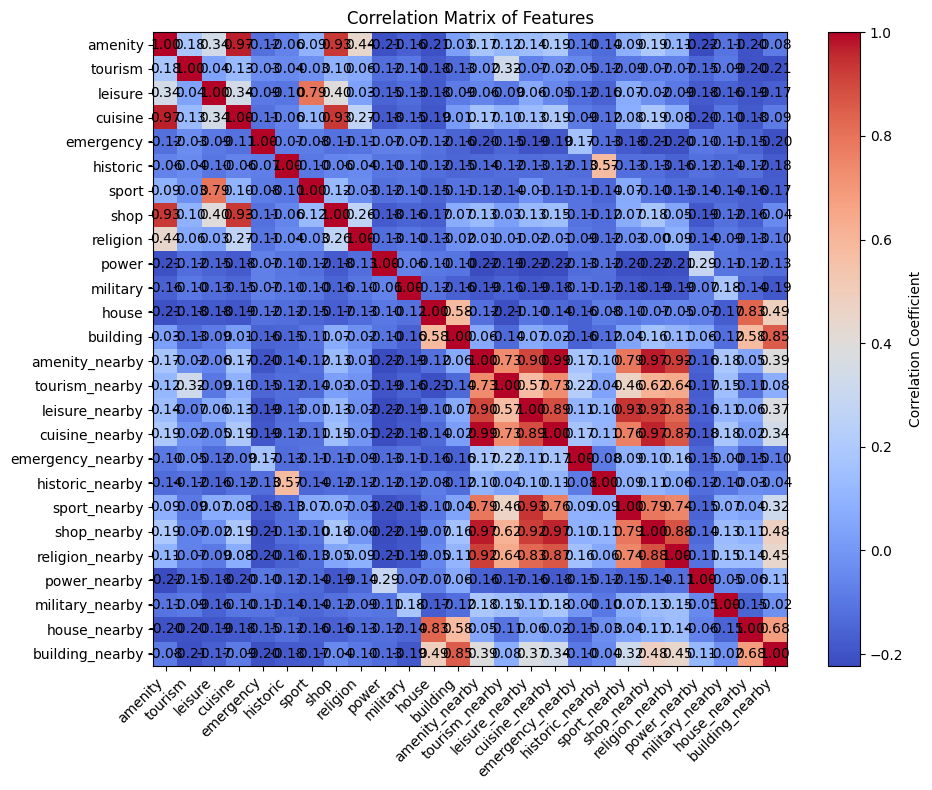

In [12]:
fynesse.assess.plot_correlation_matrix(corr_matr, [])

Let's analyse the plot:
- There is an obvious clusters of features correlated with each other (`amenity`, `tourism`, `leisure`, `cuisine`, `sport`, `shop`, `religion`);
- These features are also correlated with `building` (but not as good as with each other);
- `building` is highly correlated with `house`;
- `emergency`, `historic`, `power`, `military` are not really correlated with any of the features;
- Features are correlated with corresponding proximity features - this trend results in two subdiagonals in quaters 1 and 3 of the plot;
- This tendency reaches its peak on `historic`, `house`, `building`.

### Feature selection

Let's now conduct feature selection process for the future models predicting `NSSEC_L15_Norm` and `MI_AddrYearAgoOutUK_Norm` values.

We will need information obtained on earlier steps (`correlation_df` and `corr_matrix`) to do that effectively.

Feature selection process will have four main steps, as listed below.

1. Correlation matrix analysis

Our first step will be examining the correlation coefficients between each feature and the target variables. Higher absolute correlation indicates stronger linear relationship with the target variable.

After examining the correlations as presented in `correlation_df`, the following considerations seem to be reasonable:
- Features with correlations below certain threshold (for example, 10%) should be excluded due to having weak relationship with target variables.
- Features with higher correlations should be prioritised due to them explaining larger proportion of variance in target variables.

Features with high correlations with NSSEC_L15_Norm:
- `amenity_nearby` (29.82%)
- `tourism_nearby` (19.26%)
- `leisure_nearby` (19.32%)
- `cuisine_nearby` (25.00%)
- `sport_nearby` (15.73%)
- `shop_nearby` (20.27%)
- `religion_nearby` (30.82%)
- `military_nearby` (10.23%)
- `building_nearby` (12.35%)

Features with high correlations with MI_AddrYearAgoOutUK_Norm:
- `amenity_nearby` (31.81%)
- `tourism_nearby` (28.95%)
- `leisure_nearby` (19.99%)
- `cuisine_nearby` (27.94%)
- `emergency_nearby` (10.37%)
- `sport_nearby` (16.87%)
- `shop_nearby` (19.10%)
- `religion_nearby` (29.95%)
- `military_nearby` (10.75%)
- `amenity` (11.58%)

2. Domain knowledge and context

Features, as well as predicted metrics represent aspects of the socio-economic environment and infrastructure in the area.
- `NSSEC_L15_Norm` represents certain socio-economic class (students in this case), likely influenced by access to amenities, sport objects, etc.
- `MI_AddrYearAgoOutUK_Norm` represents immigration patterns, which are often tied to cultural facilities like tourism spots, cuisine diversity and places of worship.

These considerations can be very helpful in feature selection process.

3. Multicollinearity between features

Multicollinearity occurs when features are highly correlated with each other. It can lead to redundancy and hence problems with model coefficients. 

While correlation with predicted variable is obviously very important for feature selection, we also need to check for potential overlap among predictors.

4. We can finally present selected features for each target variable:

For `NSSEC_L15_Norm` - selected features showed moderate correlations (above ~0.2) and aligned with our understanding of socioeconomic factors:
- `amenity_nearby` (29.82%)
- `tourism_nearby` (19.26%)
- `cuisine_nearby` (25.00%)
- `sport_nearby` (15.73%)
- `religion_nearby` (30.82%)
- `military_nearby` (10.23%)
- `building_nearby` (12.35%)

For `MI_AddrYearAgoOutUK_Norm` - selected showed moderate correlations and reflect cultural diversity, which is linked with patterns of international migration:
- `amenity_nearby` (31.81%)
- `tourism_nearby` (28.95%)
- `cuisine_nearby` (27.94%)
- `emergency_nearby` (10.37%)
- `sport_nearby` (16.87%)
- `religion_nearby` (29.95%)
- `military_nearby` (10.75%)
- `amenity` (11.58%)

There are certain potential caveats that we have to be aware of:
- Correlation does not always imply causation;
- Feature importance for complex models might differ, as non-linear relationships could exist and correlation analysis may not fully capture these dependencies.

### Summary on Assess

During Assess stage we prepared and analysed raw data which was stored in the database during Access stage. 

This included the following:
- working with geometries;
- marking OSM objects with their output area codes;
- computing OSM metrics for each output area;
- comparing OSM metrics and census data to gain deeper insight;
- selecting features to be used for predictions during Address stage.

We can check the database contents using `fynesse.access.get_summary_on_db(conn)`. Four tables that we have worked with during this stage have the following view.

In [ ]:
"""
Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'NSSEC_L15_Norm', 'MI_AddrYearAgoOutUK_Norm')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012578616, 0.068571428)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09009009, 0.019841269)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.038834951, 0.017699115)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@", 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@', 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@', 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
 - idx_oa (BTREE): Column OA21CD

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, 'POLYGON ((160086.16956965212 31822.472745400475, 160086.58895984557 31829.71596022285, 160085.2825716251 31829.79709322439, 160085.32350359295 31830.864516799717, 160085.4148126958 31832.09674381002, 160060.78083433688 31833.507368218503, 160061.1484081984 31839.917552823725, 160069.0530244006 31839.472289172612, 160084.08304005134 31838.605765294487, 160092.44438522015 31838.12882112735, 160092.74705420376 31843.416970515507, 160128.22749901644 31841.395378445304, 160127.5900522634 31830.263617495773, 160125.9616744297 31830.348106398684, 160124.88135450747 31811.4506942546, 160117.04099638914 31811.892977273732, 160117.2887921534 31816.28140370059, 160111.7764561905 31816.596549069625, 160095.28945915794 31817.539766504895, 160095.53777390122 31821.939308143687, 160090.48467634825 31822.278339675016, 160086.16956965212 31822.472745400475), (160099.31215739273 31826.90398117411, 160099.22826281504 31825.35955047325, 160114.95581193813 31824.561936467944, 160115.49830795583 31835.17447969984, 160110.10594067888 31835.450809407223, 160099.7784352009 31835.982886881276, 160099.31215739273 31826.90398117411))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@[\x940\xb6\xb4\x8a\x03A\x98\xd3J\xd2m\x15\xdf@\x85\xe9\xb4B\xaa\x8a\x03A\xa8L\x93\x03s\x15\xdf@?\r\x89\x96\xaa\x8a\x03AhE>T\xb7\x15\xdf@\x93Q\x89Q\xab\x8a\x03A\x08\xf3\x0c1\x06\x16\xdf@\xa4\x12&?\xe6\x89\x03A`\x8c\xb8x`\x16\xdf@5\xa3\xf0/\xe9\x89\x03A\x90z/\xb9\xfa\x17\xdf@\x94\x0e\x98l(\x8a\x03A\xa8]\xfc9\xde\x17\xdf@\x06\xe7\x10\xaa\xa0\x8a\x03A8\xcc\xdb\xc4\xa6\x17\xdf@\x9b\xd6\x19\x8e\xe3\x8a\x03A@\xf8\x9a>\x88\x17\xdf@\xec\x8d\xf7\xf9\xe5\x8a\x03A\xe0\x19\xa5\xaf\xda\x18\xdf@\x1c\x01\xeb\xd1\x01\x8c\x03A\x08e\xe1MY\x18\xdf@2Rm\xb8\xfc\x8b\x03A\xc0\xea\x1b\xdf\x90\x15\xdf@\x08]\x82\xb1\xef\x8b\x03Ax\x0f`G\x96\x15\xdf@\x8e\x97\x03\r\xe7\x8b\x03A\x00\xb7,\xd8\xdc\x10\xdf@5\xea\xf5S\xa8\x8b\x03A\xb0&\x8a&\xf9\x10\xdf@\xb2BrO\xaa\x8b\x03A\xc0\xaa\x84\x02\x12\x12\xdf@\xc8\xa9.6~\x8b\x03A &\xdc-&\x12\xdf@\x87\xf6\xcfP\xfa\x8a\x03A\x80\xcf\x88\x8bb\x12\xdf@3g\\M\xfc\x8a\x03A\x80\xe7\x9f\x1d|\x13\xdf@G\xfe\x9d\xe0\xd3\x8a\x03AX6Q\xd0\x91\x13\xdf@rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@\x07\x00\x00\x00\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@lt{\xd3\x19\x8b\x03A\xf8\xfc\xdf\x02W\x14\xdf@\xbb\xba\x80\xa5\x97\x8b\x03A\x10`\xc4\xf6#\x14\xdf@\xad\xe1\x88\xfc\x9b\x8b\x03A(\xe7\xac*\xcb\x16\xdf@9m\xf7\xd8p\x8b\x03A0\xb3\x0f\xda\xdc\x16\xdf@\x0f<<:\x1e\x8b\x03A\xb0`\x9e\xe7\xfe\x16\xdf@\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@', 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, 'POLYGON ((166376.37276804046 41694.974749416986, 166375.0344211005 41696.05829827403, 166380.82997802846 41703.231912765885, 166382.27185992844 41702.06584648584, 166392.86590993474 41715.187303649174, 166421.93846893095 41691.84465051026, 166417.986551931 41686.95100738492, 166395.1886003087 41658.70729205961, 166366.0052828661 41682.132921668206, 166376.37276804046 41694.974749416986), (166393.36129452076 41673.0325111158, 166407.96616721348 41690.59953518893, 166394.70974411705 41701.56301420703, 166380.09772006687 41683.99633974003, 166393.36129452076 41673.0325111158))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\xe8\x91~F8O\x04A\x8cW\x94\xdd\x01\\\xe4@E\x85\xcb\xa3fO\x04A R\xd4k\xe7\\\xe4@\xee\xe5\xc4,rO\x04A\xe8\x16j\x1b\xc2\\\xe4@\x180b\xed\xc6O\x04A\xf48d\xfee^\xe4@\xb6\xff\xfb\x81\xafP\x04A\xc4\x81`\x07{[\xe4@\xbcVu\xe4\x8fP\x04A\x10\n\xa7n\xdeZ\xe4@\xef\xe0@\x82\xd9O\x04A\x18\xf5"\xa2VW\xe4@I\xbe\xd1\n\xf0N\x04A<\xf1\xe4@DZ\xe4@v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\x05\x00\x00\x00\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@C\xe0\xb5\xba?P\x04A\xa8kd/S[\xe4@\xdaR\x8e\xad\xd5O\x04A\xcc^6\x04\xb2\\\xe4@[u!\xc8`O\x04A\xe4\xe0\x03\xe2\x7fZ\xe4@\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@', 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, 'POLYGON ((166601.6469998361 41515.44198465673, 166618.31610309827 41522.928540665045, 166616.49293302154 41526.96247665322, 166614.42498174557 41531.441534391284, 166620.86700770017 41534.310207305214, 166623.43810670276 41528.76211560643, 166627.22310428528 41530.51135377839, 166633.42582582674 41516.8849150138, 166606.4721160039 41504.77180834714, 166601.6469998361 41515.44198465673))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@\xaa\x0fa\x87\xd2V\x04A\xac\xe9\x9a\xb6]F\xe4@5\xde\x86\xf1\xc3V\x04A\x98\xd6\x9b\xcc\xdeF\xe4@U\xd4\\f\xb3V\x04AT\xbb\x0c!nG\xe4@\xad\xbb\xa1\xef\xe6V\x04A\xdc\xde7\xed\xc9G\xe4@D\x16>\x81\xfbV\x04A\xacD@c\x18G\xe4@G\xe6\xea\xc8\x19W\x04A\\\x99\x02]PG\xe4@\xfd^\x17hKW\x04A\x80J9Q\x9cE\xe4@e\xc1\xe4\xc6sV\x04A8k\xa7\xb2\x18D\xe4@\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@', 'E00182758')
Indices:
 - geometry (SPATIAL): Column geometry
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - idx_oa (BTREE): Column OA21CD
"""

## Address

In Address stage our main aim will be to build a prediction model to predict selected census variables based on the features formed from OSM data.

We will both provide functions to make a prediction based on the pair of coordinates and conduct cross-validation of our model.

Starting by setting up connection to the database.

In [7]:
conn = fynesse.access.create_connection()

Connection established!


### Introducing helper functions

Let's introduce a couple of helper functions that will be helpful for constructing and evaluating prediction model.

First function will return code of output area in which point with given coordinates lies.

In [18]:
latitude=52.0
longitude=0.0

In [19]:
fynesse.address.oa_by_coordinates(latitude, longitude)

Connection established!


'E00119841'

Second function will return true value of given parameter in the output area in which point with given coordinates lies.

In [20]:
fynesse.address.get_true_from_census(latitude, longitude, column='NSSEC_L15_Norm')

Connection established!
Connection established!


0.045454545

In [21]:
fynesse.address.get_true_from_census(latitude, longitude, column='MI_AddrYearAgoOutUK_Norm')

Connection established!
Connection established!


0.004914004

### Choosing and evaluating model

Let's now determine which model we are going to use for making predictions. 

We will start with simple linear model, which predicts census metrics using linear formula on OSM feature counts.

First step will be to upload training and testing data from the databse into dataframe, as it's impossible to conduct testing directly on the database table.

In [ ]:
fynesse.access.db_to_csv(conn, 'census_data_1', 'backup/census_data_1.csv')
census_data_1_df = pd.read_csv('backup/census_data_1.csv')

Now let's define feature lists identified during Assess stage.

In [96]:
selected_features_for_nssec = ['amenity_nearby', 'tourism_nearby', 'cuisine_nearby', 'sport_nearby', 'religion_nearby', 'military_nearby', 'building_nearby']
selected_features_for_mi = ['amenity_nearby', 'tourism_nearby', 'cuisine_nearby', 'emergency_nearby', 'sport_nearby', 'religion_nearby', 'military_nearby', 'amenity', 'cuisine']

Finally, we are going to form dataframes with features and predicted variables.

In [109]:
x_for_nssec = census_data_1_df[selected_features_for_nssec].to_numpy()
y_for_nssec = census_data_1_df['NSSEC_L15_Norm'].to_numpy()

x_for_mi = census_data_1_df[selected_features_for_mi].to_numpy()
y_for_mi = census_data_1_df['MI_AddrYearAgoOutUK_Norm'].to_numpy()

Now let's cross-validate linear model using function from `fynesse.address`.

RMSE = 0.081505, R2 = -0.2661, CORR = 30.25%
RMSE = 0.083541, R2 = -0.1944, CORR = 33.51%
RMSE = 0.081991, R2 = -0.2229, CORR = 33.89%
RMSE = 0.084134, R2 = -0.2151, CORR = 32.58%
RMSE = 0.083523, R2 = -0.2321, CORR = 31.51%
RMSE = 0.080382, R2 = -0.2420, CORR = 32.85%
RMSE = 0.081503, R2 = -0.2167, CORR = 32.90%
RMSE = 0.081643, R2 = -0.2493, CORR = 32.13%
RMSE = 0.080167, R2 = -0.2247, CORR = 33.95%
RMSE = 0.080063, R2 = -0.2717, CORR = 31.22%

Average rmse across folds: 0.081845
Average r2 across folds: -0.2335
Average correlation across folds: 32.48%

Plotting predictions against true values for the last fold:


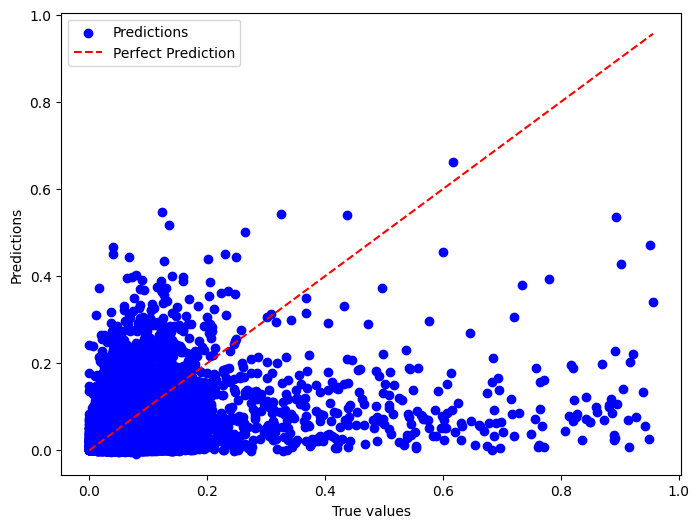

RMSE: 0.08006326424410135
R2: -0.27172878802897804
CORRELATION: 0.31216838684608017


In [119]:
rmses, r2s, correlations = fynesse.address.cross_validation(x_for_nssec, y_for_nssec, k=10, model_name='ols', plot_pt=True)

RMSE = 0.016419, R2 = 0.0638, CORR = 34.96%
RMSE = 0.016007, R2 = 0.0836, CORR = 37.19%
RMSE = 0.016561, R2 = 0.0778, CORR = 36.37%
RMSE = 0.014965, R2 = 0.0521, CORR = 36.20%
RMSE = 0.016301, R2 = 0.0718, CORR = 35.78%
RMSE = 0.015888, R2 = 0.0899, CORR = 38.01%
RMSE = 0.016697, R2 = 0.0982, CORR = 38.21%
RMSE = 0.016626, R2 = 0.0885, CORR = 37.29%
RMSE = 0.015971, R2 = 0.0707, CORR = 36.26%
RMSE = 0.015823, R2 = 0.0488, CORR = 33.73%

Average rmse across folds: 0.016126
Average r2 across folds: 0.0745
Average correlation across folds: 36.40%

Plotting predictions against true values for the last fold:


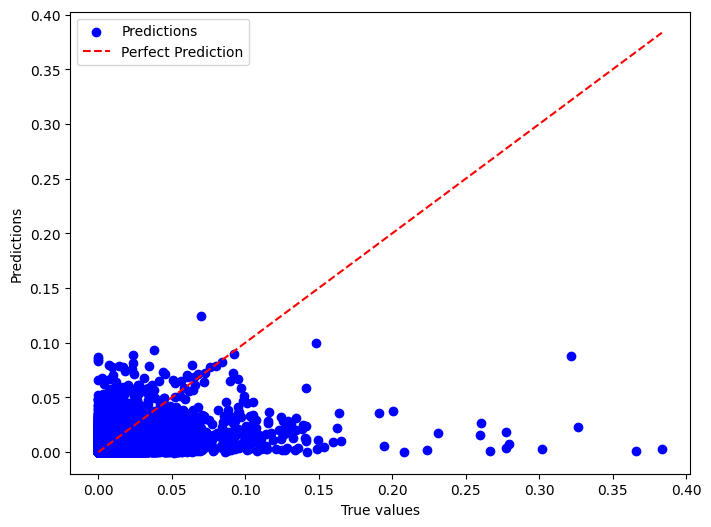

RMSE: 0.015822754580004254
R2: 0.04882853035379031
CORRELATION: 0.3372606079075841


In [120]:
rmses, r2s, correlations = fynesse.address.cross_validation(x_for_mi, y_for_mi, k=10, model_name='ols', plot_pt=True)

As you can see, R2 scores for both variables are too low for the model to be called good enough. 

In one case it's approximately `-0.25`-`-0.2`, which means that just giving mean all the time is better.

In the other case it's approximately `0.05`-`0.10`, which means that performance is better that mean but still isn't very good.

Hence, it makes sense to consider another model. Failure of linear model may mean that dependencies between OSM features and predicted census variables are not linear - and intuitevely, this seems to be the case. Therefore, we need another model to try to capture these non-linear dependencies more precisely. Let's try to use Random Forest Regression for this purpose.

RMSE = 0.062798, R2 = 0.2484, CORR = 50.14%
RMSE = 0.066000, R2 = 0.2545, CORR = 51.29%
RMSE = 0.064816, R2 = 0.2357, CORR = 48.76%
RMSE = 0.066721, R2 = 0.2358, CORR = 49.08%
RMSE = 0.065834, R2 = 0.2345, CORR = 48.63%
RMSE = 0.062486, R2 = 0.2494, CORR = 50.32%
RMSE = 0.065172, R2 = 0.2221, CORR = 47.43%
RMSE = 0.064033, R2 = 0.2315, CORR = 48.30%
RMSE = 0.062038, R2 = 0.2665, CORR = 51.87%
RMSE = 0.061648, R2 = 0.2460, CORR = 49.89%

Average rmse across folds: 0.064155
Average r2 across folds: 0.2424
Average correlation across folds: 49.57%

Plotting predictions against true values for the last fold:


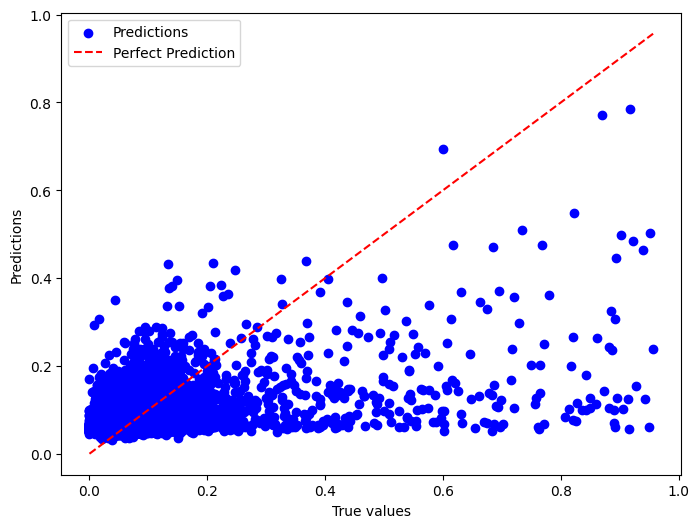

RMSE: 0.061647833948326215
R2: 0.2460135157364487
CORRELATION: 0.4988879679478281


In [121]:
rmses, r2s, correlations = fynesse.address.cross_validation(x_for_nssec, y_for_nssec, k=10, model_name='rfr', plot_pt=True)

RMSE = 0.015226, R2 = 0.1949, CORR = 44.15%
RMSE = 0.014763, R2 = 0.2206, CORR = 47.10%
RMSE = 0.015318, R2 = 0.2110, CORR = 45.95%
RMSE = 0.013696, R2 = 0.2060, CORR = 45.55%
RMSE = 0.015080, R2 = 0.2057, CORR = 45.36%
RMSE = 0.014583, R2 = 0.2332, CORR = 48.34%
RMSE = 0.015740, R2 = 0.1985, CORR = 44.56%
RMSE = 0.015385, R2 = 0.2195, CORR = 46.95%
RMSE = 0.014999, R2 = 0.1804, CORR = 42.72%
RMSE = 0.014709, R2 = 0.1780, CORR = 42.39%

Average rmse across folds: 0.014950
Average r2 across folds: 0.2048
Average correlation across folds: 45.31%

Plotting predictions against true values for the last fold:


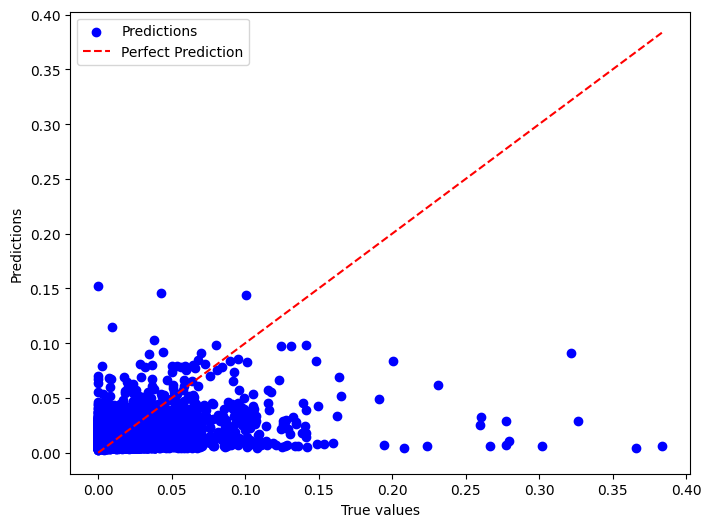

RMSE: 0.014708938664910211
R2: 0.17802746741765096
CORRELATION: 0.42391302387448565


In [123]:
rmses, r2s, correlations = fynesse.address.cross_validation(x_for_mi, y_for_mi, k=10, model_name='rfr', plot_pt=True)

As it was expected, Random Forest Regression works significantly better, leading to R2 scores of 0.20-0.25 and correlation of 45-50%.

### Predicting census variables

Let's now move to the last essential part of the project - demonstrating prediction functions to predict census variables by coordinates. Our functions should take as input a coordinate pair (we can assume it will be in England), and return an estimate for the share of students or migrants in that area.

In [15]:
latitude = 52.0
longitude = 0.0

In [16]:
warnings.simplefilter(action='ignore', category=FutureWarning)

true = fynesse.address.get_true_from_census(latitude, longitude, column='NSSEC_L15_Norm')
pred = fynesse.address.estimate_NSSEC_L15_Norm(latitude, longitude)
print(f"Prediction {pred} - True value {true}")

Connection established!
Connection established!
Connection established!
Data successfully exported to backup/census_data_1.csv
Connection established!
Prediction 0.05354058560007517 - True value 0.045454545


In [17]:
warnings.simplefilter(action='ignore', category=FutureWarning)

true = fynesse.address.get_true_from_census(latitude, longitude, column='MI_AddrYearAgoOutUK_Norm')
pred = fynesse.address.estimate_MI_AddrYearAgoOutUK_Norm(latitude, longitude)
print(f"Prediction {pred} - True value {true}")

Connection established!
Connection established!
Connection established!
Data successfully exported to backup/census_data_1.csv
Connection established!
Prediction 0.004520443009964911 - True value 0.004914004


Please be aware that these code snippets may run for up to 30 seconds, as prediction functions are doing full cycle of information retrieval starting from dowloading it from the database to csv file - this is to always have up-to-date data without the need of additional uploads.

### Summary on Address

By finishing Address stage we approach the end of Part 1 Project. In the Address stage we made a way from two lists of OSM features which we had from Assess stage to fully operational functions for predicting share of students and share of recently arrived migrants in the area. Our predictions are based on the OSM feature counts per output area.

Cross validation of two models has been conducted. This resulted in first (linear) model being marked as failed for our task and second (random forest regression) model being successful, with the following set of metrics obtained during cross-validation:
- Predicting share of students in the area:
  - Variable is in the range [0, 1];
  - RMSE 0.064;
  - R2 score 0.24;
  - Correlation 50%;
- Predicting share of newly arrived migrants in the area:
  - Variable is in the range [0, 1];
  - RMSE 0.015;
  - R2 score 0.20;
  - Correlation 45%.

With such information, project can be called a success.

## Discussion

### Story and structure

Marks awarded for inline explanation and structure, no need for answers here.

### Design decisions

One of the toughest design decisions I had to face during this project was to decide how to store geometrical data. While it's possible to do simple operations (such as computing area of polygon) in SQL, for more complex operations I needed to use dataframes. Limited time for this task puts further constraints on this topic.

### Comparison

Not sure what to put here - to be discussed.

### Reusability

Quite a big number of snippets of code produced during this project can be effectively reused. Most of such pieces of code has been placed into fynesse library, some of them still remain in the code.

# Task 2: miniproject (13 marks)

We expect your miniproject to be more advanced than the example project, and that's why we allocated more marks to it. The first 7 marks will be allocated similarly to Task 1.

6 remaining points are *bonus* - they will be allocated for going far beyond what you did in Task 1, either in data access, assess, address or story.

#### Choosing your topic

You are given a lot of flexibility in choosing a miniproject topic.

Some hints:
- Your project should be based on the Census, Price Paid, OSM and Election datasets.
- It's a good idea to pick something that you are interested in.
- Bear in mind there are no marks dedicated to your overall prediction accuracy, so there is no advantage to picking 'easy' topics. It is perfectly ok to not reach significant predictive power, as long as you followed the proper process.

Some guidelines:
- Do not make a miniproject that furthers discriminatory rhetoric. In general, avoid topics that could be insensitive. If in doubt, message Radzim Sendyka (and *cc* Christian Cabrera) to discuss if this applies to your idea.
- Please avoid any projects that would require approval from the ethics comittee.
- Pick the scope of your projects that will allow you to show your skills. Some projects might not be challenging enough while others might be hard to make any progress in. Don't be scared to report negative results.

Please email Radzim Sendyka (and *cc* Christian Cabrera) with your project idea when you begin working on it, so we can let you know about any potential concerns (eg. potentially insensive, too off-topic, too simple, too complex) as soon as we can. You can change the topic up to the submission deadline, but let us know again in cases of major changes.

Most of the advice from Task 1 still applies, particularly around using an online relational database, structuring your notebook, fynesse, access-assess-address, data readiness levels, hints.

Sources you may want to include in your data include:

  - UK Census Data
    - UK Census 2021 data [here](https://www.ons.gov.uk/search?topics=9731,6646,3845,9497,4262,4128,7755,4994,6885,9724,7367&filter=datasets) or [here](https://www.nomisweb.co.uk/sources/census_2021_bulk).
    - Historical Census data [here](https://www.ons.gov.uk/census/historiccensusdata).
    - Geographic coordinates of Census Output Areas [here](https://www.data.gov.uk/dataset/4d4e021d-fe98-4a0e-88e2-3ead84538537/output-areas-december-2021-boundaries-ew-bgc-v2).
  - Spatial data
    - You should already have a connection to OpenStreetMaps.
    - You might want to also download the entire map for England (or more) [here](https://download.openstreetmap.fr/extracts/) or [here](https://wiki.openstreetmap.org/wiki/Planet.osm).
  - Election data
    - Recent Election Results data [here](https://commonslibrary.parliament.uk/research-briefings/cbp-10009/)
    - Historical Election Results data [here](https://commonslibrary.parliament.uk/research-briefings/cbp-8647/#fullreport).
    - Lookup reference between Output Areas and Parliamentary Constituencies [here](https://geoportal.statistics.gov.uk/datasets/5968b5b2c0f14dd29ba277beaae6dec3_0/explore).
  - Price Paid Data
    - You should have this data already in your database.
  - OSM
    - You should know how to access this data from previous practicals.

Example ideas:

- Are areas correlated in terms of census results? If so, find the areas that are leading change, and the ones that are following.
- Which historical census variables used to predict election results in the past, but don't seem related anymore?
- Census results are only updated once a decade, but new roads and houses are built every year. Can census results, for example those relating to travel, be predicted from basic map information, such as street networks?
- Building new houses is our best way of tackling the housing crisis. Use the information on new builds in the house prices dataset to explore what factors drive new developments, and make predictions for where the next houses will be built.
- House styles differ a lot between regions and inhabitants. Can you make any predictions about the house or area simply from looking at it's geometric shape and orientation?

Note that the ideas are just a starting point question. You should include more in-depth investigations into the data, validate your findings where applicable, and prepare visualisations.

## How often do unexpected cultural or political shifts lead to unpredictable electoral outcomes?

## Brief project description

The aim of the project is to investigate how often unexpected factors (like region-specific cultural issues) that can not be explained based on demographic factors of the region can influence voting results.

To provide a throughout analysis of the issue, this project will use all available data - this includes census data, election data, osm data and housing prices data.

After getting the data in Access stage and filtering it at the beginning of Assess stage, we will do a throughout analysis on features to detect clusters of similar demographic profiles, to compare them to the voting patterns and to identify links between demographic features and voting outcomes.

In Address stage of the project we will build a couple of models to predict voting results based on the data we have. This will help us to find the regions where predictions deviate significantly from actual results. Identifying areas with anomalies in voting results will be a final part of the project.

## Imports

In [354]:
import seaborn as sns
import statsmodels.api as sm
from collections import Counter
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.covariance import EmpiricalCovariance

In [ ]:
%pip uninstall --yes fynesse
%pip install git+https://github.com/sdenyskov/sd995_ads_2024.git

In [2]:
import fynesse

## Access

Project starts with access stage. At this stage we will download all the necessary data from the web and upload it into the database with appropriate indexing.

As was mentioned in the project description, this project requires a comprehensive analysis of all available data, so we will need all of the following:
- Census datasets (we will take data for the lowest level - output areas);
- General elections data (comes in per parliamentary constituency format);
- OSM data - this data will be copied from the Part 1 Project, It is obviously possible to repeat all steps that we have made to get it to the current format, but this can be done just by running the same code and therefore this will not be covered for another time;
- Prices paid data - already present in our database since Lab 1, no downloads and uploads required, just a bit of restructuring might be helpful;
- Finally, we will need Output Areas to Parliamentary Constituencies lookup table to be able to translate all data that we have to 'per PC' format.

So, let's set up a connection to our database and let's get started on Access stage.

In [3]:
conn = fynesse.access.create_connection()

Connection established!


Another important design decision that I have to mention - all data needed for this project will be stored in `dataForPart2/` directory.

### General election data

Data for 2024 General election can be downloaded from the website mentioned below in the format of `.csv` file using `fynesse` function.

In [ ]:
url = "https://researchbriefings.files.parliament.uk/documents/CBP-10009/HoC-GE2024-results-by-constituency.csv"
file_name = "dataForPart2/GE2024_results.csv"
fynesse.access.download_data_csv([url], [file_name])

Let's now upload it to the newly created table.

In [609]:
query_create_ge_2024_results = """
CREATE TABLE IF NOT EXISTS `ge_2024_results` (
  `ONS_ID` varchar(9) COLLATE utf8_bin NOT NULL,
  `ONS_region_ID` varchar(9) COLLATE utf8_bin NOT NULL,
  `Constituency_name` tinytext COLLATE utf8_bin NOT NULL,
  `County_name` tinytext COLLATE utf8_bin NOT NULL,
  `Region_name` tinytext COLLATE utf8_bin NOT NULL,
  `Country_name` tinytext COLLATE utf8_bin NOT NULL,
  `Constituency_type` tinytext COLLATE utf8_bin NOT NULL,
  `Declaration_time` tinytext COLLATE utf8_bin NOT NULL,
  `Member_first_name` tinytext COLLATE utf8_bin NOT NULL,
  `Member_surname` tinytext COLLATE utf8_bin NOT NULL,
  `Member_gender` tinytext COLLATE utf8_bin NOT NULL,
  `Result` tinytext COLLATE utf8_bin NOT NULL,
  `First_party` tinytext COLLATE utf8_bin NOT NULL,
  `Second_party` tinytext COLLATE utf8_bin NOT NULL,
  `Electorate` int unsigned NOT NULL,
  `Valid_votes` int unsigned NOT NULL,
  `Invalid_votes` int unsigned NOT NULL,
  `Majority` int unsigned NOT NULL,
  `Con` int unsigned NOT NULL,
  `Lab` int unsigned NOT NULL,
  `LD` int unsigned NOT NULL,
  `RUK` int unsigned NOT NULL,
  `Green` int unsigned NOT NULL,
  `SNP` int unsigned NOT NULL,
  `PC` int unsigned NOT NULL,
  `DUP` int unsigned NOT NULL,
  `SF` int unsigned NOT NULL,
  `SDLP` int unsigned NOT NULL,
  `UUP` int unsigned NOT NULL,
  `APNI` int unsigned NOT NULL,
  `All_other_candidates` int unsigned NOT NULL,
  `Of_which_other_winner` int unsigned NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_ge_2024_results)

fynesse.access.csv_to_db(conn, 'dataForPart2/GE2024_results.csv', 'ge_2024_results', ignore_first_row=True)

Loading data into the table
Data loaded into the table ge_2024_results


Let's index this table on two types of IDs of PCs and on three types of results data, which we may have to look up later.

In [615]:
fynesse.access.create_single_index(conn, 'idx_ons_id', 'ge_2024_results', 'ONS_ID')
fynesse.access.create_single_index(conn, 'idx_ons_region_id', 'ge_2024_results', 'ONS_region_ID')
fynesse.access.create_single_index(conn, 'idx_result', 'ge_2024_results', 'Result')
fynesse.access.create_single_index(conn, 'idx_first_party', 'ge_2024_results', 'First_party')
fynesse.access.create_single_index(conn, 'idx_second_party', 'ge_2024_results', 'Second_party')

[]

### OA to PC lookup data

Looku table is available via the link (https://geoportal.statistics.gov.uk/datasets/5968b5b2c0f14dd29ba277beaae6dec3_0/explore) and can easily be downloaded and uploaded to the database using our usual methods.

In [613]:
query_create_oa_to_pc = """
CREATE TABLE IF NOT EXISTS `oa_to_pc` (
  `OA21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `PCON25CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `PCON25NM` tinytext COLLATE utf8_bin NOT NULL,
  `PCON25NMW` tinytext COLLATE utf8_bin NOT NULL,
  `LAD21CD` varchar(9) COLLATE utf8_bin NOT NULL,
  `LAD21NM` tinytext COLLATE utf8_bin NOT NULL,
  `ObjectId` int unsigned NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,
  PRIMARY KEY (`db_id`)
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;"""

fynesse.access.execute_query(conn, query_create_oa_to_pc)

fynesse.access.csv_to_db(conn, 'dataForPart2/Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.csv', 'oa_to_pc', ignore_first_row=True)

Loading data into the table
Data loaded into the table oa_to_pc


Let's set up indexes on all area codes, either OA-related or PC-related.

In [617]:
fynesse.access.create_single_index(conn, 'idx_oa21cd', 'oa_to_pc', 'OA21CD')
fynesse.access.create_single_index(conn, 'idx_pcon25cd', 'oa_to_pc', 'PCON25CD')
fynesse.access.create_single_index(conn, 'idx_lad21cd', 'oa_to_pc', 'LAD21CD')

[]

### Census and OSM data

OSM and Census data will be stored in the same table due to similar nature - both are features per output area, which will needs to be transformed to PCs in the future.

Let's start by copying OSM data from Part 1 Project table.

In [758]:
query = """
CREATE TABLE osm_and_census_data_2 AS
SELECT 
    date, geography_code AS OA21CD, db_id, 
    amenity, tourism, leisure, cuisine, emergency, historic, sport, shop, religion, power, military, house, building
FROM census_data_1;
"""
fynesse.access.execute_query(conn, query)

fynesse.access.execute_query(conn, "ALTER TABLE osm_and_census_data_2 ADD PRIMARY KEY (OA21CD);")

[]

Now it's time to select Census features. After spending some time on browsing https://www.nomisweb.co.uk/sources/census_2021_bulk I've selected the following list of features.

My criteria for feature selection was built of two parts:
- Target all most important demographic metrics, such as Age, Ethnicity, Employment, Qualification, being Local vs. Migrant, Health, etc.;
- For each targeted census table, select only a few columns which together will express general tendencies present in the dataset.

In [5]:
code_column_name = [
    ('TS007A', 8, 'Age_20_24'), 
    ('TS007A', 11, 'Age_35_39'), 
    ('TS007A', 14, 'Age_50_54'), 
    ('TS007A', 17, 'Age_65_69'),
    ('TS021', 4, 'Ethnic_Asian'),
    ('TS021', 10, 'Ethnic_Black'),
    ('TS021', 19, 'Ethnic_White'),
    ('TS054', 4, 'Tenure_Own'), 
    ('TS054', 7, 'Tenure_ShareOwn'), 
    ('TS054', 9, 'Tenure_SocRent'), 
    ('TS054', 12, 'Tenure_PrivRent'),
    ('TS066', 4, 'Economic_Act'), 
    ('TS066', 16, 'Economic_ActStudent'), 
    ('TS066', 28, 'Economic_Inact'),
    ('TS067', 4, 'Qualification_No'), 
    ('TS067', 5, 'Qualification_L1'), 
    ('TS067', 6, 'Qualification_L2'),
    ('TS004', 4, 'Birth_Europe'), 
    ('TS004', 5, 'Birth_UK'), 
    ('TS004', 13, 'Birth_Africa'), 
    ('TS004', 14, 'Birth_MEandAsia'),
    ('TS037', 4, 'Health_VeryGood'), 
    ('TS037', 6, 'Health_Fair'), 
    ('TS037', 8, 'Health_VeryBad')
]

Now we can check if we've got numbers and new titles of columns that we want right.

In [6]:
codes = list(set(triple[0] for triple in code_column_name))
codes.sort()

for code in codes:
    file_path = f'dataForPart2/census2021-{code.lower()}/census2021-{code.lower()}-oa.csv'
    print(f"Code: {code}")
    fynesse.access.print_columns(file_path)
    print()

Code: TS004
Column 0: date
Column 1: geography
Column 2: geography code
Column 3: Country of birth: Total; measures: Value
Column 4: Country of birth: Europe; measures: Value
Column 5: Country of birth: Europe: United Kingdom; measures: Value
Column 6: Country of birth: Europe: EU countries; measures: Value
Column 7: Country of birth: Europe: EU countries: European Union EU14; measures: Value
Column 8: Country of birth: Europe: EU countries: European Union EU8; measures: Value
Column 9: Country of birth: Europe: EU countries: European Union EU2; measures: Value
Column 10: Country of birth: Europe: EU countries: All other EU countries; measures: Value
Column 11: Country of birth: Europe: Non-EU countries; measures: Value
Column 12: Country of birth: Europe: Non-EU countries: All other non-EU countries; measures: Value
Column 13: Country of birth: Africa; measures: Value
Column 14: Country of birth: Middle East and Asia; measures: Value
Column 15: Country of birth: The Americas and the C

Finally, we can download data if it hasn't been downloaded yet and upload it into the database. Low level details can be seen in fynesse printout at the end of this notebook.

In [798]:
for element in code_column_name:
    code, column, name = element
    fynesse.access.add_census_feature(conn, 'osm_and_census_data_2', code, column, name, 'dataForPart2')

Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 20 to 24 years
Loading data into the table
Data loaded into the table temp
Column TS007A_8_Age_20_24 has been added to the table osm_and_census_data_2 successfully.
Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 35 to 39 years
Loading data into the table
Data loaded into the table temp
Column TS007A_11_Age_35_39 has been added to the table osm_and_census_data_2 successfully.
Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 50 to 54 years
Loading data into the table
Data loaded into the table temp
Column TS007A_14_Age_50_54 has been added to the table osm_and_census_data_2 successfully.
Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Aged 65 to 69 years
Loading data into the table
Data loaded into the table temp
Column TS007A_17_Age_65_69 has been added to the table osm_and_census_data_2 successfully.
Files alr

Finally, we are indexing the newly created table on output area code, as this is the column that will be used for future lookups and joins.

In [799]:
fynesse.access.create_single_index(conn, 'idx_oa', 'osm_and_census_data_2', 'OA21CD')

[]

### Summary on Access

During Access stage we downloaded and uploaded data that is needed for the project into the database. Running `fynesse.access.get_summary_on_db(conn)` can help to reveal the structure of the database at the current moment with all tables being listed in an alphabetical order.

In [ ]:
"""
Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'NSSEC_L15_Norm', 'MI_AddrYearAgoOutUK_Norm')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012578616, 0.068571428)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09009009, 0.019841269)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.038834951, 0.017699115)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table ge_2024_results - Approx Row Count 0.0M
('ONS_ID', 'ONS_region_ID', 'Constituency_name', 'County_name', 'Region_name', 'Country_name', 'Constituency_type', 'Declaration_time', 'Member_first_name', 'Member_surname', 'Member_gender', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All_other_candidates', 'Of_which_other_winner', 'db_id')
('W07000081', 'W92000004', 'Aberafan Maesteg', '', 'Wales', 'Wales', 'County', '', 'Stephen', 'Kinnock', 'Male', 'Lab hold', 'Lab', 'RUK', 72580, 35755, 79, 10354, 2903, 17838, 916, 7484, 1094, 0, 4719, 0, 0, 0, 0, 0, 801, 0, 1)
('E14001063', 'E12000008', 'Aldershot', '', 'South East', 'England', 'Borough', '', 'Alex', 'Baker', 'Female', 'Lab gain from Con', 'Lab', 'Con', 78553, 48544, 179, 5683, 14081, 19764, 4052, 8210, 2155, 0, 0, 0, 0, 0, 0, 0, 282, 0, 6)
('E14001064', 'E12000005', 'Aldridge-Brownhills', '', 'West Midlands', 'England', 'Borough', '', 'Wendy', 'Morton', 'Female', 'Con hold', 'Con', 'Lab', 70268, 40912, 156, 4294, 15901, 11607, 1755, 9903, 1746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_ons_id (BTREE): Column ONS_ID
 - idx_ons_region_id (BTREE): Column ONS_region_ID
 - idx_result (BTREE): Column Result
 - idx_first_party (BTREE): Column First_party
 - idx_second_party (BTREE): Column Second_party

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_to_pc - Approx Row Count 0.1M
('OA21CD', 'PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM', 'ObjectId', 'db_id')
('E00000337', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 1, 1)
('E00000338', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 2, 2)
('E00000340', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 3, 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_oa21cd (BTREE): Column OA21CD
 - idx_pcon25cd (BTREE): Column PCON25CD
 - idx_lad21cd (BTREE): Column LAD21CD

Table osm_and_census_data_2 - Approx Row Count 0.1M
('date', 'OA21CD', 'db_id', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad')
(2021, 'E00000001', 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 15, 24, 5, 3, 155, 72, 0, 7, 15, 98, 0, 63, 4, 7, 10, 149, 118, 0, 6, 98, 26, 0)
(2021, 'E00000003', 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 13, 20, 35, 24, 5, 209, 91, 0, 2, 17, 139, 1, 83, 5, 3, 8, 207, 184, 7, 18, 146, 15, 2)
(2021, 'E00000005', 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 5, 8, 12, 13, 0, 85, 40, 0, 2, 21, 68, 1, 36, 3, 2, 3, 88, 73, 2, 11, 62, 8, 0)
Indices:
 - PRIMARY (BTREE): Column OA21CD
 - idx_oa (BTREE): Column OA21CD

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@", 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@', 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@', 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
 - idx_oa (BTREE): Column OA21CD

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, 'POLYGON ((160086.16956965212 31822.472745400475, 160086.58895984557 31829.71596022285, 160085.2825716251 31829.79709322439, 160085.32350359295 31830.864516799717, 160085.4148126958 31832.09674381002, 160060.78083433688 31833.507368218503, 160061.1484081984 31839.917552823725, 160069.0530244006 31839.472289172612, 160084.08304005134 31838.605765294487, 160092.44438522015 31838.12882112735, 160092.74705420376 31843.416970515507, 160128.22749901644 31841.395378445304, 160127.5900522634 31830.263617495773, 160125.9616744297 31830.348106398684, 160124.88135450747 31811.4506942546, 160117.04099638914 31811.892977273732, 160117.2887921534 31816.28140370059, 160111.7764561905 31816.596549069625, 160095.28945915794 31817.539766504895, 160095.53777390122 31821.939308143687, 160090.48467634825 31822.278339675016, 160086.16956965212 31822.472745400475), (160099.31215739273 31826.90398117411, 160099.22826281504 31825.35955047325, 160114.95581193813 31824.561936467944, 160115.49830795583 31835.17447969984, 160110.10594067888 31835.450809407223, 160099.7784352009 31835.982886881276, 160099.31215739273 31826.90398117411))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@[\x940\xb6\xb4\x8a\x03A\x98\xd3J\xd2m\x15\xdf@\x85\xe9\xb4B\xaa\x8a\x03A\xa8L\x93\x03s\x15\xdf@?\r\x89\x96\xaa\x8a\x03AhE>T\xb7\x15\xdf@\x93Q\x89Q\xab\x8a\x03A\x08\xf3\x0c1\x06\x16\xdf@\xa4\x12&?\xe6\x89\x03A`\x8c\xb8x`\x16\xdf@5\xa3\xf0/\xe9\x89\x03A\x90z/\xb9\xfa\x17\xdf@\x94\x0e\x98l(\x8a\x03A\xa8]\xfc9\xde\x17\xdf@\x06\xe7\x10\xaa\xa0\x8a\x03A8\xcc\xdb\xc4\xa6\x17\xdf@\x9b\xd6\x19\x8e\xe3\x8a\x03A@\xf8\x9a>\x88\x17\xdf@\xec\x8d\xf7\xf9\xe5\x8a\x03A\xe0\x19\xa5\xaf\xda\x18\xdf@\x1c\x01\xeb\xd1\x01\x8c\x03A\x08e\xe1MY\x18\xdf@2Rm\xb8\xfc\x8b\x03A\xc0\xea\x1b\xdf\x90\x15\xdf@\x08]\x82\xb1\xef\x8b\x03Ax\x0f`G\x96\x15\xdf@\x8e\x97\x03\r\xe7\x8b\x03A\x00\xb7,\xd8\xdc\x10\xdf@5\xea\xf5S\xa8\x8b\x03A\xb0&\x8a&\xf9\x10\xdf@\xb2BrO\xaa\x8b\x03A\xc0\xaa\x84\x02\x12\x12\xdf@\xc8\xa9.6~\x8b\x03A &\xdc-&\x12\xdf@\x87\xf6\xcfP\xfa\x8a\x03A\x80\xcf\x88\x8bb\x12\xdf@3g\\M\xfc\x8a\x03A\x80\xe7\x9f\x1d|\x13\xdf@G\xfe\x9d\xe0\xd3\x8a\x03AX6Q\xd0\x91\x13\xdf@rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@\x07\x00\x00\x00\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@lt{\xd3\x19\x8b\x03A\xf8\xfc\xdf\x02W\x14\xdf@\xbb\xba\x80\xa5\x97\x8b\x03A\x10`\xc4\xf6#\x14\xdf@\xad\xe1\x88\xfc\x9b\x8b\x03A(\xe7\xac*\xcb\x16\xdf@9m\xf7\xd8p\x8b\x03A0\xb3\x0f\xda\xdc\x16\xdf@\x0f<<:\x1e\x8b\x03A\xb0`\x9e\xe7\xfe\x16\xdf@\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@', 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, 'POLYGON ((166376.37276804046 41694.974749416986, 166375.0344211005 41696.05829827403, 166380.82997802846 41703.231912765885, 166382.27185992844 41702.06584648584, 166392.86590993474 41715.187303649174, 166421.93846893095 41691.84465051026, 166417.986551931 41686.95100738492, 166395.1886003087 41658.70729205961, 166366.0052828661 41682.132921668206, 166376.37276804046 41694.974749416986), (166393.36129452076 41673.0325111158, 166407.96616721348 41690.59953518893, 166394.70974411705 41701.56301420703, 166380.09772006687 41683.99633974003, 166393.36129452076 41673.0325111158))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\xe8\x91~F8O\x04A\x8cW\x94\xdd\x01\\\xe4@E\x85\xcb\xa3fO\x04A R\xd4k\xe7\\\xe4@\xee\xe5\xc4,rO\x04A\xe8\x16j\x1b\xc2\\\xe4@\x180b\xed\xc6O\x04A\xf48d\xfee^\xe4@\xb6\xff\xfb\x81\xafP\x04A\xc4\x81`\x07{[\xe4@\xbcVu\xe4\x8fP\x04A\x10\n\xa7n\xdeZ\xe4@\xef\xe0@\x82\xd9O\x04A\x18\xf5"\xa2VW\xe4@I\xbe\xd1\n\xf0N\x04A<\xf1\xe4@DZ\xe4@v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\x05\x00\x00\x00\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@C\xe0\xb5\xba?P\x04A\xa8kd/S[\xe4@\xdaR\x8e\xad\xd5O\x04A\xcc^6\x04\xb2\\\xe4@[u!\xc8`O\x04A\xe4\xe0\x03\xe2\x7fZ\xe4@\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@', 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, 'POLYGON ((166601.6469998361 41515.44198465673, 166618.31610309827 41522.928540665045, 166616.49293302154 41526.96247665322, 166614.42498174557 41531.441534391284, 166620.86700770017 41534.310207305214, 166623.43810670276 41528.76211560643, 166627.22310428528 41530.51135377839, 166633.42582582674 41516.8849150138, 166606.4721160039 41504.77180834714, 166601.6469998361 41515.44198465673))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@\xaa\x0fa\x87\xd2V\x04A\xac\xe9\x9a\xb6]F\xe4@5\xde\x86\xf1\xc3V\x04A\x98\xd6\x9b\xcc\xdeF\xe4@U\xd4\\f\xb3V\x04AT\xbb\x0c!nG\xe4@\xad\xbb\xa1\xef\xe6V\x04A\xdc\xde7\xed\xc9G\xe4@D\x16>\x81\xfbV\x04A\xacD@c\x18G\xe4@G\xe6\xea\xc8\x19W\x04A\\\x99\x02]PG\xe4@\xfd^\x17hKW\x04A\x80J9Q\x9cE\xe4@e\xc1\xe4\xc6sV\x04A8k\xa7\xb2\x18D\xe4@\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@', 'E00182758')
Indices:
 - geometry (SPATIAL): Column geometry
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - idx_oa (BTREE): Column OA21CD

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude
"""

## Assess

Assess stage is going to contain multiple important parts. We will start with filtering data and working with house price data, we will then translate all information we ahve to 'per PC' format. We will then conduct feature analysis to detect clusters of similar demographic and voting profiles, to compare them with each other and to identify links between demographic features and voting outcomes.

As always, let's start with connecting to the database.

In [7]:
conn = fynesse.access.create_connection()

Connection established!


### Filtering and preparing the data

Our current task is to create a table with per-PC feature counts. Four tables listed below are all what we need on this step.

In [ ]:
"""
Table ge_2024_results - Approx Row Count 0.0M
('ONS_ID', 'ONS_region_ID', 'Constituency_name', 'County_name', 'Region_name', 'Country_name', 'Constituency_type', 'Declaration_time', 'Member_first_name', 'Member_surname', 'Member_gender', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All_other_candidates', 'Of_which_other_winner', 'db_id')
('W07000081', 'W92000004', 'Aberafan Maesteg', '', 'Wales', 'Wales', 'County', '', 'Stephen', 'Kinnock', 'Male', 'Lab hold', 'Lab', 'RUK', 72580, 35755, 79, 10354, 2903, 17838, 916, 7484, 1094, 0, 4719, 0, 0, 0, 0, 0, 801, 0, 1)
('E14001063', 'E12000008', 'Aldershot', '', 'South East', 'England', 'Borough', '', 'Alex', 'Baker', 'Female', 'Lab gain from Con', 'Lab', 'Con', 78553, 48544, 179, 5683, 14081, 19764, 4052, 8210, 2155, 0, 0, 0, 0, 0, 0, 0, 282, 0, 6)
('E14001064', 'E12000005', 'Aldridge-Brownhills', '', 'West Midlands', 'England', 'Borough', '', 'Wendy', 'Morton', 'Female', 'Con hold', 'Con', 'Lab', 70268, 40912, 156, 4294, 15901, 11607, 1755, 9903, 1746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_ons_id (BTREE): Column ONS_ID
 - idx_ons_region_id (BTREE): Column ONS_region_ID
 - idx_result (BTREE): Column Result
 - idx_first_party (BTREE): Column First_party
 - idx_second_party (BTREE): Column Second_party

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_to_pc - Approx Row Count 0.1M
('OA21CD', 'PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM', 'ObjectId', 'db_id')
('E00000337', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 1, 1)
('E00000338', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 2, 2)
('E00000340', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 3, 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_oa21cd (BTREE): Column OA21CD
 - idx_pcon25cd (BTREE): Column PCON25CD
 - idx_lad21cd (BTREE): Column LAD21CD

Table osm_and_census_data_2 - Approx Row Count 0.1M
('date', 'OA21CD', 'db_id', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad')
(2021, 'E00000001', 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 15, 24, 5, 3, 155, 72, 0, 7, 15, 98, 0, 63, 4, 7, 10, 149, 118, 0, 6, 98, 26, 0)
(2021, 'E00000003', 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 13, 20, 35, 24, 5, 209, 91, 0, 2, 17, 139, 1, 83, 5, 3, 8, 207, 184, 7, 18, 146, 15, 2)
(2021, 'E00000005', 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 5, 8, 12, 13, 0, 85, 40, 0, 2, 21, 68, 1, 36, 3, 2, 3, 88, 73, 2, 11, 62, 8, 0)
Indices:
 - PRIMARY (BTREE): Column OA21CD
 - idx_oa (BTREE): Column OA21CD
"""

Let's see how many PCs are there in each region.

In [739]:
fynesse.assess.print_counts_per_region(conn, 'ge_2024_results', 'ONS_ID')

Total: 650
E: 543
W: 32
S: 57
N: 18


We will be dealing with England and Wales only as we don't have enough data for scotland and Northern Ireland, hence let's delete unwanted PCs from `ge_2024_results`.

In [741]:
fynesse.access.execute_query(conn, "DELETE FROM ge_2024_results WHERE ONS_ID LIKE 'N%' OR ONS_ID LIKE 'S%';")

[]

Double-checking shows that we are left with just 575 PCs.

In [742]:
fynesse.assess.print_counts_per_region(conn, 'ge_2024_results', 'ONS_ID')

Total: 575
E: 543
W: 32
S: 0
N: 0


Now let's create new table containing information about geography of each PC by joining PC data from `ge_2024_results` with OA data `oa_data` via connecting table `oa_to_pc`.

In [750]:
query = """
CREATE TABLE pc_data AS
SELECT
    ge_2024_results.ONS_ID,
    CAST(AVG(oa_data.BNG_E) AS FLOAT) AS BNG_E,
    CAST(AVG(oa_data.BNG_N) AS FLOAT) AS BNG_N,
    AVG(oa_data.LAT) AS LAT,
    AVG(oa_data.LON) AS LON,
    SUM(oa_data.ShapeArea) AS AREA
FROM
    ge_2024_results
JOIN
    oa_to_pc ON ge_2024_results.ONS_ID = oa_to_pc.PCON25CD
JOIN
    oa_data ON oa_to_pc.OA21CD = oa_data.OA21CD
GROUP BY
    ge_2024_results.ONS_ID;
"""
fynesse.access.execute_query(conn, query)

fynesse.access.execute_query(conn, "ALTER TABLE pc_data ADD PRIMARY KEY (ONS_ID);")

[]

Now it's time to add OSM and census feature counts to per-PC data, finding sums in each PC beforehand. Low level details of this operation are hidden in `fynesse.assess`.

In [817]:
features_to_add = list(fynesse.access.execute_query(conn, "SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'osm_and_census_data_2';"))
features_to_add = [el[0] for el in features_to_add]
features_to_add = features_to_add[3:]

for feature in features_to_add:
    fynesse.assess.add_feature_from_oa_to_pc_data(conn, 'osm_and_census_data_2', feature)

### Adding prices paid data to form new features of parliamentary constituencies

Finally, it's time to process house prices, to form some feature counts based on that data and to append them to `pc_data`.

We will look at all houses bought in the last 2 years and 2 month (from 08-2022 to 09-2024) - this number can be changed easily at the cost of query running time, but having data for a bit more that the last 2 years are enough for our task - this data can give good insight into what house prices in each particular area look like.

So let's select the rows we are interested in to separate table, and let's then index the table on `postcode`, `date_of_transfer` and 'db_id' - these fields are likely to be used for variuos lookups.

In [1059]:
query = """
CREATE TABLE pp_data_with_geography
SELECT * FROM pp_data 
WHERE date_of_transfer >= '2022-08-01';
"""
fynesse.access.execute_query(conn, query)

query = """
ALTER TABLE pp_data_with_geography 
ADD COLUMN easting FLOAT, 
ADD COLUMN northing FLOAT,
ADD COLUMN geography POINT
ADD COLUMN OA21CD varchar(9);;
"""
fynesse.access.execute_query(conn, query)

fynesse.access.create_single_index(conn, 'idx_db_id', 'pp_data_with_geography', 'db_id')
fynesse.access.create_single_index(conn, 'idx_postcode', 'pp_data_with_geography', 'postcode')
fynesse.access.create_single_index(conn, 'idx_date_of_transfer', 'pp_data_with_geography', 'date_of_transfer')

[]

Time to add geography in the format specififed in query above (`easting`, `northing` and point `geometry` combining them) to the table - once again, low level details are hidden in `fynesse.assess`.

This fucntion also marks houses with the code `OA21CD` of the output area to whic they belong.

In [ ]:
year = 2024
month = 9

for _ in range(26):

    fynesse.assess.add_geography_and_oa_to_pp_data(conn, year, month)
    
    if month == 1:
        year -= 1
        month = 12
    else:
        month -= 1

Let's now get rid of all houses without valid output area code - their number is less than 10K with 2 year data taking about 1.6M rows.

In [1174]:
fynesse.access.execute_query(conn, "SELECT COUNT(*) FROM pp_data_with_geography;")[0][0]

1612832

1612832

In [1229]:
fynesse.access.execute_query(conn, "DELETE FROM pp_data_with_geography WHERE OA21CD IS NULL;")

[]

In [1233]:
fynesse.access.execute_query(conn, "SELECT COUNT(*) FROM pp_data_with_geography;")[0][0]

1605461

Let's also add new index on output area code `OA21CD` to the table for future lookups.

In [1234]:
fynesse.access.create_single_index(conn, 'idx_oa', 'pp_data_with_geography', 'OA21CD')

[]

Running `fynesse.access.get_summary_on_table(conn, 'pp_data_with_geography')` gives us current view of `pp_data_with_geography`.

In [ ]:
"""
Table pp_data_with_geography - Approx Row Count 1.5M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id', 'easting', 'northing', 'geography', 'OA21CD')
('{E7B085FC-4E71-7E31-E053-6C04A8C0E67F}', 590000, datetime.date(2022, 8, 12), 'ME18 5AQ', 'D', 'N', 'F', 'HAVENFIELD', '', 'THE STREET', 'TESTON', 'MAIDSTONE', 'MAIDSTONE', 'KENT', 'A', 'A', 29360121, 570449.0, 153417.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\xa2h!A\x00\x00\x00\x00H\xba\x02A', 'E00123488')
('{E7B085FC-4E77-7E31-E053-6C04A8C0E67F}', 485000, datetime.date(2022, 8, 10), 'DA16 1RH', 'S', 'N', 'F', '48', '', 'CHARMOUTH ROAD', '', 'WELLING', 'BEXLEY', 'GREATER LONDON', 'A', 'A', 29360137, 547084.0, 176725.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x18\xb2 A\x00\x00\x00\x00\xa8\x92\x05A', 'E00002211')
('{045A1898-F79B-9A24-E063-4804A8C048EA}', 412500, datetime.date(2022, 11, 16), 'BR1 1AG', 'F', 'N', 'L', 'WILLIAM HOUSE', 'FLAT 85', 'RINGERS ROAD', '', 'BROMLEY', 'BROMLEY', 'GREATER LONDON', 'A', 'A', 29360879, 540259.0, 168855.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\xc6| A\x00\x00\x00\x00\xb8\x9c\x04A', 'E00182600')
Indices:
 - idx_db_id (BTREE): Column db_id
 - idx_postcode (BTREE): Column postcode
 - idx_date_of_transfer (BTREE): Column date_of_transfer
 - idx_oa (BTREE): Column OA21CD
"""

Checking meaning of these unclear fields:

```
fynesse.access.execute_query(conn, f"SELECT DISTINCT property_type FROM pp_data_with_geography;")
fynesse.access.execute_query(conn, f"SELECT DISTINCT new_build_flag FROM pp_data_with_geography;")
fynesse.access.execute_query(conn, f"SELECT DISTINCT tenure_type FROM pp_data_with_geography;")
```

property_type - the type of property sold.
- T - Terraced - A house that shares walls with houses on both sides.  
- D - Detached - A standalone house with no shared walls.  
- F - Flat/Maisonette - A flat (apartment) or maisonette, typically in a shared building.  
- S - Semi-Detached - A house that shares a wall with one neighboring property.  
- O - Other - Any property type that does not fit into the above categories.

new_build_flag - whether the house being sold is newly built or not.
- N - No
- Y - Yes

tenure_type - the legal ownership arrangement of the property.
- F - Freehold - The buyer owns the property and the land it stands on indefinitely.  
- L - Leasehold - The buyer owns the property for a specific period (e.g., 99 or 125 years) but not the land it stands on. Ownership reverts to the freeholder when the lease expires.

Time to create statistics of house prices per output area.

In [1261]:
query = f"""
CREATE TABLE pp_data_per_oa (
    OA21CD VARCHAR(9) PRIMARY KEY,
    houses_sum_of_prices FLOAT DEFAULT 0,
    houses_total_number INT DEFAULT 0,
    houses_terraced INT DEFAULT 0,
    houses_detached INT DEFAULT 0,
    houses_flat INT DEFAULT 0,
    houses_semidetached INT DEFAULT 0,
    houses_other INT DEFAULT 0,
    houses_old INT DEFAULT 0,
    houses_new INT DEFAULT 0,
    houses_freehold INT DEFAULT 0,
    houses_leasehold INT DEFAULT 0
);
"""
fynesse.access.execute_query(conn, query)

query = f"""
INSERT INTO pp_data_per_oa (
    OA21CD,
    houses_sum_of_prices,
    houses_total_number,
    houses_terraced,
    houses_detached,
    houses_flat,
    houses_semidetached,
    houses_other,
    houses_old,
    houses_new,
    houses_freehold,
    houses_leasehold
)
SELECT 
    OA21CD,
    SUM(price) AS houses_sum_of_prices,
    COUNT(*) AS houses_total_number,
    COUNT(CASE WHEN property_type = 'T' THEN 1 END) AS houses_terraced,
    COUNT(CASE WHEN property_type = 'D' THEN 1 END) AS houses_detached,
    COUNT(CASE WHEN property_type = 'F' THEN 1 END) AS houses_flat,
    COUNT(CASE WHEN property_type = 'S' THEN 1 END) AS houses_semidetached,
    COUNT(CASE WHEN property_type = 'O' THEN 1 END) AS houses_other,
    COUNT(CASE WHEN new_build_flag = 'N' THEN 1 END) AS houses_old,
    COUNT(CASE WHEN new_build_flag = 'Y' THEN 1 END) AS houses_new,
    COUNT(CASE WHEN tenure_type = 'F' THEN 1 END) AS houses_freehold,
    COUNT(CASE WHEN tenure_type = 'L' THEN 1 END) AS houses_leasehold
FROM pp_data_with_geography
GROUP BY OA21CD;
"""
fynesse.access.execute_query(conn, query)

[]

Checking how `pp_data_per_oa` looks using `fynesse.access.get_summary_on_table(conn, 'pp_data_per_oa')`.

In [ ]:
"""
Table pp_data_per_oa - Approx Row Count 0.1M
('OA21CD', 'houses_sum_of_prices', 'houses_total_number', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_average_price')
('E00000001', 11770000.0, 7, 0, 0, 7, 0, 0, 7, 0, 0, 7, 1681430.0)
('E00000003', 19530100.0, 11, 2, 0, 9, 0, 0, 11, 0, 0, 11, 1775470.0)
('E00000005', 22325400.0, 23, 0, 0, 23, 0, 0, 23, 0, 0, 23, 970670.0)
Indices:
 - PRIMARY (BTREE): Column OA21CD
"""

Moving from per-OA counts to per-PC counts, just like we did earlier.

In [ ]:
features_to_add = list(fynesse.access.execute_query(conn, "SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'pp_data_per_oa';"))
features_to_add = [el[0] for el in features_to_add]
features_to_add = features_to_add[1:]

for feature in features_to_add:
    fynesse.assess.add_feature_from_oa_to_pc_data(conn, 'pp_data_per_oa', feature)

Finally, we can compute average house price per PC. This can be done using the following code.

In [ ]:
query = f"""
ALTER TABLE pc_data
ADD COLUMN houses_average_price FLOAT;
"""
fynesse.access.execute_query(conn, query)

query = f"""
UPDATE pc_data
SET houses_average_price = 
    CASE 
        WHEN houses_total_number = 0 THEN 0
        ELSE houses_sum_of_prices / houses_total_number
    END;
"""
fynesse.access.execute_query(conn, query)

Executing `fynesse.access.get_summary_on_table(conn, 'pc_data')z gives the following:

In [ ]:
"""
Table pc_data - Approx Row Count 0.0M
('ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_sum_of_prices', 'houses_total_number', 'houses_average_price')
('E14001063', 486019.0, 154644.0, 51.28444433858401, -0.7679580485594628, 56663490.720703125, 105, 5, 7, 41, 2, 0, 5, 134, 8, 0, 0, 2488, 4433, 6578, 8868, 8190, 4961, 15588, 2776, 93164, 29186, 799, 6957, 9222, 63367, 1733, 30563, 16909, 11352, 13753, 98776, 91404, 2603, 14448, 58348, 13623, 915, 793, 494, 798, 829, 104, 2767, 251, 2181, 837, 1269768176, 3018, 420732)
('E14001064', 404904.0, 301132.0, 52.60795950731694, -1.9290075487648415, 53757197.34863281, 76, 1, 1, 17, 0, 1, 3, 28, 10, 3, 0, 389, 5184, 4576, 5463, 6977, 4803, 8130, 1952, 79884, 29470, 220, 5250, 4210, 44266, 1157, 31547, 16897, 8201, 10965, 89496, 87678, 787, 2870, 41645, 13570, 1253, 488, 513, 329, 933, 62, 2324, 1, 1832, 493, 653306461, 2325, 280992)
('E14001065', 377431.0, 389086.0, 53.39812510788061, -2.340879815399267, 51612935.833496094, 19, 3, 1, 6, 0, 0, 3, 20, 7, 0, 0, 16, 179, 3925, 6963, 7225, 4806, 12185, 1658, 81296, 30216, 239, 4637, 5618, 48577, 1208, 29675, 9143, 5680, 9708, 90441, 86205, 1617, 7792, 56963, 10116, 886, 590, 541, 642, 934, 102, 2743, 66, 1809, 1000, 1620365202, 2809, 576848)
Indices:
 - PRIMARY (BTREE): Column ONS_ID
"""

### Getting data per parliamentary constituencies

Now, as we have all the data per parliamentary constituency we need, let's move to analysing the demographic and voting characteristics.

Needed data is splitted between to tables - `pc_data` and `ge_2024_results`, contents of which can be checked using the following code:

```
fynesse.access.get_summary_on_table(conn, 'pc_data')
fynesse.access.get_summary_on_table(conn, 'ge_2024_results')
```

Output is shown below.

In [ ]:
"""
Table pc_data - Approx Row Count 0.0M
('ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_sum_of_prices', 'houses_total_number', 'houses_average_price')
('E14001063', 486019.0, 154644.0, 51.28444433858401, -0.7679580485594628, 56663490.720703125, 105, 5, 7, 41, 2, 0, 5, 134, 8, 0, 0, 2488, 4433, 6578, 8868, 8190, 4961, 15588, 2776, 93164, 29186, 799, 6957, 9222, 63367, 1733, 30563, 16909, 11352, 13753, 98776, 91404, 2603, 14448, 58348, 13623, 915, 793, 494, 798, 829, 104, 2767, 251, 2181, 837, 1269768176, 3018, 420732)
('E14001064', 404904.0, 301132.0, 52.60795950731694, -1.9290075487648415, 53757197.34863281, 76, 1, 1, 17, 0, 1, 3, 28, 10, 3, 0, 389, 5184, 4576, 5463, 6977, 4803, 8130, 1952, 79884, 29470, 220, 5250, 4210, 44266, 1157, 31547, 16897, 8201, 10965, 89496, 87678, 787, 2870, 41645, 13570, 1253, 488, 513, 329, 933, 62, 2324, 1, 1832, 493, 653306461, 2325, 280992)
('E14001065', 377431.0, 389086.0, 53.39812510788061, -2.340879815399267, 51612935.833496094, 19, 3, 1, 6, 0, 0, 3, 20, 7, 0, 0, 16, 179, 3925, 6963, 7225, 4806, 12185, 1658, 81296, 30216, 239, 4637, 5618, 48577, 1208, 29675, 9143, 5680, 9708, 90441, 86205, 1617, 7792, 56963, 10116, 886, 590, 541, 642, 934, 102, 2743, 66, 1809, 1000, 1620365202, 2809, 576848)
Indices:
 - PRIMARY (BTREE): Column ONS_ID

Table ge_2024_results - Approx Row Count 0.0M
('ONS_ID', 'ONS_region_ID', 'Constituency_name', 'County_name', 'Region_name', 'Country_name', 'Constituency_type', 'Declaration_time', 'Member_first_name', 'Member_surname', 'Member_gender', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All_other_candidates', 'Of_which_other_winner', 'db_id')
('W07000081', 'W92000004', 'Aberafan Maesteg', '', 'Wales', 'Wales', 'County', '', 'Stephen', 'Kinnock', 'Male', 'Lab hold', 'Lab', 'RUK', 72580, 35755, 79, 10354, 2903, 17838, 916, 7484, 1094, 0, 4719, 0, 0, 0, 0, 0, 801, 0, 1)
('E14001063', 'E12000008', 'Aldershot', '', 'South East', 'England', 'Borough', '', 'Alex', 'Baker', 'Female', 'Lab gain from Con', 'Lab', 'Con', 78553, 48544, 179, 5683, 14081, 19764, 4052, 8210, 2155, 0, 0, 0, 0, 0, 0, 0, 282, 0, 6)
('E14001064', 'E12000005', 'Aldridge-Brownhills', '', 'West Midlands', 'England', 'Borough', '', 'Wendy', 'Morton', 'Female', 'Con hold', 'Con', 'Lab', 70268, 40912, 156, 4294, 15901, 11607, 1755, 9903, 1746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_ons_id (BTREE): Column ONS_ID
 - idx_ons_region_id (BTREE): Column ONS_region_ID
 - idx_result (BTREE): Column Result
 - idx_first_party (BTREE): Column First_party
 - idx_second_party (BTREE): Column Second_party
"""

As each of these tables contains only 575 rows, we can easily work with them using dataframes. This is, in fact, required, because methods of data analysis (such as clustering, training models, etc) require data to be in the format of dataframes.

Even if we had 10x as many rows as we have now, the task would still remain doable, so in our case we shouldn't be conserned about this at all.

For simplicity, let's join these two tables and download the following columns:
- All columns from `pc_data` - this includes the following:
  - Information about physical location of constituency - `['ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA']`;
  - OSM data - `['amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building']`;
  - Census data;
  - Prices data - `['houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_sum_of_prices', 'houses_total_number', 'houses_average_price']`
- Seleted columns from `ge_2024_results` - this includes the following:
  - Textual results data - `['Result', 'First_party', 'Second_party', 'Of_which_other_winner']`
  - Electorate data - `['Electorate', 'Valid_votes', 'Invalid_votes', 'Majority']`
  - Numeral results data - `['Con', 'Lab', 'LD', 'RUK', 'Green', 'PC', 'All_other_candidates']`


In [247]:
query = """
CREATE TABLE temp AS
SELECT
    pc_data.*,
    ge.Constituency_name, ge.Result, ge.First_party, ge.Second_party,
    ge.Electorate, ge.Valid_votes, ge.Invalid_votes, ge.Majority, 
    ge.Con, ge.Lab, ge.LD, ge.RUK, ge.Green,  
    ge.All_other_candidates, ge.Of_which_other_winner
FROM pc_data 
JOIN ge_2024_results AS ge
ON pc_data.ONS_ID = ge.ONS_ID;
"""
fynesse.access.execute_query(conn, query)

fynesse.access.db_to_csv(conn, 'temp', "dataForPart2/merged_data.csv")
merged_data = fynesse.access.csv_to_df("dataForPart2/merged_data.csv")
fynesse.access.execute_query(conn, "DROP TABLE temp;")

Data successfully exported to dataForPart2/merged_data.csv


[]

Data has been uploaded to `merged_data` dataframe successfully.

It's convinient that we can add additional features to the dataset just by running two lines of code below:

```
fynesse.access.add_census_feature(conn, 'osm_and_census_data_2', code, column, name, 'dataForPart2')
fynesse.assess.add_feature_from_oa_to_pc_data(conn, 'osm_and_census_data_2', f"{code}_{column}_{name}")
```

and then reuploading `merged_data` by rerunning the code above.

Let's also form lists of column titles for our convinience in the future.

In [242]:
labels_columns = ['ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA']
osm_columns = ['amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building']
census_columns = [col for col in merged_data.columns if col.startswith('TS')]
prices_columns = ['houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_sum_of_prices', 'houses_total_number', 'houses_average_price']

election_columns = ['Constituency_name', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'All_other_candidates', 'Of_which_other_winner']
results_columns = ['Con', 'Lab', 'LD', 'RUK', 'Green']

Now it's time to identify parliamentary constituencies voting results cannot be explained by features. 

We need to find approach which is more robust than just training a prediction model and claiming that all badly predicted values are outliers.

In order to do that we should employ a systematic approach to assess data relationships, model performance, and statistical properties.

So let's get started.

### Normalisation

Our first step will be to normalise features we are dealing with. This is a necessary step, as sizes of PCs may vary, so absolute counts don't provide us with useful information.

Normalisation will be conducted in the following way:
- OSM features will be divided by `building` count;
- Census fetures will be divided by corresponding `TS***_4_Total` counts;
- Prices paid data related to numbers of houses will be divided by `houses_total_number`;
- Voting results will be divide by `valid_votes`.

We will start by adding census totals. this is a perfect example of the need of iteration between different stages in order to get wanted results.

In [240]:
for code in ['TS004', 'TS007A', 'TS021', 'TS037', 'TS054', 'TS066', 'TS067']:
    fynesse.access.add_census_feature(conn, 'osm_and_census_data_2', code, 3, 'Total', 'dataForPart2')
    fynesse.assess.add_feature_from_oa_to_pc_data(conn, 'osm_and_census_data_2', f"{code}_3_Total")

Files already exist at: dataForPart2/census2021-ts004.
Original title: Country of birth: Total; measures: Value
Loading data into the table
Data loaded into the table temp
Column TS004_3_Total has been added to the table osm_and_census_data_2 successfully.
Feature TS004_3_Total has been added to pc_data successfully.
Files already exist at: dataForPart2/census2021-ts007a.
Original title: Age: Total
Loading data into the table
Data loaded into the table temp
Column TS007A_3_Total has been added to the table osm_and_census_data_2 successfully.
Feature TS007A_3_Total has been added to pc_data successfully.
Files already exist at: dataForPart2/census2021-ts021.
Original title: Ethnic group: Total: All usual residents
Loading data into the table
Data loaded into the table temp
Column TS021_3_Total has been added to the table osm_and_census_data_2 successfully.
Feature TS021_3_Total has been added to pc_data successfully.
Files already exist at: dataForPart2/census2021-ts037.
Original title:

Re-running code to re-upload `merged_data` - and we are ready to proceed.

In [248]:
for code in ['TS004', 'TS007A', 'TS021', 'TS037', 'TS054', 'TS066', 'TS067']:
    for col in census_columns:
        if col.startswith(code) and not col.endswith("_3_Total"):
            corresponding_total_col = f"{code}_3_Total"
            merged_data[col] = merged_data[col] / merged_data[corresponding_total_col]

In [249]:
for col in osm_columns:
    if col != 'building':
        merged_data[col] = merged_data[col] / merged_data['building']

In [250]:
for col in prices_columns:
    if col not in ['houses_sum_of_prices', 'houses_total_number', 'houses_average_price']:
        merged_data[col] = merged_data[col] / merged_data['houses_total_number']

In [251]:
for col in results_columns:
    merged_data[col] = merged_data[col] / merged_data['Valid_votes']

Data has been normalised. We just need to run a quick check to make sure that there were no error caused by dividing by 0.

In [252]:
nan_report = merged_data.isna()
nan_locations = nan_report.stack()[nan_report.stack()].reset_index()
nan_locations.columns = ['Row Index', 'Column Name', 'Is NaN']
print(nan_locations)

Empty DataFrame
Columns: [Row Index, Column Name, Is NaN]
Index: []


In [259]:
merged_data

,ONS_ID,BNG_E,BNG_N,LAT,LON,AREA,amenity,tourism,leisure,cuisine,...,Valid_votes,Invalid_votes,Majority,Con,Lab,LD,RUK,Green,All_other_candidates,Of_which_other_winner
0,W07000081,279908.0,190202.0,51.597798,-3.735252,2.416996e+08,0.018919,0.000000,0.000000,0.002703,...,35755,79,10354,0.081191,0.498895,0.025619,0.209313,0.030597,801,0
1,E14001063,486019.0,154644.0,51.284444,-0.767958,5.666349e+07,0.023686,0.001128,0.001579,0.009249,...,48544,179,5683,0.290067,0.407136,0.083471,0.169125,0.044393,282,0
2,E14001064,404904.0,301132.0,52.607960,-1.929008,5.375720e+07,0.014660,0.000193,0.000193,0.003279,...,40912,156,4294,0.388663,0.283706,0.042897,0.242056,0.042677,0,0
3,E14001065,377431.0,389086.0,53.398125,-2.340880,5.161294e+07,0.106145,0.016760,0.005587,0.033520,...,51452,184,4174,0.323097,0.404221,0.091872,0.096420,0.071892,643,0
4,W07000082,329358.0,366652.0,53.192241,-3.058789,1.852623e+08,0.076512,0.003559,0.000000,0.024911,...,43392,135,8794,0.181877,0.423926,0.047589,0.221262,0.044386,1575,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,E14001602,381171.0,389291.0,53.400111,-2.284657,3.656246e+07,0.134409,0.043011,0.005376,0.059140,...,39132,142,14610,0.137790,0.526321,0.050726,0.152969,0.105617,1040,0
571,E14001603,346849.0,113988.0,50.922798,-2.757500,3.355483e+08,0.020330,0.001196,0.001674,0.004066,...,48952,109,12268,0.234863,0.061325,0.485476,0.156827,0.049089,608,0
572,W07000112,241151.0,379462.0,53.288137,-4.384530,7.151540e+08,0.017513,0.006429,0.000000,0.002438,...,32628,79,637,0.305045,0.233511,0.013455,0.098780,0.018512,200,0
573,E14001604,459764.0,451706.0,53.958013,-1.090681,3.537431e+07,0.049606,0.011827,0.004271,0.002300,...,43323,228,19154,0.124253,0.566374,0.070424,0.108972,0.119682,446,0


### Feature-outcome relationship

Before diving into modeling, we should check the relationship between features and results.

#### Correlation analysis

Performing pairwise correlation checks between features and results may identify weak correlations which suggest that certain result metrics might have characteristics poorly explained by features.

In [260]:
feature_columns = osm_columns + census_columns + prices_columns

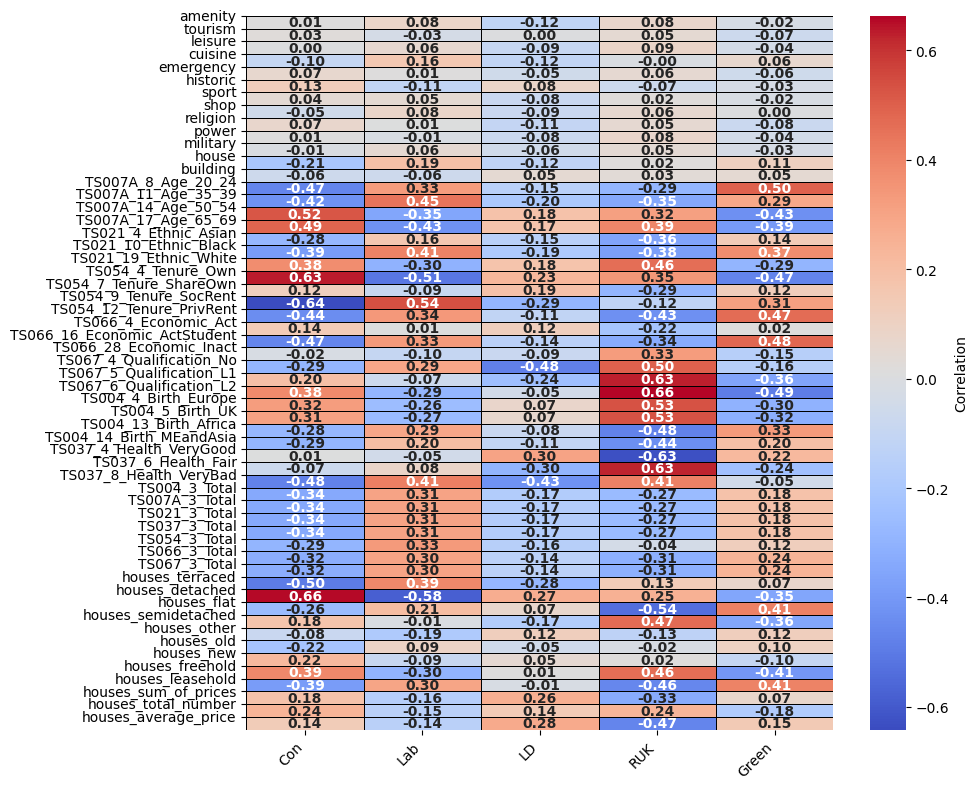

In [261]:
fynesse.assess.plot_correlation_between_dataframes(merged_data[feature_columns], merged_data[results_columns])

Observations:
- Selected census variables typically have high correlations with at least 2 result parameters;
- House price features has high correlation with Reform UK votes, other result parameters are often also correlated;
- Most of OSM features show low correlations with all result parameters.

#### Mutual information

Let's calculate mutual information between each feature and each voting variable. 

This metric measures non-linear dependencies. Features that have abnormally low mutual information with voting metrics might be useless for prediction.

In [262]:
mutual_info_scores = {}
for col in results_columns:
    mi = mutual_info_regression(merged_data[feature_columns], merged_data[col])
    mutual_info_scores[col] = mi

mutual_info_df = pd.DataFrame({
    col: scores for col, scores in mutual_info_scores.items()
}, index=feature_columns)

mutual_info_df['Min'] = mutual_info_df.min(axis=1)
mutual_info_df['Mean'] = mutual_info_df.mean(axis=1)
mutual_info_df['Max'] = mutual_info_df.max(axis=1)

print(mutual_info_df[['Min', 'Mean', 'Max']])

                                   Min      Mean       Max
amenity                       0.000000  0.002883  0.013924
tourism                       0.000000  0.011474  0.039952
leisure                       0.000000  0.012814  0.041469
cuisine                       0.000000  0.019618  0.060825
emergency                     0.000000  0.020248  0.051680
historic                      0.000000  0.010411  0.026475
sport                         0.000000  0.026235  0.077781
shop                          0.000000  0.000000  0.000000
religion                      0.000000  0.017608  0.054315
power                         0.000000  0.001211  0.007269
military                      0.000000  0.002334  0.009345
house                         0.000000  0.025991  0.050425
building                      0.000000  0.014952  0.031736
TS007A_8_Age_20_24            0.100519  0.164322  0.260374
TS007A_11_Age_35_39           0.000000  0.092405  0.167151
TS007A_14_Age_50_54           0.026556  0.096678  0.1932

Observations:
- Census features share a lot of information with voting outcomes;
- House price data - depends on metric - detached, freehold, average price are quite informative, while total_number, other, new are uninformative;
- OSM features - very uninformative, avg doesn't exceed 0.03.

#### Feature importance using random forest

Using simple models like Random Forests helps to estimate feature importance.

In [266]:
x = merged_data[feature_columns]
y = merged_data[results_columns]

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x, y)

feature_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

                         Feature  Importance
22        TS054_9_Tenure_SocRent    0.172078
45               houses_detached    0.089235
53          houses_sum_of_prices    0.065442
55          houses_average_price    0.064926
36        TS037_8_Health_VeryBad    0.055914
29      TS067_6_Qualification_L2    0.051347
27      TS067_4_Qualification_No    0.035772
18         TS021_10_Ethnic_Black    0.031635
20            TS054_4_Tenure_Own    0.027994
47           houses_semidetached    0.022314
16           TS007A_17_Age_65_69    0.021333
25  TS066_16_Economic_ActStudent    0.017179
28      TS067_5_Qualification_L1    0.016045
48                  houses_other    0.015456
46                   houses_flat    0.014874
44               houses_terraced    0.014694
17          TS021_4_Ethnic_Asian    0.013520
21       TS054_7_Tenure_ShareOwn    0.013301
13            TS007A_8_Age_20_24    0.012529
14           TS007A_11_Age_35_39    0.012109
23      TS054_12_Tenure_PrivRent    0.012037
52        

Observations:
- features of different kinds are present in the top and in the middle of the table;
- bottom part of the table is filled with some OSM features - these features are candidates for deletion.

#### Deleting features

From census-total features, we will delete all except for 054 and 066 due to features just repeating each other.

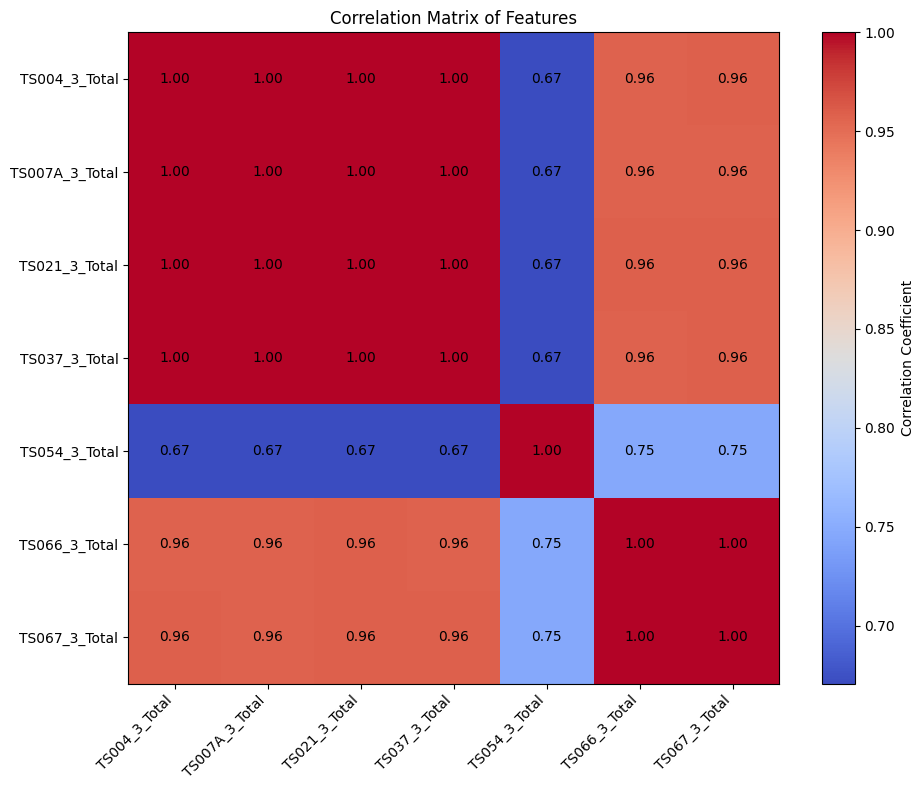

In [285]:
fynesse.assess.plot_correlation_matrix(merged_data[[el for el in census_columns if el.endswith('_3_Total')]], [])

We will delete the features that satisfy all of the following conditions:
- Correlations with voting columns don't exceed 0.20;
- Mutual info with every voting columns doesn't exceed 0.025;
- Feature importance is less that 0.01.

Observations:
- OSM features turned out to have quite weak connection with voting results.

In [286]:
to_be_deleted = ['amenity', 'cuisine', 'shop', 'religion', 'tourism', 'leisure', 'emergency', 'historic', 'power', 'military'] + ['TS067_3_Total', 'TS004_3_Total', 'TS007A_3_Total', 'TS021_3_Total', 'TS037_3_Total']
osm_columns = ['sport', 'house', 'building']
feature_columns = osm_columns + census_columns + prices_columns

In [287]:
merged_data.drop(columns=to_be_deleted)

,ONS_ID,BNG_E,BNG_N,LAT,LON,AREA,sport,house,building,TS007A_8_Age_20_24,...,Majority,Con,Lab,LD,RUK,Green,All_other_candidates,Of_which_other_winner,demographic_clusters,results_clusters
0,W07000081,279908.0,190202.0,51.597798,-3.735252,2.416996e+08,0.000000,0.298198,1110,0.052301,...,10354,0.081191,0.498895,0.025619,0.209313,0.030597,801,0,0,3
1,E14001063,486019.0,154644.0,51.284444,-0.767958,5.666349e+07,0.001128,0.561245,4433,0.056045,...,5683,0.290067,0.407136,0.083471,0.169125,0.044393,282,0,2,0
2,E14001064,404904.0,301132.0,52.607960,-1.929008,5.375720e+07,0.000579,0.075039,5184,0.048863,...,4294,0.388663,0.283706,0.042897,0.242056,0.042677,0,0,0,0
3,E14001065,377431.0,389086.0,53.398125,-2.340880,5.161294e+07,0.016760,0.089385,179,0.038901,...,4174,0.323097,0.404221,0.091872,0.096420,0.071892,643,0,2,0
4,W07000082,329358.0,366652.0,53.192241,-3.058789,1.852623e+08,0.000000,0.099644,562,0.048770,...,8794,0.181877,0.423926,0.047589,0.221262,0.044386,1575,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,E14001602,381171.0,389291.0,53.400111,-2.284657,3.656246e+07,0.000000,0.000000,186,0.050195,...,14610,0.137790,0.526321,0.050726,0.152969,0.105617,1040,0,1,3
571,E14001603,346849.0,113988.0,50.922798,-2.757500,3.355483e+08,0.000718,0.000478,4181,0.048730,...,12268,0.234863,0.061325,0.485476,0.156827,0.049089,608,0,0,2
572,W07000112,241151.0,379462.0,53.288137,-4.384530,7.151540e+08,0.000000,0.384172,4511,0.044315,...,637,0.305045,0.233511,0.013455,0.098780,0.018512,200,0,0,0
573,E14001604,459764.0,451706.0,53.958013,-1.090681,3.537431e+07,0.001314,0.453679,3044,0.145931,...,19154,0.124253,0.566374,0.070424,0.108972,0.119682,446,0,1,1


### Cluster analysis

#### Scaling data

It is necessary to scale the data before trying to cluster it. This is due to the fact that features with significantly different diapasons (e.g. dozens vs millions) will make distnace computation methods used during k-means clustering identify clusters that does not necessarily allign with common sense.

In [288]:
demographic_data_scaled = StandardScaler().fit_transform(merged_data[feature_columns])
results_data_scaled = StandardScaler().fit_transform(merged_data[results_columns])

#### Fine-tuning the clustering

We will use Elbow method to identify the optimal value of k from the plot of distortion - metric that measures the compactness of clusters. Optimal k lies in the "elbow" - fragment of plot where line goes down and then becomes more horizontal.

There is also mean Silhouette score plotted on the right - it measures how well datapoints are fit to clusters.

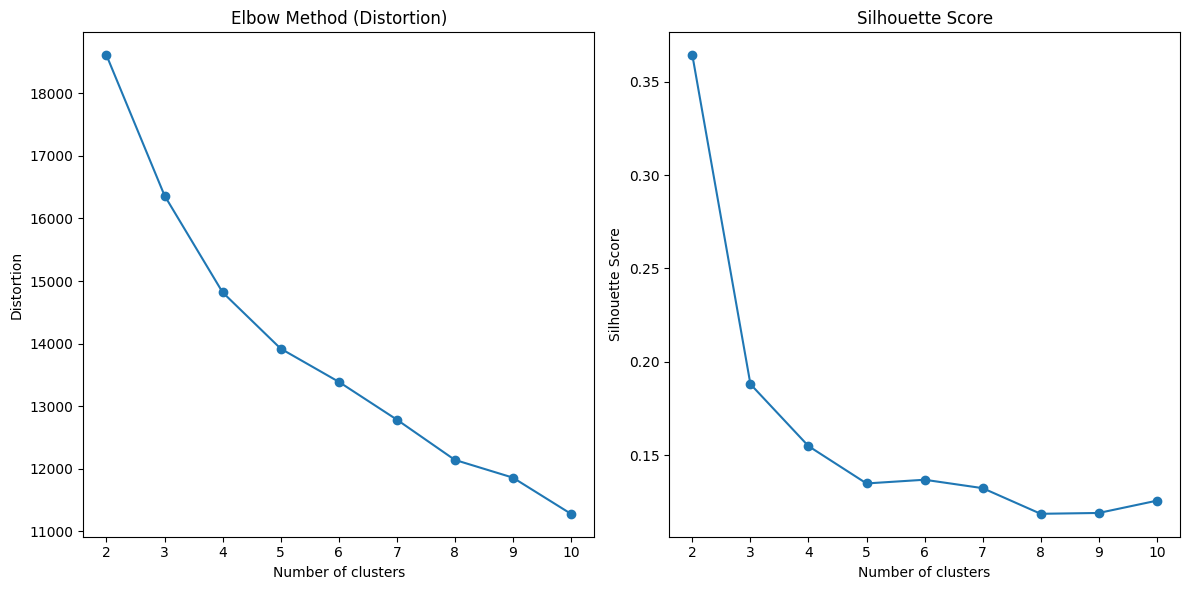

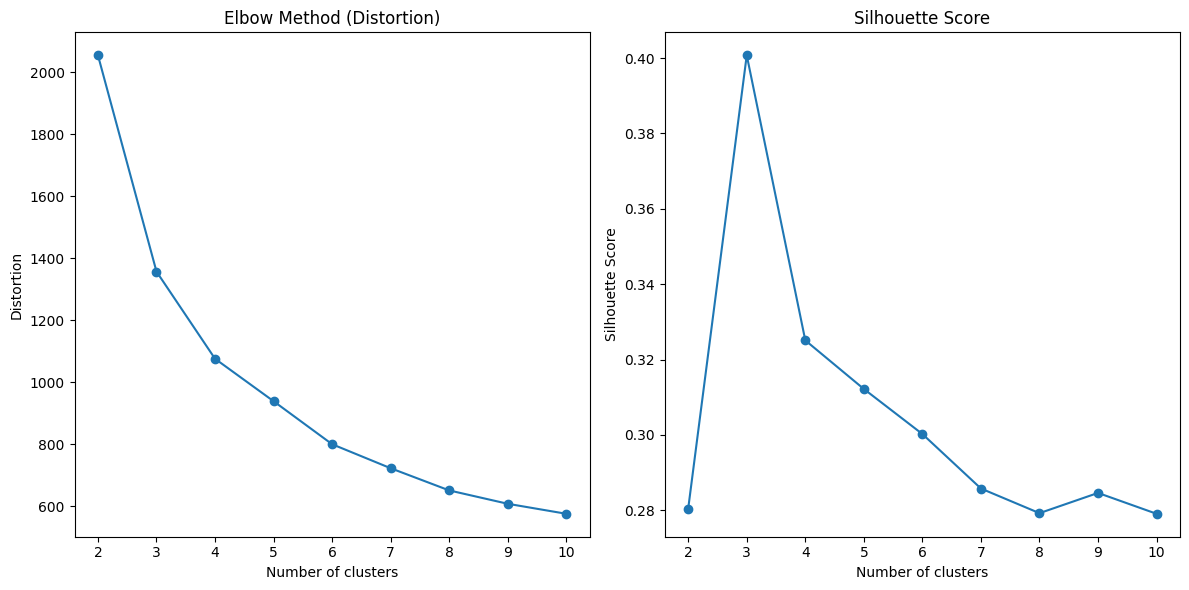

In [289]:
fynesse.assess.elbow_method(demographic_data_scaled)
fynesse.assess.elbow_method(results_data_scaled)

Let's stick to 4 clusters for both features and results - there are no significant elbows on the plots and there are insignificant elbows at n = 4 on both plots, so it's a good value to pick.

There are also no significant jumps in Silhouette score (which has to be minimised) at n = 4, which further proves that n = 4 is a good value to stick to.

In [290]:
n_clusters = 4

#### Clustering itself

Now let's perform clustering - just a reminder that we are going to do it separately for feature data and for results data.

In [291]:
merged_data['demographic_clusters'] = fynesse.assess.kmeans_clusters(demographic_data_scaled, n_clusters)
print(f"Demographic cluster sizes: {Counter(merged_data['demographic_clusters'])}")

merged_data['results_clusters'] = fynesse.assess.kmeans_clusters(results_data_scaled, n_clusters)
print(f"Result cluster sizes: {Counter(merged_data['results_clusters'])}")

Demographic cluster sizes: Counter({0: 234, 2: 172, 3: 104, 1: 65})
Result cluster sizes: Counter({0: 247, 3: 158, 1: 89, 2: 81})


While clusters contain different number of elements, there are no anomalitites such as almost empty cluster. In fact, difference between sizes of largest and smallest clusters is less than by 4 times for both.

#### Meaning of clusters

Let's gain some insight into what belonging to certain demographic cluster actually mean. We will do this by fitting a tree to feature and cluster data.

In [292]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(merged_data[feature_columns], merged_data['demographic_clusters'])
tree_rules = export_text(tree, feature_names=feature_columns)
print("Decision tree rules for demographic clusters based on feature columns: ")
print(tree_rules)

Decision tree rules for demographic clusters based on feature columns: 
|--- TS037_6_Health_Fair <= 0.13
|   |--- TS054_4_Tenure_Own <= 0.61
|   |   |--- houses_flat <= 0.34
|   |   |   |--- class: 3
|   |   |--- houses_flat >  0.34
|   |   |   |--- class: 1
|   |--- TS054_4_Tenure_Own >  0.61
|   |   |--- TS037_6_Health_Fair <= 0.13
|   |   |   |--- class: 2
|   |   |--- TS037_6_Health_Fair >  0.13
|   |   |   |--- class: 0
|--- TS037_6_Health_Fair >  0.13
|   |--- TS004_5_Birth_UK <= 0.87
|   |   |--- TS007A_14_Age_50_54 <= 0.07
|   |   |   |--- class: 3
|   |   |--- TS007A_14_Age_50_54 >  0.07
|   |   |   |--- class: 0
|   |--- TS004_5_Birth_UK >  0.87
|   |   |--- TS021_19_Ethnic_White <= 0.79
|   |   |   |--- class: 3
|   |   |--- TS021_19_Ethnic_White >  0.79
|   |   |   |--- class: 0



Interpretation:
- Dem class 0 - contains PCs with:
  - fairly good health situation, less than 87% are UK-born and lots of 50-54 aged people
  - OR fairly good health situation, more than 87% are UK-born and more than 79% are white
- Dem class 1 - contains PCs with:
  - not very good health situation, where owning a property is not a usual thing and where there are many flats
- Dem class 2 - contains PCs with:
  - not very good health situation, where owning a property is a usual thing
- Dem class 3 - contains remaining PCs:
  - bad health, ownership is not something usual, less flats
  - OR good health, less than 87% UK-born, not many people of the age 50-54
  - OR good health, more than 87% UK-born, less than 79% white.

Please keep in mind that these interpretations are just the likeliest, and hence are purely provisional.

Now let's do the same for voting clusters.

In [293]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(merged_data[results_columns], merged_data['results_clusters'])
tree_rules = export_text(tree, feature_names=results_columns)
print("Decision tree rules for result clusters based on result columns: ")
print(tree_rules)

Decision tree rules for result clusters based on result columns: 
|--- Con <= 0.24
|   |--- RUK <= 0.12
|   |   |--- Lab <= 0.25
|   |   |   |--- class: 2
|   |   |--- Lab >  0.25
|   |   |   |--- class: 1
|   |--- RUK >  0.12
|   |   |--- Green <= 0.13
|   |   |   |--- class: 3
|   |   |--- Green >  0.13
|   |   |   |--- class: 1
|--- Con >  0.24
|   |--- LD <= 0.25
|   |   |--- Con <= 0.27
|   |   |   |--- class: 0
|   |   |--- Con >  0.27
|   |   |   |--- class: 0
|   |--- LD >  0.25
|   |   |--- class: 2



Interpretation:
- Vot class 0 - more than quarter for Con, less than quarter for LibDem;
- Vot class 1 - less than quarter for Con, then either less than 1/8 for Reform and more than quarter for Lab or more than 1/8 for Reform and for Green;
- Vot class 2 - either less han quarter for Con and Lab, less than 1/8 for Reform or more than quarter for Con and LibDem;
- Vot class 3 - less than quarter for Con, more than 1/8 for Reform, less than 1/8 for Green.

#### Relationships between clusters

It would be interesting to explore the meaning of result clusters in terms of features. In order to do this, we will fit decision tree to result clusters in the following way.

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(merged_data[feature_columns], merged_data['results_clusters'])
tree_rules = export_text(tree, feature_names=feature_columns)
print("Decision tree rules for result clusters based on feature columns: ")
print(tree_rules)

This output has been changed deliberately for ethical purposes:

```
Decision tree rules for result clusters based on feature columns: 
|--- TS054_9_Tenure_SocRent <= 0.17
|   |--- TS037_8_Health_VeryBad <= 0.01
|   |   |--- class: 2
|   |--- TS037_8_Health_VeryBad >  0.01
|   |   |--- TS054_7_Tenure_ShareOwn <= 0.00
|   |   |   |--- class: 3
|   |   |--- TS054_7_Tenure_ShareOwn >  0.00
|   |   |   |--- class: 0
|--- TS054_9_Tenure_SocRent >  0.17
|   |--- TS067_6_Qualification_L2 <= 0.11
|   |   |--- houses_sum_of_prices <= 5079589888.00
|   |   |   |--- class: 1
|   |   |--- houses_sum_of_prices >  5079589888.00
|   |   |   |--- class: 0
|   |--- TS067_6_Qualification_L2 >  0.11
|   |   |--- houses_average_price <= 251344.50
|   |   |   |--- class: 3
|   |   |--- houses_average_price >  251344.50
|   |   |   |--- class: 3
```

Now we can say which demographic factors are likely to put region into certain voting cluster:
- Vot class 1 - lots of social renting, not much qualification, cheap houses - this matches the description of this class as anti-Tory and either pro-Labour or pro-Reform;
- Vot class 2 - less social renting, no serious health issues - matches the description of this class as pro-conservative, pro-liberal or equally pro-everyone;
- Vot class 0 - less social renting, bad health or more social renting, less qualifications but expensive housing - this has to be associated with strongly pro-conservative voting class;
- Vot class 3 - more social renting and more qualifications - this class is pro-Reform.

As we can see, in most of the cases two description match each other (or at least it's obvious that they are related).

Let's now explore how clusters for features and clusters for results are related with each other numerically.

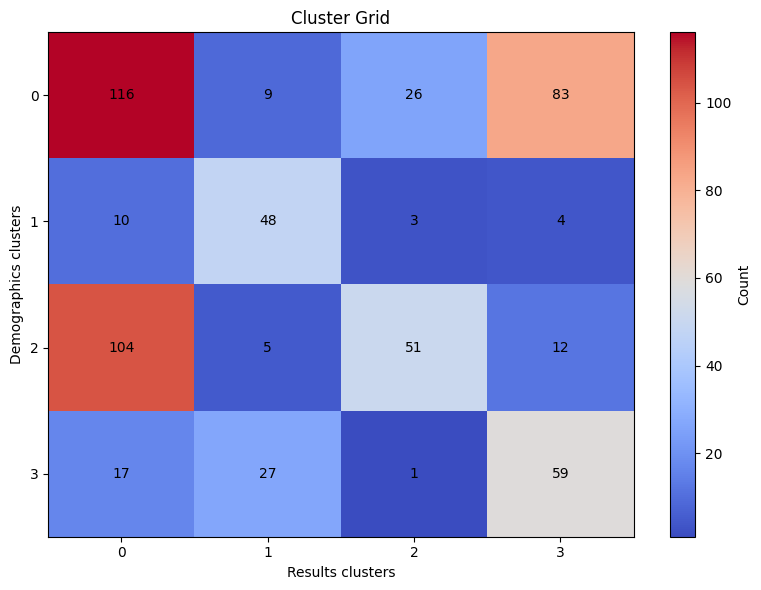

In [295]:
grid = merged_data[['demographic_clusters', 'results_clusters']].groupby(
        ['demographic_clusters', 'results_clusters']
    ).size().reset_index(
        name='count'
    ).pivot_table(
        index='demographic_clusters', 
        columns='results_clusters', 
        values='count', 
        aggfunc='sum', 
        fill_value=0
    )

fynesse.assess.plot_cluster_matrix(grid, "Results clusters", "Demographics clusters")

When analysing picture above, it's easy to see that demographic and results clusters are strongly correlated.

More than 50% of all PCs are in top 3 of 16 cells, while bottom 8 of 16 cells contain only 15% of all PCs.

Such properties confirm that tendencies which we are looking for exist and are quite strong. There is a high chance that PCs lying in unpopular cells will be outliers that we are looking for.

Analysis per voting class:
- Vot class 0 - is strongly pro-conservative, covers about 50% of all PCs, has two strongly preffered demographical profiles;
- Vot class 1 - pro-Lab, pro-Reform or pro-Green, mainly covers demographical profiles opposed to those covered by Vot class 0;
- Vot class 2 - pro-Con, pro-Lib or pro-everyone - mainly covers two demographical profiles;
- Vot class 3 - pro-Reform - also has two preffered demographic profiles.

#### Plotting on UK map

We can now visualise the data by running the following code.

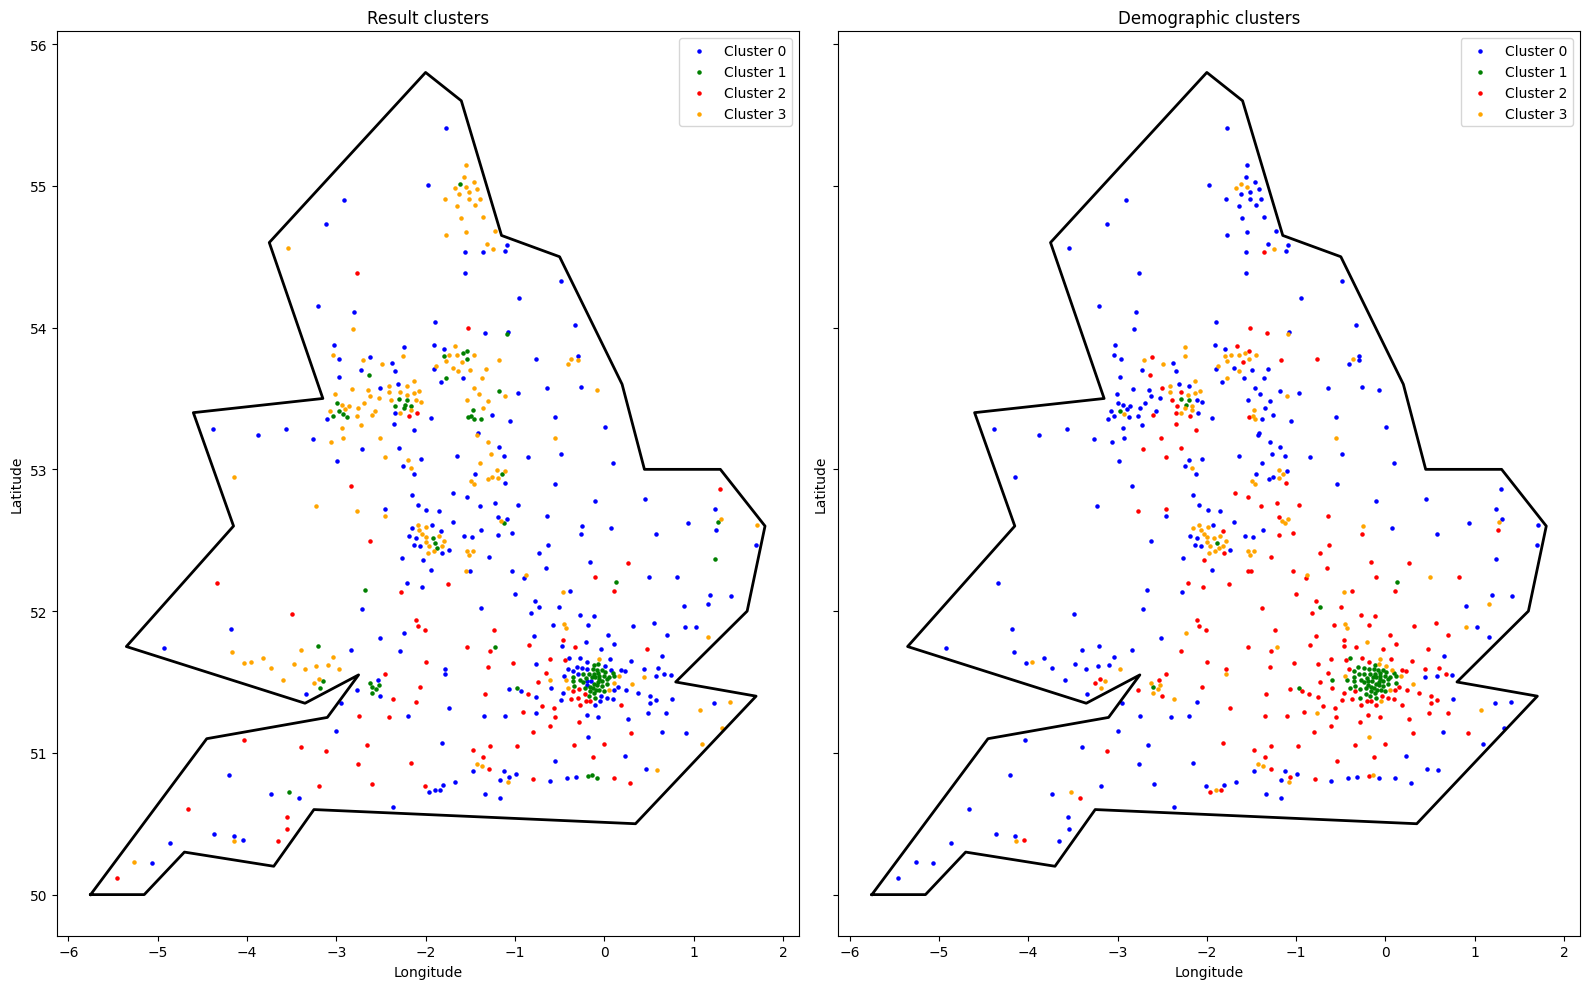

In [304]:
uk_boundary_coords = fynesse.assess.get_ew_boundary_polygon()
uk_boundary_latitudes = [coord[1] for coord in uk_boundary_coords]
uk_boundary_longitudes = [coord[0] for coord in uk_boundary_coords]

cluster_pairs = [(0, 0), (1, 1), (2, 2), (3, 3)] # (demographic_cluster, result_cluster)
colors = ['blue', 'green', 'red', 'orange']

fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharex=True, sharey=True)

axes[0].plot(uk_boundary_longitudes, uk_boundary_latitudes, color='black', lw=2)
for dem_cluster, res_cluster in cluster_pairs:
    subset = merged_data.loc[np.where(merged_data['results_clusters'] == res_cluster)[0]]
    axes[0].scatter(subset['LON'], subset['LAT'], label=f'Cluster {res_cluster}', color=colors[cluster_pairs.index((dem_cluster, res_cluster))], s=5)
axes[0].set_title('Result clusters')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()

axes[1].plot(uk_boundary_longitudes, uk_boundary_latitudes, color='black', lw=2)
for dem_cluster, res_cluster in cluster_pairs:
    subset = merged_data.loc[np.where(merged_data['demographic_clusters'] == dem_cluster)[0]]
    axes[1].scatter(subset['LON'], subset['LAT'], label=f'Cluster {dem_cluster}', color=colors[cluster_pairs.index((dem_cluster, res_cluster))], s=5)
axes[1].set_title('Demographic clusters')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].legend()

plt.tight_layout()
plt.show()

Analysis:
- From the plot we can say that clusters 1 (green) are typical for highly urbanised areas;
- Clusters 3 (yellow) seem to cover cities outside of London and big towns;
- Demographic cluster 2 (red) looks like it can be linked to results cluster 0 (blue) - both dominate in smaller cities of England without North;
- Demographic cluster 0 (blue) seems to be typical for more rural areas.


#### Numerical analysis

Comparing clusters with voting patterns by grouping by demographic clusters and calculating the average voting distribution.

In [305]:
merged_data.groupby('demographic_clusters')[results_columns].mean()

,Con,Lab,LD,RUK,Green
demographic_clusters,,,,,
0,0.255668,0.351385,0.101904,0.193554,0.058259
1,0.157322,0.470314,0.097265,0.067190,0.125888
2,0.312607,0.277048,0.185013,0.145086,0.058329
3,0.176727,0.420522,0.065452,0.146129,0.096828


Most of the description we've provided before (except, probably, the description for cluster 0) seem to be quite accurate.

Comparing clusters with voting patterns by grouping by result clusters and calculating the average voting distribution.

In [278]:
merged_data.groupby('results_clusters')[results_columns].mean()

,Con,Lab,LD,RUK,Green
results_clusters,,,,,
0,0.326188,0.337279,0.081192,0.170241,0.057616
1,0.119372,0.480012,0.075495,0.067693,0.157935
2,0.297390,0.107896,0.415920,0.115659,0.044720
3,0.170373,0.439320,0.052747,0.204865,0.063344


Let's take these original interpretations and let's correct them:
- Vot class 0 - more than quarter for Con, less than quarter for LibDem - accurate;
- Vot class 1 - less than quarter for Con, then either less than 1/8 for Reform and more than quarter for Lab or more than 1/8 for Reform and for Green - first case of 'either' was probably dominant;
- Vot class 2 - either less than quarter for Con and Lab, less than 1/8 for Reform or more than quarter for Con and LibDem - boils down to the second case of 'either';
- Vot class 3 - less than quarter for Con, more than 1/8 for Reform, less than 1/8 for Green - accurate.

### Summary on Assess

During Assess stage we prepared all needed data that we will be working with, translated it to 'per PS' format, conducted feature analysis which resulted in some features being thrown away from features set and then we used clustering to detect clusters of similar demographic and voting profiles, to compare them with each other and to identify links between demographic features and voting outcomes.

Final view of the database can be obtained by running `fynesse.access.get_summary_on_db(conn)` and is given below. 

In [ ]:
"""
Table census_data_1 - Approx Row Count 0.1M
('date', 'geography', 'geography_code', 'NSSEC_Total', 'NSSEC_L1_L2_L3', 'NSSEC_L4_L5_L6', 'NSSEC_L7', 'NSSEC_L8_L9', 'NSSEC_L10_L11', 'NSSEC_L12', 'NSSEC_L13', 'NSSEC_L14', 'NSSEC_L15', 'db_id', 'MI_Total', 'MI_AddrYearAgoSameInUK', 'MI_AddrYearAgoStudentInUK', 'MI_AddrYearAgoInUK', 'MI_AddrYearAgoOutUK', 'amenity_nearby', 'tourism_nearby', 'leisure_nearby', 'cuisine_nearby', 'emergency_nearby', 'historic_nearby', 'sport_nearby', 'shop_nearby', 'religion_nearby', 'power_nearby', 'military_nearby', 'house_nearby', 'building_nearby', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'NSSEC_L15_Norm', 'MI_AddrYearAgoOutUK_Norm')
(2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012578616, 0.068571428)
(2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09009009, 0.019841269)
(2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.038834951, 0.017699115)
Indices:
 - idx_geography (BTREE): Column geography
 - idx_geography_code (BTREE): Column geography_code

Table ge_2024_results - Approx Row Count 0.0M
('ONS_ID', 'ONS_region_ID', 'Constituency_name', 'County_name', 'Region_name', 'Country_name', 'Constituency_type', 'Declaration_time', 'Member_first_name', 'Member_surname', 'Member_gender', 'Result', 'First_party', 'Second_party', 'Electorate', 'Valid_votes', 'Invalid_votes', 'Majority', 'Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All_other_candidates', 'Of_which_other_winner', 'db_id')
('W07000081', 'W92000004', 'Aberafan Maesteg', '', 'Wales', 'Wales', 'County', '', 'Stephen', 'Kinnock', 'Male', 'Lab hold', 'Lab', 'RUK', 72580, 35755, 79, 10354, 2903, 17838, 916, 7484, 1094, 0, 4719, 0, 0, 0, 0, 0, 801, 0, 1)
('E14001063', 'E12000008', 'Aldershot', '', 'South East', 'England', 'Borough', '', 'Alex', 'Baker', 'Female', 'Lab gain from Con', 'Lab', 'Con', 78553, 48544, 179, 5683, 14081, 19764, 4052, 8210, 2155, 0, 0, 0, 0, 0, 0, 0, 282, 0, 6)
('E14001064', 'E12000005', 'Aldridge-Brownhills', '', 'West Midlands', 'England', 'Borough', '', 'Wendy', 'Morton', 'Female', 'Con hold', 'Con', 'Lab', 70268, 40912, 156, 4294, 15901, 11607, 1755, 9903, 1746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_ons_id (BTREE): Column ONS_ID
 - idx_ons_region_id (BTREE): Column ONS_region_ID
 - idx_result (BTREE): Column Result
 - idx_first_party (BTREE): Column First_party
 - idx_second_party (BTREE): Column Second_party

Table oa_data - Approx Row Count 0.1M
('FID', 'OA21CD', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'ShapeArea', 'ShapeLength', 'GlobalID', 'db_id', 'geometry_string_ne', 'geometry')
(1, 'E00000001', 'E01000001', 'City of London 001A', ' ', 532250, 181864, 51.5202, -0.09523, 6949.15, 421.166, '3a44dd3d-5082-4a09-9b9c-3a5fadc811ed\r', 1, 'POLYGON ((532303.4919999996 181814.1099999994, 532213.3779999996 181846.1919999998, 532194.8990000002 181874.26300000027, 532162.9718000004 181864.00879999995, 532162.4910000004 181867.76300000027, 532248.3943999996 181895.3501999993, 532282.6299999999 181906.49599999934, 532308.875 181914.79700000025, 532303.4919999996 181814.1099999994))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A Zd\xfb\x84= A\x80\xbe\x9f\x1a^3\x06A\xf8\xcb\xee\xc90> A@\xa85\xcd:4\x06A(\\\x8fBu> A\x00\xd9\xce\xf7\x934\x06A\x00\x00\x00\xc0\xa9> A@\x89A`\xd64\x06A\x88l\xe7\xfb\x9e> A\x00\xaeG\xe1\xb01\x06A')
(2, 'E00000003', 'E01000001', 'City of London 001A', ' ', 532171, 181819, 51.5198, -0.09638, 4492.41, 307.715, 'f1216dc8-14d1-4857-9230-cab0641758fb\r', 2, 'POLYGON ((532213.3779999996 181846.1919999998, 532190.5392000005 181796.06120000035, 532180.131 181763.01999999955, 532155.909 181805.6799999997, 532127.2989999996 181800.62399999984, 532162.9718000004 181864.00879999995, 532194.8990000002 181874.26300000027, 532213.3779999996 181846.1919999998))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00H7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A\xc0\x05\x12\x14\xbd= A\x00mV} 1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\x08\xc5\x8f\xf1\x85= A\x00\xbc\x05\x12@3\x06A`\xbaI\xcc\xc5= A\x80\xbe\x9f\x1a\x923\x06AH7\x89\xc1\xea= A\xc0K7\x89\xb12\x06A')
(3, 'E00000005', 'E01000001', 'City of London 001A', ' ', 532166, 181722, 51.519, -0.09649, 8565.51, 385.205, '44d6f70f-549c-4288-9b6d-de2adbf02582\r', 3, 'POLYGON ((532180.131 181763.01999999955, 532219.1610000003 181703.9389999993, 532201.2920000004 181668.1799999997, 532124.3210000005 181682.67500000075, 532127.2989999996 181800.62399999984, 532155.909 181805.6799999997, 532180.131 181763.01999999955))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A\x90\x97nR\xf6= A\x80n\x12\x83?.\x06A(\x06\x81\x95\xd2= A\x00\xd7\xa3p!-\x06A\xb0\x1cZ\xa48= A\x80fff\x95-\x06A(\x87\x16\x99>= A@\xb6\xf3\xfdD1\x06A\xb0rh\xd1w= A\x00\xd7\xa3pm1\x06A\x98n\x12C\xa8= A\x80\xc2\xf5(\x180\x06A')
Indices:
 - PRIMARY (BTREE): Column FID
 - idx_oa (BTREE): Column OA21CD
 - idx_lsoa (BTREE): Column LSOA21CD
 - idx_lat_lon_btree (BTREE): Column LAT
 - idx_lat_lon_btree (BTREE): Column LON
 - geometry (SPATIAL): Column geometry

Table oa_to_pc - Approx Row Count 0.1M
('OA21CD', 'PCON25CD', 'PCON25NM', 'PCON25NMW', 'LAD21CD', 'LAD21NM', 'ObjectId', 'db_id')
('E00000337', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 1, 1)
('E00000338', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 2, 2)
('E00000340', 'E14001073', 'Barking', '', 'E09000002', 'Barking and Dagenham', 3, 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_oa21cd (BTREE): Column OA21CD
 - idx_pcon25cd (BTREE): Column PCON25CD
 - idx_lad21cd (BTREE): Column LAD21CD

Table osm_and_census_data_2 - Approx Row Count 0.1M
('date', 'OA21CD', 'db_id', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad', 'TS004_3_Total', 'TS007A_3_Total', 'TS021_3_Total', 'TS037_3_Total', 'TS054_3_Total', 'TS066_3_Total', 'TS067_3_Total')
(2021, 'E00000001', 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 15, 24, 5, 3, 155, 72, 0, 7, 15, 98, 0, 63, 4, 7, 10, 149, 118, 0, 6, 98, 26, 0, 176, 177, 176, 175, 94, 161, 160)
(2021, 'E00000003', 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 13, 20, 35, 24, 5, 209, 91, 0, 2, 17, 139, 1, 83, 5, 3, 8, 207, 184, 7, 18, 146, 15, 2, 257, 259, 255, 256, 111, 223, 221)
(2021, 'E00000005', 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 5, 8, 12, 13, 0, 85, 40, 0, 2, 21, 68, 1, 36, 3, 2, 3, 88, 73, 2, 11, 62, 8, 0, 111, 111, 112, 112, 63, 105, 106)
Indices:
 - PRIMARY (BTREE): Column OA21CD
 - idx_oa (BTREE): Column OA21CD

Table osm_data - Approx Row Count 2.3M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('way', 72499117, 'POLYGON ((-6.3134352 49.9146669, -6.3134663 49.9147353, -6.3134061 49.9147467, -6.3134095 49.9147542, -6.3131503 49.9148031, -6.3131469 49.9147957, -6.3130936 49.9148057, -6.3130624 49.9147373, -6.3134352 49.9146669))', '', '[860681919, 860681920, 9169387085, 9169387084, 9169387083, 9169387086, 860681921, 860681922, 860681919]', '', '', 'TR21 0JT', 'Church Street', '', 'Hugh Town', '', '', 'Isles of Scilly Museum', '', '', '', '', '', '', '', 'museum', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 1, 'POLYGON ((90458.76146576129 10530.59510146096, 90456.96838425193 10538.325346537269, 90461.36151221936 10539.34294224321, 90461.1656261129 10540.190514922826, 90480.0796803821 10544.551471966843, 90480.27621043124 10543.71501331353, 90484.16519925534 10544.605615865905, 90485.96549134556 10536.874967216398, 90458.76146576129 10530.59510146096))', b"\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@@|\x80~\x8f\x15\xf6@\xb8\x90\xf4\xa4)\x95\xc4@t\t\xc1\xc8\xd5\x15\xf6@\x80\x0b\x88\xe5\xab\x95\xc4@$\x91g\xa6\xd2\x15\xf6@x\x01\xcbb\x18\x96\xc4@\xb4\xef^F\x01\x17\xf6@ '\xa2\x96F\x98\xc4@\x10\xa1[k\x04\x17\xf6@\xe8f\x8e\x85\xdb\x97\xc4@p\xf9\xa7\xa4B\x17\xf6@\x00\x19\xd2\x84M\x98\xc4@\x9c\r\xa7r_\x17\xf6@\xc0\xfd\xec\xfeo\x94\xc4@\xdc\xb8\xf6.\xac\x15\xf6@P\xe0H,L\x91\xc4@", 'E00096405')
('way', 112445611, 'POLYGON ((-6.3084596 49.9166407, -6.308579 49.916719, -6.3085171 49.9167581, -6.3084892 49.9167398, -6.3085024 49.9167315, -6.3084109 49.9166715, -6.3084596 49.9166407))', '', '[9170680719, 1277992838, 9170680715, 9170680714, 9170680716, 1277992862, 9170680719]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Sailing Centre', '', '', '', '', '', '', '', '', '', 'boathouse', '', '', '', 'sailing', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 2, 'POLYGON ((90828.4609464347 10729.354209220925, 90820.39463746297 10738.549788717108, 90825.08695750969 10742.639007787584, 90826.97177186015 10740.489873598155, 90825.97139167401 10739.62207760218, 90832.15288637078 10732.575638220165, 90828.4609464347 10729.354209220925))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@T_oPF,\xf6@\xd8\x07z_F\xf9\xc4@\xc4\x8e-d\x91,\xf6@\xc8\xd6\x01\xcbQ\xfb\xc4@h\xa6`\x8c\xaf,\xf6@\xa0\x95-\xb4>\xfa\xc4@\xf8\xfe\xd1\x8a\x9f,\xf6@x&=\xa0\xcf\xf9\xc4@\xa8\xfa8r\x02-\xf6@\xf8`\x83\xaeI\xf6\xc4@d^\t`\xc7,\xf6@\xe8M\xbaV\xad\xf4\xc4@', 'E00096404')
('way', 112445629, 'POLYGON ((-6.3087257 49.9166066, -6.3085551 49.916498, -6.3086358 49.9164671, -6.3087896 49.9165649, -6.3087257 49.9166066))', '', '[1277992753, 9170680721, 1277992733, 1277992688, 1277992753]', '', '', 'TR21 0JY', '', '', 'Portmellon', '', '', 'The Beach', '', '', '', '', '', '', 'restaurant', '', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '', 3, 'POLYGON ((90809.14760272152 10726.665366668487, 90820.69383186748 10713.890660483463, 90814.70495984284 10710.790500333693, 90804.2950828856 10722.295490033372, 90809.14760272152 10726.665366668487))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@\xbcq\xef\x19K,\xf6@(\xa8)\x01\xf2\xec\xc4@\xe0\xf8\x83G\xeb+\xf6@Xl\x1d/e\xeb\xc4@\xf4\xd4\xa8\xb8D+\xf6@\xd0\x0e\x9e\xd2%\xf1\xc4@\xdc\xab\x94\\\x92+\xf6@\x80(\xbc*U\xf3\xc4@', 'E00096404')
Indices:
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - geometry (SPATIAL): Column geometry
 - idx_oa (BTREE): Column OA21CD

Table osm_data_sample - Approx Row Count 0.0M
('element_type', 'osmid', 'geometry_string_ll', 'ways', 'nodes', 'type', 'addr_country', 'addr_postcode', 'addr_street', 'addr_housenumber', 'addr_city', 'addr_housename', 'addr_place', 'name', 'alt_name', 'old_name', 'nohousenumber', 'note', 'disused', 'height', 'amenity', 'tourism', 'brand', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'building_material', 'building_levels', 'internet_access', 'capacity', 'roof_levels', 'roof_shapefee', 'man_made', 'denomination', 'layer', 'db_id', 'geometry_string_ne', 'geometry', 'OA21CD')
('relation', 1576004, 'POLYGON ((-5.3588132 50.137841, -5.3588119 50.1379062, -5.3588302 50.1379064, -5.3588303 50.137916, -5.3588298 50.1379271, -5.3591748 50.1379298, -5.3591737 50.1379875, -5.359063 50.1379867, -5.3588525 50.137985, -5.3587354 50.1379841, -5.3587345 50.1380317, -5.3582376 50.1380279, -5.3582395 50.1379277, -5.3582623 50.1379278, -5.3582655 50.1377577, -5.3583753 50.1377585, -5.3583746 50.137798, -5.3584518 50.1377986, -5.3586827 50.1378004, -5.358682 50.13784, -5.3587528 50.137841, -5.3588132 50.137841), (-5.3586324 50.1378861, -5.3586326 50.1378722, -5.3584124 50.1378714, -5.3584115 50.1379669, -5.358487 50.1379672, -5.3586316 50.1379678, -5.3586324 50.1378861))', '[112168276, 112168270]', '[[[1275780250, 1275780520, 6915654134, 6915654135, 6915654127, 1275780590, 1275780263, 1275780264, 6915654094, 6915654093, 1275780324, 1275780605, 1275780649, 1275780536, 1275780574, 1275780460, 1275780494, 1275780375, 11543332618, 1275780477, 1275780444, 1275780250], [1275780610, 6915616070, 1275780448, 1275780303, 1275780358, 6915616068, 1275780610]]]', 'multipolygon', '', 'TR13 9RE', '', '', 'Helston', 'Godolphin Estate', 'Godolphin Cross', 'Godolphin Count House', '', '', '', '', '', '', '', 'attraction', '', '', '', '', '', '', '', '', '', '', '', 'yes', '', '', '', '', '', '', '', '', '-2.0', 9231, 'POLYGON ((160086.16956965212 31822.472745400475, 160086.58895984557 31829.71596022285, 160085.2825716251 31829.79709322439, 160085.32350359295 31830.864516799717, 160085.4148126958 31832.09674381002, 160060.78083433688 31833.507368218503, 160061.1484081984 31839.917552823725, 160069.0530244006 31839.472289172612, 160084.08304005134 31838.605765294487, 160092.44438522015 31838.12882112735, 160092.74705420376 31843.416970515507, 160128.22749901644 31841.395378445304, 160127.5900522634 31830.263617495773, 160125.9616744297 31830.348106398684, 160124.88135450747 31811.4506942546, 160117.04099638914 31811.892977273732, 160117.2887921534 31816.28140370059, 160111.7764561905 31816.596549069625, 160095.28945915794 31817.539766504895, 160095.53777390122 31821.939308143687, 160090.48467634825 31822.278339675016, 160086.16956965212 31822.472745400475), (160099.31215739273 31826.90398117411, 160099.22826281504 31825.35955047325, 160114.95581193813 31824.561936467944, 160115.49830795583 31835.17447969984, 160110.10594067888 31835.450809407223, 160099.7784352009 31835.982886881276, 160099.31215739273 31826.90398117411))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\x16\x00\x00\x00rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@[\x940\xb6\xb4\x8a\x03A\x98\xd3J\xd2m\x15\xdf@\x85\xe9\xb4B\xaa\x8a\x03A\xa8L\x93\x03s\x15\xdf@?\r\x89\x96\xaa\x8a\x03AhE>T\xb7\x15\xdf@\x93Q\x89Q\xab\x8a\x03A\x08\xf3\x0c1\x06\x16\xdf@\xa4\x12&?\xe6\x89\x03A`\x8c\xb8x`\x16\xdf@5\xa3\xf0/\xe9\x89\x03A\x90z/\xb9\xfa\x17\xdf@\x94\x0e\x98l(\x8a\x03A\xa8]\xfc9\xde\x17\xdf@\x06\xe7\x10\xaa\xa0\x8a\x03A8\xcc\xdb\xc4\xa6\x17\xdf@\x9b\xd6\x19\x8e\xe3\x8a\x03A@\xf8\x9a>\x88\x17\xdf@\xec\x8d\xf7\xf9\xe5\x8a\x03A\xe0\x19\xa5\xaf\xda\x18\xdf@\x1c\x01\xeb\xd1\x01\x8c\x03A\x08e\xe1MY\x18\xdf@2Rm\xb8\xfc\x8b\x03A\xc0\xea\x1b\xdf\x90\x15\xdf@\x08]\x82\xb1\xef\x8b\x03Ax\x0f`G\x96\x15\xdf@\x8e\x97\x03\r\xe7\x8b\x03A\x00\xb7,\xd8\xdc\x10\xdf@5\xea\xf5S\xa8\x8b\x03A\xb0&\x8a&\xf9\x10\xdf@\xb2BrO\xaa\x8b\x03A\xc0\xaa\x84\x02\x12\x12\xdf@\xc8\xa9.6~\x8b\x03A &\xdc-&\x12\xdf@\x87\xf6\xcfP\xfa\x8a\x03A\x80\xcf\x88\x8bb\x12\xdf@3g\\M\xfc\x8a\x03A\x80\xe7\x9f\x1d|\x13\xdf@G\xfe\x9d\xe0\xd3\x8a\x03AX6Q\xd0\x91\x13\xdf@rUG[\xb1\x8a\x03A\x98\xecuA\x9e\x13\xdf@\x07\x00\x00\x00\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@lt{\xd3\x19\x8b\x03A\xf8\xfc\xdf\x02W\x14\xdf@\xbb\xba\x80\xa5\x97\x8b\x03A\x10`\xc4\xf6#\x14\xdf@\xad\xe1\x88\xfc\x9b\x8b\x03A(\xe7\xac*\xcb\x16\xdf@9m\xf7\xd8p\x8b\x03A0\xb3\x0f\xda\xdc\x16\xdf@\x0f<<:\x1e\x8b\x03A\xb0`\x9e\xe7\xfe\x16\xdf@\x08`L\x7f\x1a\x8b\x03A\xc0\xda\xd3\xda\xb9\x14\xdf@', 'E00095232')
('relation', 6272289, 'POLYGON ((-5.2770057 50.2289954, -5.2770251 50.2290046, -5.2769484 50.2290713, -5.2769275 50.2290614, -5.2767873 50.2291834, -5.276366 50.2289853, -5.2764183 50.2289398, -5.27672 50.2286772, -5.2771429 50.228876, -5.2770057 50.2289954), (-5.2767544 50.2288051, -5.2765608 50.2289686, -5.2767531 50.2290618, -5.2769468 50.2288983, -5.2767544 50.2288051))', '[143400736, 421970682]', '[[[1569200506, 4217005352, 4217005353, 4217005358, 4217005356, 1569200517, 1569200508, 5475247462, 1569200481, 1569200506], [4217005349, 4217005348, 4217005350, 4217005357, 4217005349]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'Trevithick Court', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '1.0', '', '', '', '', '', '', '', 9232, 'POLYGON ((166376.37276804046 41694.974749416986, 166375.0344211005 41696.05829827403, 166380.82997802846 41703.231912765885, 166382.27185992844 41702.06584648584, 166392.86590993474 41715.187303649174, 166421.93846893095 41691.84465051026, 166417.986551931 41686.95100738492, 166395.1886003087 41658.70729205961, 166366.0052828661 41682.132921668206, 166376.37276804046 41694.974749416986), (166393.36129452076 41673.0325111158, 166407.96616721348 41690.59953518893, 166394.70974411705 41701.56301420703, 166380.09772006687 41683.99633974003, 166393.36129452076 41673.0325111158))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x02\x00\x00\x00\n\x00\x00\x00v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\xe8\x91~F8O\x04A\x8cW\x94\xdd\x01\\\xe4@E\x85\xcb\xa3fO\x04A R\xd4k\xe7\\\xe4@\xee\xe5\xc4,rO\x04A\xe8\x16j\x1b\xc2\\\xe4@\x180b\xed\xc6O\x04A\xf48d\xfee^\xe4@\xb6\xff\xfb\x81\xafP\x04A\xc4\x81`\x07{[\xe4@\xbcVu\xe4\x8fP\x04A\x10\n\xa7n\xdeZ\xe4@\xef\xe0@\x82\xd9O\x04A\x18\xf5"\xa2VW\xe4@I\xbe\xd1\n\xf0N\x04A<\xf1\xe4@DZ\xe4@v\xcfm\xfbBO\x04Ax\xb0%1\xdf[\xe4@\x05\x00\x00\x00\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@C\xe0\xb5\xba?P\x04A\xa8kd/S[\xe4@\xdaR\x8e\xad\xd5O\x04A\xcc^6\x04\xb2\\\xe4@[u!\xc8`O\x04A\xe4\xe0\x03\xe2\x7fZ\xe4@\xb7a\xee\xe3\xcaO\x04Ad\xc0T\n!Y\xe4@', 'E00182758')
('relation', 7012772, 'POLYGON ((-5.2737421 50.2274724, -5.2735134 50.2275462, -5.2735414 50.2275817, -5.2735731 50.2276211, -5.2734847 50.2276494, -5.2734453 50.2276006, -5.2733934 50.2276178, -5.2732982 50.2274979, -5.273668 50.2273785, -5.2737421 50.2274724))', '[143400690]', '[[[1569200022, 1569200044, 5429909876, 1569200108, 1569200129, 5472660274, 5472660273, 1569200023, 1569199906, 1569200022]]]', 'multipolygon', '', 'TR15 3RD', 'Trevenson Road', '', 'Redruth', '', '', 'dBs', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'college', '', '2.0', '', '', '', '', '', '', '', 9233, 'POLYGON ((166601.6469998361 41515.44198465673, 166618.31610309827 41522.928540665045, 166616.49293302154 41526.96247665322, 166614.42498174557 41531.441534391284, 166620.86700770017 41534.310207305214, 166623.43810670276 41528.76211560643, 166627.22310428528 41530.51135377839, 166633.42582582674 41516.8849150138, 166606.4721160039 41504.77180834714, 166601.6469998361 41515.44198465673))', b'\x00\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@\xaa\x0fa\x87\xd2V\x04A\xac\xe9\x9a\xb6]F\xe4@5\xde\x86\xf1\xc3V\x04A\x98\xd6\x9b\xcc\xdeF\xe4@U\xd4\\f\xb3V\x04AT\xbb\x0c!nG\xe4@\xad\xbb\xa1\xef\xe6V\x04A\xdc\xde7\xed\xc9G\xe4@D\x16>\x81\xfbV\x04A\xacD@c\x18G\xe4@G\xe6\xea\xc8\x19W\x04A\\\x99\x02]PG\xe4@\xfd^\x17hKW\x04A\x80J9Q\x9cE\xe4@e\xc1\xe4\xc6sV\x04A8k\xa7\xb2\x18D\xe4@\x05@\x0e-MV\x04A\xc0\x01\xbd$nE\xe4@', 'E00182758')
Indices:
 - geometry (SPATIAL): Column geometry
 - idx_postcode (BTREE): Column addr_postcode
 - idx_db_id (BTREE): Column db_id
 - idx_oa (BTREE): Column OA21CD

Table pc_data - Approx Row Count 0.0M
('ONS_ID', 'BNG_E', 'BNG_N', 'LAT', 'LON', 'AREA', 'amenity', 'tourism', 'leisure', 'cuisine', 'emergency', 'historic', 'sport', 'shop', 'religion', 'power', 'military', 'house', 'building', 'TS007A_8_Age_20_24', 'TS007A_11_Age_35_39', 'TS007A_14_Age_50_54', 'TS007A_17_Age_65_69', 'TS021_4_Ethnic_Asian', 'TS021_10_Ethnic_Black', 'TS021_19_Ethnic_White', 'TS054_4_Tenure_Own', 'TS054_7_Tenure_ShareOwn', 'TS054_9_Tenure_SocRent', 'TS054_12_Tenure_PrivRent', 'TS066_4_Economic_Act', 'TS066_16_Economic_ActStudent', 'TS066_28_Economic_Inact', 'TS067_4_Qualification_No', 'TS067_5_Qualification_L1', 'TS067_6_Qualification_L2', 'TS004_4_Birth_Europe', 'TS004_5_Birth_UK', 'TS004_13_Birth_Africa', 'TS004_14_Birth_MEandAsia', 'TS037_4_Health_VeryGood', 'TS037_6_Health_Fair', 'TS037_8_Health_VeryBad', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold', 'houses_sum_of_prices', 'houses_total_number', 'houses_average_price', 'TS004_3_Total', 'TS007A_3_Total', 'TS021_3_Total', 'TS037_3_Total', 'TS054_3_Total', 'TS066_3_Total', 'TS067_3_Total')
('E14001063', 486019.0, 154644.0, 51.28444433858401, -0.7679580485594628, 56663490.720703125, 105, 5, 7, 41, 2, 0, 5, 134, 8, 0, 0, 2488, 4433, 6578, 8868, 8190, 4961, 15588, 2776, 93164, 29186, 799, 6957, 9222, 63367, 1733, 30563, 16909, 11352, 13753, 98776, 91404, 2603, 14448, 58348, 13623, 915, 793, 494, 798, 829, 104, 2767, 251, 2181, 837, 1269768176, 3018, 420732, 117417, 117369, 117442, 117441, 46194, 95663, 95666)
('E14001064', 404904.0, 301132.0, 52.60795950731694, -1.9290075487648415, 53757197.34863281, 76, 1, 1, 17, 0, 1, 3, 28, 10, 3, 0, 389, 5184, 4576, 5463, 6977, 4803, 8130, 1952, 79884, 29470, 220, 5250, 4210, 44266, 1157, 31547, 16897, 8201, 10965, 89496, 87678, 787, 2870, 41645, 13570, 1253, 488, 513, 329, 933, 62, 2324, 1, 1832, 493, 653306461, 2325, 280992, 93606, 93649, 93588, 93669, 39190, 76970, 76970)
('E14001065', 377431.0, 389086.0, 53.39812510788061, -2.340879815399267, 51612935.833496094, 19, 3, 1, 6, 0, 0, 3, 20, 7, 0, 0, 16, 179, 3925, 6963, 7225, 4806, 12185, 1658, 81296, 30216, 239, 4637, 5618, 48577, 1208, 29675, 9143, 5680, 9708, 90441, 86205, 1617, 7792, 56963, 10116, 886, 590, 541, 642, 934, 102, 2743, 66, 1809, 1000, 1620365202, 2809, 576848, 100902, 100897, 100930, 100930, 40728, 79460, 79416)
Indices:
 - PRIMARY (BTREE): Column ONS_ID

Table postcode_data - Approx Row Count 2.5M
('postcode', 'status', 'usertype', 'easting', 'northing', 'positional_quality_indicator', 'country', 'latitude', 'longitude', 'postcode_no_space', 'postcode_fixed_width_seven', 'postcode_fixed_width_eight', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode', 'incode', 'db_id')
('AB1 0AA', 'terminated', 'small', 385386, 801193, 1, 'Scotland', Decimal('57.10147400'), Decimal('-2.24285100'), 'AB10AA', 'AB1 0AA', 'AB1  0AA', 'AB', 'AB1', 'AB1 0', 'AB1', '0AA', 1)
('AB1 0AB', 'terminated', 'small', 385177, 801314, 1, 'Scotland', Decimal('57.10255400'), Decimal('-2.24630800'), 'AB10AB', 'AB1 0AB', 'AB1  0AB', 'AB', 'AB1', 'AB1 0', 'AB1', '0AB', 2)
('AB1 0AD', 'terminated', 'small', 385053, 801092, 1, 'Scotland', Decimal('57.10055600'), Decimal('-2.24834200'), 'AB10AD', 'AB1 0AD', 'AB1  0AD', 'AB', 'AB1', 'AB1 0', 'AB1', '0AD', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_postcode_postcode (BTREE): Column postcode

Table pp_data - Approx Row Count 29.3M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id')
('{109BBF80-1E51-4910-8E2C-B124E1117A7A}', 34950, datetime.date(1995, 6, 9), 'BA3 3AH', 'F', 'N', 'L', 'COOMBEND HOUSE', '7', 'COOMBEND', 'RADSTOCK', 'RADSTOCK', 'WANSDYKE', 'AVON', 'A', 'A', 1)
('{D5233D67-2975-426B-B98D-B124E39331D9}', 133000, datetime.date(1995, 6, 19), 'SW18 5AG', 'T', 'N', 'F', '142', '', 'ASTONVILLE STREET', 'LONDON', 'LONDON', 'WANDSWORTH', 'GREATER LONDON', 'A', 'A', 2)
('{718BD35C-25E1-431C-8AF7-B124E63ED4E1}', 83000, datetime.date(1995, 8, 21), 'IP11 7PU', 'D', 'N', 'F', '3', '', 'GARFIELD ROAD', 'FELIXSTOWE', 'FELIXSTOWE', 'SUFFOLK COASTAL', 'SUFFOLK', 'A', 'A', 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_pp_postcode (BTREE): Column postcode
 - idx_pp_date_transfer (BTREE): Column date_of_transfer
 - idx_address (BTREE): Column postcode
 - idx_address (BTREE): Column street
 - idx_address (BTREE): Column primary_addressable_object_name
 - idx_address (BTREE): Column town_city

Table pp_data_per_oa - Approx Row Count 0.1M
('OA21CD', 'houses_sum_of_prices', 'houses_total_number', 'houses_terraced', 'houses_detached', 'houses_flat', 'houses_semidetached', 'houses_other', 'houses_old', 'houses_new', 'houses_freehold', 'houses_leasehold')
('E00000001', 11770000.0, 7, 0, 0, 7, 0, 0, 7, 0, 0, 7)
('E00000003', 19530100.0, 11, 2, 0, 9, 0, 0, 11, 0, 0, 11)
('E00000005', 22325400.0, 23, 0, 0, 23, 0, 0, 23, 0, 0, 23)
Indices:
 - PRIMARY (BTREE): Column OA21CD

Table pp_data_with_geography - Approx Row Count 1.5M
('transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 'secondary_addressable_object_name', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category_type', 'record_status', 'db_id', 'easting', 'northing', 'geography', 'OA21CD')
('{E7B085FC-4E71-7E31-E053-6C04A8C0E67F}', 590000, datetime.date(2022, 8, 12), 'ME18 5AQ', 'D', 'N', 'F', 'HAVENFIELD', '', 'THE STREET', 'TESTON', 'MAIDSTONE', 'MAIDSTONE', 'KENT', 'A', 'A', 29360121, 570449.0, 153417.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\xa2h!A\x00\x00\x00\x00H\xba\x02A', 'E00123488')
('{E7B085FC-4E77-7E31-E053-6C04A8C0E67F}', 485000, datetime.date(2022, 8, 10), 'DA16 1RH', 'S', 'N', 'F', '48', '', 'CHARMOUTH ROAD', '', 'WELLING', 'BEXLEY', 'GREATER LONDON', 'A', 'A', 29360137, 547084.0, 176725.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x18\xb2 A\x00\x00\x00\x00\xa8\x92\x05A', 'E00002211')
('{045A1898-F79B-9A24-E063-4804A8C048EA}', 412500, datetime.date(2022, 11, 16), 'BR1 1AG', 'F', 'N', 'L', 'WILLIAM HOUSE', 'FLAT 85', 'RINGERS ROAD', '', 'BROMLEY', 'BROMLEY', 'GREATER LONDON', 'A', 'A', 29360879, 540259.0, 168855.0, b'\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\xc6| A\x00\x00\x00\x00\xb8\x9c\x04A', 'E00182600')
Indices:
 - idx_db_id (BTREE): Column db_id
 - idx_postcode (BTREE): Column postcode
 - idx_date_of_transfer (BTREE): Column date_of_transfer
 - idx_oa (BTREE): Column OA21CD

Table prices_coordinates_data - Approx Row Count 5.8M
('price', 'date_of_transfer', 'postcode', 'property_type', 'new_build_flag', 'tenure_type', 'locality', 'town_city', 'district', 'county', 'country', 'latitude', 'longitude', 'db_id')
(370000, datetime.date(2024, 1, 1), 'WR12 7FE', 'T', 'N', 'F', '', 'BROADWAY', 'WYCHAVON', 'WORCESTERSHIRE', 'England', Decimal('52.04243800'), Decimal('-1.85757200'), 1)
(50000, datetime.date(2024, 1, 1), 'TS17 6LJ', 'T', 'N', 'F', 'THORNABY', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'STOCKTON-ON-TEES', 'England', Decimal('54.55240100'), Decimal('-1.30114300'), 2)
(485000, datetime.date(2024, 1, 1), 'BR3 6QH', 'F', 'N', 'L', '', 'BECKENHAM', 'BROMLEY', 'GREATER LONDON', 'England', Decimal('51.40061400'), Decimal('-0.01854100'), 3)
Indices:
 - PRIMARY (BTREE): Column db_id
 - idx_lat_lon_btree (BTREE): Column latitude
 - idx_lat_lon_btree (BTREE): Column longitude
"""

## Address

We are getting to final stage of the project - Address stage. Here we will try a couple of models built to predict voting results based on the feature data we have. This will help us to find the regions where predictions deviate significantly from actual results. Identifying areas with anomalies in voting results will be a final and closing part of the project.

In [ ]:
conn = fynesse.access.create_connection()

### Training models to predict voting outcomes

The plan is to train two models (linear and random forest regression) and compare predictions for each PC. If both models consistently fail for the same PCs, it suggests an inherent problem with features. By conducting work in this way we ensure robustness against weak models, which implies that outliers that will be found found in the future are not due to weak model performance.

In [332]:
for result in results_columns:

    print("\n" + result)

    x = merged_data[feature_columns].to_numpy()
    y = merged_data[result].to_numpy()

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, val_index in kf.split(x):
        
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        y_val_pred_ols = fynesse.address.fit_and_predict(x_train, y_train, x_val, model_name='ols')

        for idx, val in zip(val_index, y_val_pred_ols):
            merged_data.loc[idx, f'{result}_pred_ols'] = val
        
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_ols))
        r2 = r2_score(y_val, y_val_pred_ols)
        correlation = np.corrcoef(y_val, y_val_pred_ols)[0, 1]
        print(f"RMSE = {rmse:.6f}, R2 = {r2:.4f}, CORR = {100 * correlation:.2f}%")


Con
RMSE = 0.048942, R2 = 0.7572, CORR = 87.08%
RMSE = 0.057811, R2 = 0.6580, CORR = 81.56%
RMSE = 0.061231, R2 = 0.6421, CORR = 81.15%
RMSE = 0.060694, R2 = 0.6475, CORR = 80.96%
RMSE = 0.058017, R2 = 0.6666, CORR = 82.10%

Lab
RMSE = 0.084152, R2 = 0.6566, CORR = 81.30%
RMSE = 0.091883, R2 = 0.5397, CORR = 73.90%
RMSE = 0.095419, R2 = 0.5731, CORR = 75.75%
RMSE = 0.080630, R2 = 0.5976, CORR = 78.25%
RMSE = 0.078520, R2 = 0.6635, CORR = 81.49%

LD
RMSE = 0.099830, R2 = 0.4003, CORR = 63.94%
RMSE = 0.113849, R2 = 0.3017, CORR = 56.57%
RMSE = 0.119005, R2 = 0.3579, CORR = 60.45%
RMSE = 0.089014, R2 = 0.2030, CORR = 56.09%
RMSE = 0.096837, R2 = 0.4638, CORR = 68.11%

RUK
RMSE = 0.048959, R2 = 0.5479, CORR = 74.44%
RMSE = 0.055628, R2 = 0.4374, CORR = 66.52%
RMSE = 0.052648, R2 = 0.4630, CORR = 69.67%
RMSE = 0.042999, R2 = 0.6214, CORR = 78.96%
RMSE = 0.030381, R2 = 0.7438, CORR = 88.15%

Green
RMSE = 0.061984, R2 = 0.2623, CORR = 53.25%
RMSE = 0.033372, R2 = 0.3422, CORR = 70.86%
RMSE =

In [334]:
for result in results_columns:

    print("\n" + result)

    x = merged_data[feature_columns].to_numpy()
    y = merged_data[result].to_numpy()

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, val_index in kf.split(x):
        
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        y_val_pred_rfr = fynesse.address.fit_and_predict(x_train, y_train, x_val, model_name='rfr')

        for idx, val in zip(val_index, y_val_pred_rfr):
            merged_data.loc[idx, f'{result}_pred_rfr'] = val
        
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rfr))
        r2 = r2_score(y_val, y_val_pred_rfr)
        correlation = np.corrcoef(y_val, y_val_pred_rfr)[0, 1]
        print(f"RMSE = {rmse:.6f}, R2 = {r2:.4f}, CORR = {100 * correlation:.2f}%")


Con
RMSE = 0.054069, R2 = 0.7037, CORR = 84.11%
RMSE = 0.057600, R2 = 0.6605, CORR = 81.73%
RMSE = 0.059389, R2 = 0.6633, CORR = 82.30%
RMSE = 0.070072, R2 = 0.5302, CORR = 72.90%
RMSE = 0.054935, R2 = 0.7011, CORR = 84.22%

Lab
RMSE = 0.088235, R2 = 0.6225, CORR = 79.06%
RMSE = 0.091338, R2 = 0.5452, CORR = 73.86%
RMSE = 0.094387, R2 = 0.5823, CORR = 76.60%
RMSE = 0.081097, R2 = 0.5929, CORR = 77.06%
RMSE = 0.089527, R2 = 0.5625, CORR = 75.12%

LD
RMSE = 0.094950, R2 = 0.4575, CORR = 67.92%
RMSE = 0.107465, R2 = 0.3778, CORR = 61.68%
RMSE = 0.119453, R2 = 0.3530, CORR = 59.80%
RMSE = 0.066323, R2 = 0.5576, CORR = 76.67%
RMSE = 0.084656, R2 = 0.5902, CORR = 77.92%

RUK
RMSE = 0.042567, R2 = 0.6582, CORR = 82.23%
RMSE = 0.054352, R2 = 0.4629, CORR = 68.23%
RMSE = 0.049116, R2 = 0.5326, CORR = 73.27%
RMSE = 0.045176, R2 = 0.5821, CORR = 76.61%
RMSE = 0.031209, R2 = 0.7296, CORR = 86.94%

Green
RMSE = 0.063817, R2 = 0.2180, CORR = 48.99%
RMSE = 0.029880, R2 = 0.4727, CORR = 68.88%
RMSE =

As we can see, both models show good metrics, with second model (Random Forest regression) being a bit better than the first one (OSL model).

### Finding outliers

As a first step of our task of finding outliers, let's calculates the residual (difference) between the true value and predictions made by each model for each result feature. 

This is likely to be useful, as large residuals may indicate outliers - these data points deviate significantly from what the model predicts.

Calculating residuals for OLS and RFR predictions for each of the 5 features.

In [356]:
for feature in results_columns:
    merged_data[f'residual_ols_{feature}'] = merged_data[feature] - merged_data[f'{feature}_pred_ols']
    merged_data[f'residual_rfr_{feature}'] = merged_data[feature] - merged_data[f'{feature}_pred_rfr']

Viewing calculated residuals selected from `merged_data`.

In [357]:
merged_data[[col for col in merged_data.columns if col.startswith('residual')]]

,residual_ols_Con,residual_rfr_Con,residual_ols_Lab,residual_rfr_Lab,residual_ols_LD,residual_rfr_LD,residual_ols_RUK,residual_rfr_RUK,residual_ols_Green,residual_rfr_Green
0,-0.023543,-0.060121,-0.026079,-0.004442,0.046662,-0.012470,-0.044991,-0.038174,0.006152,-0.012767
1,-0.035351,-0.013936,0.073095,0.112456,-0.057614,-0.060216,-0.001628,-0.004352,-0.008795,-0.024243
2,0.084712,0.074002,-0.064432,-0.077632,-0.006277,-0.011916,0.046901,0.028024,-0.024219,-0.013814
3,0.069021,0.032196,0.076725,0.136238,-0.126384,-0.241759,0.000398,0.008810,0.035920,0.008477
4,-0.078085,-0.119175,0.025569,0.070718,-0.002900,-0.000892,0.033455,0.018108,0.019518,-0.004052
...,...,...,...,...,...,...,...,...,...,...
570,0.023599,-0.040348,-0.031138,0.079457,0.001461,-0.000531,0.008092,-0.012701,0.025634,0.018182
571,-0.079288,-0.060760,-0.187752,-0.258466,0.293204,0.369255,-0.030008,-0.014638,0.004767,-0.006088
572,0.089673,0.047974,0.008106,-0.009970,-0.132158,-0.080657,-0.060556,-0.024879,-0.053809,-0.094644
573,-0.022473,-0.028839,0.085614,0.058294,-0.042745,-0.155680,-0.021068,0.003583,-0.023549,0.004319


Now we are going to compute the mean and standard deviation of residuals for each feature and model.

The most basic definition of outliers is to say that outliers are PCs where the absolute residual exceeds 2 standard deviations from the mean. In other words, PCs with unusually high residuals can be flagged as outliers because model struggles to predict their true values correctly.

Computing mean and std of residuals for OLS and RFR predictions, identifying outliers.

In [358]:
outliers_residuals = {}
for feature in results_columns:
    for model in ['ols', 'rfr']:
        residual_col = f'residual_{model}_{feature}'
        mean_resid = merged_data[residual_col].mean()
        std_resid = merged_data[residual_col].std()
        threshold = mean_resid + 2 * std_resid
        
        outliers_residuals[f'{model}_{feature}'] = merged_data[
            np.abs(merged_data[residual_col]) > threshold
        ]

Viewing outliers.

In [360]:
for key, outliers in outliers_residuals.items():
    print(f"Outliers for {key}:")
    print(outliers['Constituency_name'])
    print()

Outliers for ols_Con:
7                                    Ashfield
106                        Ceredigion Preseli
110                        Chelsea and Fulham
111                                Cheltenham
120                                   Chorley
122          Cities of London and Westminster
159                        Dwyfor Meirionnydd
162                           Ealing Southall
179                             Epping Forest
224                               Harrow East
233                                    Hendon
250                        Hove and Portslade
253                                  Hyndburn
262                       Keighley and Ilkley
325    Middlesbrough South and East Cleveland
360                          North Shropshire
384                      Pendle and Clitheroe
394                          Portsmouth North
403                                    Redcar
406                        Rhondda and Ogmore
408                Richmond and Northallerton
416         

Let's redefine outliers based on the fact that if two different models significantly disagree on their predictions, it may indicate unusual data characteristics that neither model can capture well. Such cases should be investigated as potential outliers.

Identifying PCs where the two models disagree significantly (diff > 2 standard deviations).

In [363]:
for feature in results_columns:
    merged_data[f'prediction_diff_{feature}'] = np.abs(
        merged_data[f'{feature}_pred_ols'] - merged_data[f'{feature}_pred_rfr']
    )

for feature in results_columns:
    pred_diff_col = f'prediction_diff_{feature}'
    mean_diff = merged_data[pred_diff_col].mean()
    std_diff = merged_data[pred_diff_col].std()
    threshold = mean_diff + 2 * std_diff
    disagreement_outliers = merged_data[merged_data[pred_diff_col] > threshold]
    print(f"Model Disagreement Outliers for {feature}:")
    print(disagreement_outliers['Constituency_name'])
    print()

Model Disagreement Outliers for Con:
45                      Blackpool South
90                          Caerfyrddin
103                        Castle Point
120                             Chorley
122    Cities of London and Westminster
172                          Eastbourne
174         Edmonton and Winchmore Hill
178                       Enfield North
230                Hayes and Harlington
280                      Leicester East
292                 Liverpool Riverside
309               Manchester Withington
326               Milton Keynes Central
384                Pendle and Clitheroe
400               Rayleigh and Wickford
542                         West Dorset
545                        West Suffolk
Name: Constituency_name, dtype: object

Model Disagreement Outliers for Lab:
22                         Beaconsfield
26            Bethnal Green and Stepney
61                        Bradford West
96                           Canterbury
110                  Chelsea and Fulham
122   

Now let's normalise residuals and disagreements.

In [364]:
for feature in results_columns:
    for model in ['ols', 'rfr']:
        residual_col = f'residual_{model}_{feature}'
        merged_data[f'normalized_{residual_col}'] = (
            np.abs(merged_data[residual_col] - merged_data[residual_col].mean())
            / merged_data[residual_col].std()
        )
    pred_diff_col = f'prediction_diff_{feature}'
    merged_data[f'normalized_{pred_diff_col}'] = (
        np.abs(merged_data[pred_diff_col] - merged_data[pred_diff_col].mean())
        / merged_data[pred_diff_col].std()
    )

Let's now combine normalized residuals and prediction differences for each feature into a single composite score.

This is likely to be useful, as composite score provides a measure of how anomalous a PC is, considering both model performance and disagreements.

In [365]:
merged_data['outlier_score'] = 0
for feature in results_columns:
    merged_data['outlier_score'] += (
        merged_data[f'normalized_residual_ols_{feature}']
        + merged_data[f'normalized_residual_rfr_{feature}']
        + merged_data[f'normalized_prediction_diff_{feature}']
    )

And now we are going to identify outliers using composite scores.

In [366]:
threshold = merged_data['outlier_score'].mean() + 2 * merged_data['outlier_score'].std()
combined_outliers = merged_data[merged_data['outlier_score'] > threshold]

Displaying combined outliers.

In [367]:
print("Combined Outliers:")
print(combined_outliers['Constituency_name'])

Combined Outliers:
46                  Blaenau Gwent and Rhymney
73                          Brighton Pavilion
74                            Bristol Central
75                               Bristol East
110                        Chelsea and Fulham
111                                Cheltenham
120                                   Chorley
122          Cities of London and Westminster
124                                   Clacton
152                           Doncaster North
159                        Dwyfor Meirionnydd
172                                Eastbourne
224                               Harrow East
273              Leeds Central and Headingley
280                            Leicester East
309                     Manchester Withington
325    Middlesbrough South and East Cleveland
357                       North Herefordshire
360                          North Shropshire
406                        Rhondda and Ogmore
409                             Richmond Park
451            

Let's now add Mahalanobis distance to composite score (normalising it before that).

Mahalanobis distances for PC measures how far it is from the center of the feature distribution, hance PCs with high Mahalanobis distances are more likely to have unusual feature combinations, which means that they are likely outliers.

In [368]:
cov = EmpiricalCovariance().fit(merged_data[feature_columns])
mahalanobis_distances = cov.mahalanobis(merged_data[feature_columns])

merged_data['mahalanobis_score'] = (mahalanobis_distances - np.mean(mahalanobis_distances)) / np.std(mahalanobis_distances)
merged_data['outlier_score'] += merged_data['mahalanobis_score']

Now we obviously have to update threshold with Mahalanobis score, and we can finally form the final list of outliers.

In [378]:
threshold = merged_data['outlier_score'].mean() + 2 * merged_data['outlier_score'].std()
final_outliers = merged_data[merged_data['outlier_score'] > threshold]

We can now view the final list of outliers.

In [379]:
print("Final Outliers (including feature-based):")
print(final_outliers['Constituency_name'])

Final Outliers (including feature-based):
46            Blaenau Gwent and Rhymney
73                    Brighton Pavilion
74                      Bristol Central
75                         Bristol East
110                  Chelsea and Fulham
111                          Cheltenham
120                             Chorley
122    Cities of London and Westminster
124                             Clacton
172                          Eastbourne
224                         Harrow East
273        Leeds Central and Headingley
280                      Leicester East
309               Manchester Withington
357                 North Herefordshire
360                    North Shropshire
409                       Richmond Park
451      South Holland and The Deepings
505              Taunton and Wellington
536                      Waveney Valley
545                        West Suffolk
547            Westmorland and Lonsdale
Name: Constituency_name, dtype: object


### Summary on Address

We satrted Address stage with testing and cross-validating two models for predicting voting outcomes based on features selected earlier. We then continued into the task of finding outliers, which are parliamentary constuiencies whose voting profile is influenced by other factors than just demographic profile of the area, and therefore it is impossible to predict the voting profile just based on the demographic, OSM and house pricing features. 

This was a closing bit of the project workflow and hence we have now reached the end of the project.

## Discussion

### Story and structure

Marks awarded for inline explanation and structure, no need for answers here.

### Design decisions

One of the toughest design decisions I had to face during this project was to decide how to store geometrical data. While it's possible to do simple operations (such as computing area of polygon) in SQL, for more complex operations I needed to use dataframes. Limited time for this task puts further constraints on this topic.

### Comparison

Not sure what to put here - to be discussed.

### Reusability

Quite a big number of snippets of code produced during this project can be effectively reused. Most of such pieces of code has been placed into fynesse library, some of them still remain in the code.

## Conclusions - database and fynesse library contents

The below code is for marking purpuses only, and not part of your project. It helps us gather the data we need without asking you for database credentials, and scouring github pages. This is mandatory. If the code does not work for you, let us know immediately.

1) Please re-run the code from Practical 1 to help us see the contents of your database. We recommend you include all data sources there, but some smaller inputs are fine to use as files.

<div style="font-size: 12px;">

```python
tables = %sql SHOW TABLES;

for row in tables:
    table_name = row[0]
    print(f"\nTable: {table_name}")

    table_status = %sql SHOW TABLE STATUS LIKE '{table_name}';
    approx_row_count = table_status[0][4] if table_status else 'Unable to fetch row count'
    print("\nApprox Row Count:", approx_row_count//100000/10, "M")

    first_5_rows = %sql SELECT * FROM `{table_name}` LIMIT 5;
    print(first_5_rows)

    indices = %sql SHOW INDEX FROM `{table_name}`;
    if indices:
        print("\nIndices:")
        for index in indices:
            print(f" - {index[2]} ({index[10]}): Column {index[4]}")
    else:
        print("\nNo indices set on this table.")

Unfortunately I can't run the code above, so I'll display same output using different method.

In [9]:
import yaml
import pymysql

with open("credentials.yaml") as file:
    credentials = yaml.safe_load(file)

conn = pymysql.connect(
    user=credentials["username"],
    passwd=credentials["password"],
    host=credentials["url"],
    port=(int)(credentials["port"]),
    local_infile=1,
    db="ads_2024"
)

In [10]:
def ex_query(conn, query):
    
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()

    conn.commit()
    return rows

In [11]:
tables = ex_query(conn, f"SHOW TABLES;")

for row in tables:
    table_name = row[0]
    print(f"\nTable: {table_name}")

    table_status = ex_query(conn, f"SHOW TABLE STATUS LIKE '{table_name}';")
    approx_row_count = table_status[0][4] if table_status else 'Unable to fetch row count'
    print("\nApprox Row Count:", approx_row_count//100000/10, "M")

    first_5_rows = ex_query(conn, f"SELECT * FROM `{table_name}` LIMIT 5;")
    print(first_5_rows)

    indices = ex_query(conn, f"SHOW INDEX FROM `{table_name}`;")
    if indices:
        print("\nIndices:")
        for index in indices:
            print(f" - {index[2]} ({index[10]}): Column {index[4]}")
    else:
        print("\nNo indices set on this table.")


Table: census_data_1

Approx Row Count: 0.1 M
((2021, 'E00000001', 'E00000001', 159, 80, 38, 13, 9, 3, 5, 5, 4, 2, 1, 175, 154, 0, 9, 12, 229, 26, 6, 73, 0, 3, 3, 45, 19, 1, 0, 8, 653, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012578616, 0.068571428), (2021, 'E00000003', 'E00000003', 222, 96, 58, 8, 26, 2, 5, 2, 5, 20, 2, 252, 228, 6, 13, 5, 212, 23, 6, 67, 0, 4, 3, 40, 18, 1, 0, 8, 617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09009009, 0.019841269), (2021, 'E00000005', 'E00000005', 103, 37, 28, 8, 21, 0, 3, 1, 1, 4, 3, 113, 99, 0, 12, 2, 217, 24, 6, 68, 0, 4, 3, 41, 21, 1, 0, 8, 623, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.038834951, 0.017699115), (2021, 'E00000007', 'E00000007', 140, 62, 39, 5, 11, 3, 3, 1, 6, 10, 4, 146, 93, 5, 41, 7, 253, 29, 6, 79, 0, 6, 3, 45, 26, 1, 0, 8, 704, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 9, 0.071428571, 0.047945205), (2021, 'E00000010', 'E00000010', 170, 34, 45, 17, 27, 7, 10, 14, 11, 5, 5, 178, 153, 0, 19, 6, 181, 15, 6, 60, 0, 3, 3, 42, 11, 1, 0, 8, 

2) Please paste a link to your fynesse library below, and make sure it's publically accessible. Also run the code below, and make sure it worked, printing out the contents of your library.

In [12]:
fynesse_url = 'https://github.com/sdenyskov/sd995_ads_2024.git'

In [13]:
import fynesse
import os

print('FYNESSE STRUCTURE:')
package_path = os.path.dirname(fynesse.__file__)
for root, dirs, files in os.walk(package_path):
    level = root.replace(package_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

print('FILE CONTENTS')
for root, dirs, files in os.walk(package_path):
    for file in files:
        file_path = os.path.join(root, file)
        print(f"--- Contents of {file_path} ---\n")
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                print(f.read())
        except Exception as e:
            print(f"Could not read {file_path}: {e}")
        print("\n" + "-" * 50 + "\n")

FYNESSE STRUCTURE:
fynesse/
    defaults.yml
    address.py
    config.py
    access.py
    __init__.py
    assess.py
    __pycache__/
        address.cpython-310.pyc
        assess.cpython-310.pyc
        config.cpython-310.pyc
        access.cpython-310.pyc
        __init__.cpython-310.pyc
FILE CONTENTS
--- Contents of /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/defaults.yml ---

# Place config informatio you want everyone to have here.
data_url: https://raw.githubusercontent.com/lawrennd/datasets_mirror/main/


--------------------------------------------------

--- Contents of /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fynesse/address.py ---

from .config import *

from . import access, assess
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegr